In [40]:
from numpy.random import randn
import numpy as np
from itertools import count
from collections import namedtuple
from torch.utils.tensorboard import SummaryWriter 
import os
import seaborn as sns
import args
from scipy import stats
import pandas as pd

from replay_memory import Memory, Transition
from ounoise import OrnsteinUhlenbeckActionNoise as noise
from env import trade_env
import env

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline


seed = 543
memory = Memory(100000)
noise_scale = 1.5
final_noise_scale = 0.5
worth = 20000
cycle = 7
rho = 3 # coefficient of risk aversion

address = args.address
writer = SummaryWriter(address + '/tensor')
weights = address + '/weights'
tensors = address + '/tensor'
outputs = address + '/outputs'

# for file in os.listdir(tensors):
#     file = os.path.join(tensors,file)
#     os.remove(file)

In [2]:
class Actor(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        
        self.affine2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        self.value = nn.Linear(hidden_size, action_space)

    def forward(self, x):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)
        
        x = self.affine2(x)
        x = self.ln2(x)
        actions = F.softmax(self.value(x), dim=-1)

        return actions
    
class Critic(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Critic, self).__init__()
        self.affine1 = nn.Linear(num_inputs, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        
        self.affine2 = nn.Linear(action_space + hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        self.value = nn.Linear(hidden_size, 1)

    def forward(self, x, actions):
        x = self.affine1(x)
        x = self.ln1(x)
        x = F.relu(x)
        
        x = torch.cat((x, actions), 1)
        x = self.affine2(x)
        x = self.ln2(x)
        q_value = self.value(F.relu(x))

        return q_value

In [3]:
# env.train['SPX'].columns

In [4]:
# torch.manual_seed(seed)

train_env = trade_env(env.train, worth, cycle, rho)
test_env = trade_env(env.test, worth, cycle, rho)

hidden_size =128
action_space =  train_env.action_space
state_space = train_env.state_space
num_inputs = (action_space - 1) * state_space #  flatten info matrix; minus one since cash does not hold info

critic = Critic(hidden_size, num_inputs, action_space)
critic_target = Critic(hidden_size, num_inputs, action_space)
actor = Actor(hidden_size, num_inputs, action_space)
actor_target = Actor(hidden_size, num_inputs, action_space)
actor_perturbed = Actor(hidden_size, num_inputs, action_space)

critic_optim = optim.Adam(critic.parameters(), lr=1e-3)
actor_optim = optim.Adam(actor.parameters(), lr=1e-3)

eps = np.finfo(np.float32).eps.item()

noise = noise(action_space)
# noise.reset()

In [5]:
# # state = np.random.randn(1, 216)
# initial_state = train_env.reset(worth).reshape(-1,  num_inputs)[0]
# action = actor(torch.tensor(initial_state).float()).detach().numpy()
# state, reward, SPX_reward, utility, done = train_env.step(action)

In [6]:
tau = 0.001
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

In [7]:
def select_action_without_noise(state):  
    action = actor(state)
    action = action.detach().numpy()
    return action

In [8]:
# select action with para noise on the last layer
def select_action(state):  
    
    hard_update(actor_perturbed, actor)
    actor_params = actor_perturbed.state_dict()
    
    param = actor_params['value.bias']
    param += torch.tensor(noise()).float()
        
    action = actor_perturbed(state)
    return action.detach().numpy()

def select_action_with_para_noise(state):  
    
    hard_update(actor_perturbed, actor)
    actor_params = actor_perturbed.state_dict()
    
    param = actor_params['value.bias']
    param += torch.tensor(randn(action_space) * 1.8).float()
        
    action = actor_perturbed(state)
    return action.detach().numpy()

In [9]:
# actions = []
# # noise.reset()
# state = np.random.randn(1, num_inputs)* 1.8
# for i in range(100):
#     noise.scale = (noise_scale - final_noise_scale) * max(0, 100-i)/100 + final_noise_scale
#     action = list(select_action(torch.tensor(state).float())[0])[12]
#     actions += [action]
# plt.plot(actions)

In [10]:
# select_action(torch.tensor(state).float())

In [11]:
hard_update(critic_target, critic)
gamma = 0.99
# memory = Memory(1000000)

In [12]:
def update_para():
    transitions = memory.sample(128)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.stack(batch.state) 
    action_batch = torch.stack(batch.action)
    utility_batch = torch.stack(batch.utility) 
    mask_batch = torch.stack(batch.mask)
    next_state_batch = torch.stack(batch.next_state)
    
    q_batch = critic(state_batch, action_batch)
    next_action_batch = actor_target(next_state_batch)
    next_q_batch = utility_batch + gamma * mask_batch * critic_target(next_state_batch, next_action_batch)
    
    value_loss = F.mse_loss(q_batch, next_q_batch)
    critic_optim.zero_grad()
    value_loss.backward()
    critic_optim.step()
    
    policy_loss = - critic(state_batch, actor(state_batch))
    policy_loss = policy_loss.mean()
    actor_optim.zero_grad()
    policy_loss.backward()
    actor_optim.step()
    
    soft_update(actor_target, actor, tau)
    soft_update(critic_target, critic, tau)
    return value_loss, policy_loss

In [13]:
def save_model(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
    ddpg_actor = os.path.join(path, 'ddpg_actor_weights')
    ddpg_crtic = os.path.join(path, 'ddpg_critic_weights')
    torch.save(actor.state_dict(), ddpg_actor)
    torch.save(critic.state_dict(), ddpg_crtic)

In [14]:
def get_state_tensor(state):
    state = state.reshape(-1,  num_inputs)[0]
    return torch.tensor(state).float()

In [15]:
updates = 0 
running_reward = []

for i_episode in range(5000):

    abs_training_reward = 0
    relative_training_reward = 0 
    state = get_state_tensor(train_env.reset(worth))
    
    # dwindling noise 
    noise.scale = (noise_scale - final_noise_scale) * max(0, 3000-i_episode)/3000 + final_noise_scale
    if train_env.date!=train_env.end_date:
        for t in range(1, 100):

            action = select_action(state)
            
            next_state, reward, SPX_reward, utility, done = train_env.step(action) # env.step() takes numpy array as inputs
            
#             print(action)
#             print(train_env.worth)
            
            abs_training_reward += reward
            relative_training_reward += (reward - SPX_reward)
            action = torch.tensor(action).float()
            mask = torch.tensor([not done]).float()
            reward = torch.tensor([reward])
            utility = torch.tensor([utility])
            next_state = get_state_tensor(next_state)

            # save to memory
            memory.push(state, action, mask, utility, next_state)

            if len(memory)>=128:
                for _ in range(4):
                    value_loss, policy_loss = update_para()
                    writer.add_scalar('loss/value', value_loss, updates)
                    writer.add_scalar('loss/policy', policy_loss, updates)
                    updates += 1

            state = next_state

            if done:
                break
    #         print(abs_training_reward)
        writer.add_scalar('training/abs reward', abs_training_reward, i_episode)
        writer.add_scalar('training/relative reward', relative_training_reward, i_episode) 

    # test sample, evaluate model performance
    abs_test_reward = 0
    SPX_test_reward = 0
    if i_episode % 1 == 0:
        state = get_state_tensor(test_env.reset(worth))
        if test_env.date!=test_env.end_date:
            for t in range(1, 100):

                action = select_action_without_noise(state)
                next_state, reward, SPX_reward, utility, done = test_env.step(action) # env.step() takes numpy array as inputs
                abs_test_reward += reward
                SPX_test_reward += SPX_reward

                next_state = get_state_tensor(next_state)
                state = next_state

                if done:
                    break  
            
            relative_test_reward = abs_test_reward - SPX_test_reward
            writer.add_scalar('test/abs reward', abs_test_reward, i_episode)
            writer.add_scalar('test/relative reward', relative_test_reward, i_episode)

            running_reward += [relative_test_reward]
        if len(running_reward)>150 and np.median(running_reward[-100:]) > 70: # max reward: https://github.com/openai/gym/wiki/MountainCarContinuous-v0 

            save_model(weights)
            break

/Users/renjiege/Dropbox/workslot/mypython/deep_learning/stock_prediction/trial_3/env.py:181: FutureWarning: `item` has been deprecated and will be removed in a future version
  SPX_price = info.loc[info.stock == 'SPX'].close.item()
/Users/renjiege/Dropbox/workslot/mypython/deep_learning/stock_prediction/trial_3/env.py:195: FutureWarning: `item` has been deprecated and will be removed in a future version
  SPX_new_price = new_info.loc[new_info.stock == 'SPX'].close.item()


[0.13850491 0.04552639 0.04460746 0.09720207 0.03120665 0.02128505
 0.05803862 0.11567619 0.06948753 0.10512856 0.19699654 0.06220249
 0.0141375 ]
19927.65081459961
[0.12651598 0.06639463 0.03880169 0.05649175 0.07367744 0.05843006
 0.04202107 0.10827039 0.03829642 0.24168347 0.10536452 0.03485619
 0.00919638]
20095.85208154297
[0.05367836 0.05056954 0.06043273 0.05819634 0.0365889  0.13901107
 0.01276989 0.13232474 0.03432604 0.16485584 0.08696643 0.14729741
 0.02298278]
19852.064733447267
[0.02482782 0.02680542 0.01913941 0.07736424 0.03294912 0.1044108
 0.00374921 0.06144137 0.02707937 0.49100155 0.03131659 0.09009495
 0.00982026]
19943.04277576904
[0.02183109 0.00747592 0.00907745 0.13807963 0.02047477 0.04086332
 0.00574999 0.02666775 0.01633192 0.5935468  0.03549766 0.08060972
 0.00379393]
19824.476544787598
[0.04013751 0.00779583 0.0142539  0.09935354 0.0774864  0.06599685
 0.01155297 0.07034341 0.06926898 0.35681954 0.04689669 0.13463865
 0.00545574]
19719.057656579593
[0.03117

[3.3355829e-01 1.2696839e-04 1.9562569e-02 5.0415413e-04 4.1640645e-01
 1.3533428e-01 2.3582089e-03 2.2420711e-03 1.0090071e-03 2.0596204e-02
 5.4426894e-02 4.7398305e-05 1.3827420e-02]
20231.312398858547
[1.4006251e-01 2.7565821e-04 2.7250376e-02 3.3902851e-04 4.8848173e-01
 2.3746157e-01 2.9133894e-03 7.0437761e-03 2.3593176e-03 2.0238567e-02
 4.3370269e-02 1.9180101e-04 3.0011905e-02]
19997.40255651436
[5.6754325e-02 1.5165794e-04 6.5544531e-02 6.5208151e-04 1.8741269e-01
 5.4604208e-01 2.2672985e-03 4.7091749e-03 2.7335321e-03 2.8074410e-02
 6.1945625e-02 1.0006518e-04 4.3612421e-02]
19919.101009605027
[6.0756847e-02 1.4907611e-04 9.1504969e-02 2.8392705e-04 2.9902986e-01
 4.1850221e-01 2.4920297e-03 3.0733305e-03 6.5479958e-03 4.7717404e-02
 4.7858145e-02 2.4340427e-04 2.1840891e-02]
19811.605085084917
[6.5904655e-02 1.7707354e-04 6.4189203e-02 3.6285416e-04 1.1064694e-01
 6.8573248e-01 2.5088720e-03 4.5616203e-03 2.6527920e-03 9.7732004e-03
 1.4815615e-02 1.5403987e-04 3.8520608e

[3.1502813e-03 4.7605581e-06 5.5617942e-03 3.2519084e-01 4.4102460e-01
 6.0424916e-03 4.2354129e-03 2.6789626e-02 3.8665641e-04 7.3327936e-02
 1.1255639e-01 8.1070539e-06 1.7211364e-03]
19773.823169486393
[3.7991472e-03 7.1268355e-06 7.8281099e-03 3.8853157e-01 3.8215882e-01
 1.1730488e-02 6.5042903e-03 2.4904476e-02 3.4597368e-04 7.5530209e-02
 9.7124323e-02 1.3644268e-05 1.5217058e-03]
19754.476178853514
[2.9858104e-03 5.4208972e-06 9.6917562e-03 6.8550402e-01 1.8698417e-01
 1.0516871e-02 1.2739464e-02 9.9468948e-03 1.0527959e-04 2.6675967e-02
 5.2678067e-02 3.1584059e-05 2.1347580e-03]
20361.66016731743
[3.30454879e-03 6.54367068e-06 5.95472055e-03 5.70346832e-01
 3.01998168e-01 8.75460543e-03 1.21896630e-02 1.68555602e-02
 1.16568524e-04 1.94565840e-02 5.82285747e-02 6.96959833e-05
 2.71794572e-03]
20551.85908186194
[7.7532269e-03 4.3130185e-06 8.6860852e-03 5.4001528e-01 2.0406918e-01
 2.1303564e-02 3.7613921e-02 1.7001510e-02 1.8498432e-04 1.2208225e-01
 3.3525817e-02 1.1974284e-

[8.1735200e-01 2.7182529e-07 8.0566021e-04 3.8498431e-02 8.9215126e-04
 1.7531659e-02 1.4116542e-04 3.9587123e-03 3.4251090e-05 5.2709013e-02
 6.4562976e-02 4.8629434e-05 3.4651265e-03]
19963.652287712725
[9.7379667e-01 2.8448002e-07 1.9199244e-04 3.4978532e-03 2.1469585e-05
 1.8712376e-03 9.8025130e-06 1.2455505e-03 3.7904940e-07 1.4168596e-02
 5.0236392e-03 2.4496199e-05 1.4813674e-04]
19957.389424076428
[9.9775118e-01 3.0325928e-08 5.7019411e-06 3.9713900e-04 1.6565482e-06
 5.2016851e-05 3.4865488e-07 5.6212579e-05 3.9204188e-08 1.5700384e-03
 1.5535273e-04 3.3078541e-06 7.0318652e-06]
19956.312090708107
[9.9894935e-01 1.5387561e-08 1.6594250e-06 1.8235756e-04 6.2651407e-07
 5.0924693e-05 4.4676835e-07 1.0447813e-04 2.4268504e-08 6.5932854e-04
 4.6711608e-05 1.9683866e-06 2.0902430e-06]
19955.966730905027
[9.9842203e-01 3.7020239e-08 2.4968344e-06 1.0020802e-04 1.0067411e-06
 1.6661875e-04 9.3192995e-07 2.1057801e-04 1.4608858e-07 1.0321907e-03
 5.8143425e-05 3.6458011e-06 1.9229417

[1.2899094e-04 5.0981200e-08 8.1898361e-02 3.0843146e-02 7.7295840e-01
 1.2721488e-03 4.3913815e-02 4.0097108e-05 6.0684580e-02 5.6212414e-03
 2.6388976e-03 3.7441177e-07 2.4002846e-08]
19822.784305439534
[5.5515407e-05 1.4477570e-07 3.6297512e-01 2.4341553e-02 2.2525530e-01
 2.0354614e-03 2.7805779e-02 2.8371021e-05 3.4371939e-01 9.5595727e-03
 4.2226650e-03 1.1369706e-06 1.5659442e-08]
20098.15973819013
[8.9039650e-06 4.1423078e-08 4.7339663e-01 6.2003247e-03 4.0990910e-01
 6.3479331e-04 2.1372085e-02 2.9445303e-06 8.3429359e-02 2.1453165e-03
 2.8994852e-03 1.0756390e-06 1.9885892e-08]
19952.397294560193
[6.9629455e-06 2.1208106e-07 3.8292792e-01 6.4265803e-03 5.4779255e-01
 1.2534187e-03 2.2264849e-02 3.2225068e-06 2.9946031e-02 2.2924447e-03
 7.0832279e-03 2.4897922e-06 7.2815737e-08]
20209.79083657752
[4.3951923e-06 3.0166129e-07 5.4814440e-01 2.1842844e-03 3.9903688e-01
 6.4015813e-04 2.1975944e-02 2.0676948e-06 2.4006885e-02 1.2145514e-03
 2.7886156e-03 1.3762997e-06 4.8001262e-

[1.6799956e-06 1.8889885e-08 1.9973973e-02 1.6216588e-03 9.7595245e-01
 2.3861733e-06 9.7976706e-04 2.6568716e-09 5.1240571e-04 4.2945361e-05
 9.1247278e-04 1.8456993e-07 5.7471734e-09]
20448.624797048597
[2.1101985e-06 2.1223057e-08 1.2898260e-02 3.5715904e-03 9.7971308e-01
 1.9335464e-06 9.3645166e-04 1.0650429e-09 1.0095196e-03 2.0945128e-05
 1.8460794e-03 4.3997805e-08 8.1431537e-09]
20687.955028122637
[2.5182865e-06 5.7935587e-08 1.3649383e-02 8.4733935e-03 9.6971649e-01
 2.0773716e-06 8.2483765e-04 1.7331093e-09 1.4184221e-03 6.2025101e-05
 5.8506792e-03 1.5352845e-07 6.8402009e-09]
20614.8075071283
[2.6661262e-06 5.9459907e-08 9.7610271e-03 6.0640057e-03 9.7263396e-01
 1.7209635e-06 3.6517938e-03 5.7971894e-10 6.2193471e-04 6.4665328e-05
 7.1976492e-03 5.6463506e-07 1.6048595e-08]
20686.130914103447
[3.1503821e-06 7.7117669e-08 5.2973474e-03 5.9895231e-03 9.7681457e-01
 3.3804984e-06 5.8002481e-03 5.9709271e-10 6.0680171e-04 2.0857644e-05
 5.4628043e-03 1.2299446e-06 1.2500176e-

[6.2563933e-11 6.7635563e-05 7.2441922e-05 5.6514483e-07 1.9756567e-03
 2.4261131e-04 2.0251535e-02 1.3409777e-11 1.8524750e-06 9.2838070e-07
 1.1451165e-06 9.7738570e-01 1.7947499e-09]
20100.17919717935
[2.1249934e-11 3.7461879e-05 4.8418191e-05 1.4252906e-07 6.1778544e-04
 5.9150341e-05 8.3818054e-03 1.2542998e-11 6.5966833e-07 2.0794755e-07
 2.6429888e-07 9.9085402e-01 8.3592566e-10]
19889.057819239497
[5.2020790e-11 5.7655248e-05 1.9967805e-05 6.7079306e-08 1.6872623e-04
 6.5129272e-05 1.0044788e-02 3.6888526e-12 7.0709297e-07 1.2394568e-07
 9.6091973e-08 9.8964268e-01 6.4733174e-10]
20224.26652098488
[3.8593052e-11 7.1803319e-05 1.0086554e-05 5.4069908e-08 1.5149040e-04
 1.1723253e-04 1.7355181e-02 2.4518829e-12 1.1931988e-06 1.2903025e-07
 3.2221777e-08 9.8229283e-01 4.8057713e-10]
20203.909161680225
[5.3559854e-11 1.5392448e-04 1.3533842e-05 1.6329305e-07 3.9947865e-04
 1.4006419e-04 1.3696244e-02 2.3195885e-12 1.3704696e-06 8.3642888e-08
 5.2707140e-08 9.8559511e-01 8.5190727e-

[1.4545157e-08 5.3521361e-02 1.9357523e-02 1.5911502e-05 5.6311775e-02
 4.4518164e-03 8.3102500e-01 1.0956322e-10 7.4483431e-03 7.9549591e-06
 2.4643843e-05 2.7835704e-02 8.5408116e-09]
20043.6697028082
[2.6112840e-08 5.0478615e-02 1.1617525e-02 2.1368985e-05 9.8312482e-02
 5.9033437e-03 7.3295063e-01 8.6531747e-11 1.7762162e-02 1.1578330e-05
 1.5707832e-05 8.2926519e-02 2.5161617e-08]
20306.945319763276
[3.1154496e-08 5.2543275e-02 2.5558056e-02 5.6348690e-05 8.5368827e-02
 1.2415088e-02 6.9546127e-01 2.3077303e-10 2.9389830e-02 2.4337713e-05
 8.6398768e-06 9.9174179e-02 8.4153243e-08]
20280.790455922357
[3.9968768e-08 9.8477699e-02 2.3760209e-02 8.7471963e-05 2.1789707e-02
 6.6974917e-03 7.1677297e-01 1.2531247e-10 1.7709283e-02 6.0247708e-06
 6.8265099e-06 1.1469204e-01 1.7908764e-07]
19913.067447554924
[7.4971510e-08 2.6277870e-01 6.8788595e-02 6.9220616e-05 6.2306017e-02
 1.1266199e-03 4.2747709e-01 2.2844857e-10 1.3846024e-02 5.8512019e-06
 7.1046829e-06 1.6359460e-01 1.3270117e-

[1.7046201e-05 5.8535669e-02 1.7170650e-03 4.5637948e-06 2.9409608e-01
 1.2331910e-04 5.9973430e-02 2.0759545e-02 2.4340360e-01 1.0888609e-01
 2.4901119e-05 2.1245776e-01 8.0469613e-07]
20065.843215529276
[1.6681572e-05 2.8263548e-02 7.5564338e-03 5.0294952e-06 1.6188934e-01
 2.4460975e-04 2.7673185e-02 3.7172087e-02 3.0278158e-01 1.3228866e-01
 2.4428082e-05 3.0208173e-01 2.6964681e-06]
20170.58259256122
[9.1495176e-06 6.6917248e-02 4.4358755e-03 2.7462740e-06 1.5895037e-01
 2.6668748e-04 1.1692600e-02 9.0712018e-02 2.9620475e-01 2.3526441e-01
 4.5181121e-05 1.3549207e-01 6.8857212e-06]
20015.71395402946
[1.4877997e-05 9.1030516e-02 1.1031855e-02 5.4704547e-06 1.0105717e-01
 2.1775474e-04 7.8778649e-03 1.2407162e-01 2.4225393e-01 1.4371383e-01
 3.4479508e-05 2.7867851e-01 1.2124113e-05]
19952.240067728068
[2.0193322e-05 8.2520157e-02 6.3080615e-03 3.0027752e-06 8.1378669e-02
 1.2754372e-04 1.2276021e-02 2.5273585e-01 1.0844965e-01 2.9431033e-01
 2.0562851e-05 1.6184399e-01 5.8954643e-

[2.7576591e-06 2.9328448e-05 4.4409106e-03 1.0959366e-05 6.0296647e-02
 2.7816347e-03 1.0625065e-03 6.9454777e-01 2.2667637e-01 1.2709007e-04
 1.4106206e-05 1.0008929e-02 9.4156997e-07]
20054.260216006656
[5.2974351e-06 2.1531376e-05 3.5634900e-03 1.4146338e-05 4.9703311e-02
 1.3034543e-03 1.4593938e-03 7.1930575e-01 1.9216806e-01 2.4389800e-04
 1.8048479e-05 3.2192912e-02 6.6363754e-07]
19398.184352336113
[7.0158312e-06 2.2104367e-05 1.8627390e-03 2.1075224e-05 8.4853088e-03
 9.5341122e-04 1.0032364e-03 6.7950416e-01 2.5082815e-01 1.8995126e-04
 1.0028804e-05 5.7112232e-02 5.9395785e-07]
19368.775088099897
[1.1943845e-05 1.4112573e-05 5.1152805e-04 5.2180509e-05 4.6805101e-03
 1.0031976e-03 5.9993309e-04 5.9246695e-01 3.5777298e-01 1.7391995e-04
 5.5303749e-06 4.2706687e-02 4.8803412e-07]
19758.32449419771
[1.9488043e-05 1.4095708e-05 4.6106672e-04 1.8587252e-05 3.2989879e-03
 8.5117435e-04 3.8023188e-04 7.7622288e-01 1.7728430e-01 2.0850720e-04
 4.9308887e-06 4.1235540e-02 2.1035116e

[3.3756588e-03 1.1083062e-03 4.1591993e-06 1.6501748e-06 2.2137656e-03
 1.1148984e-05 2.0796404e-04 9.7135007e-02 8.9553738e-01 1.5587466e-06
 1.4799848e-04 2.5550197e-04 3.6682472e-08]
20173.56144662974
[1.80811191e-03 1.59609225e-03 2.59141007e-06 9.38741664e-07
 1.06960535e-03 7.31031787e-06 1.11309215e-04 8.80973265e-02
 9.07086492e-01 6.04676052e-06 6.61643498e-05 1.47984960e-04
 1.56424349e-08]
20080.68201845008
[2.8863107e-03 2.5457141e-03 5.5696059e-06 1.2890891e-06 3.8106097e-03
 1.6476502e-05 2.0497196e-04 3.6071044e-01 6.2936801e-01 3.7890679e-06
 1.2562660e-04 3.2099831e-04 4.6841734e-08]
20053.19473153646
[4.0617883e-03 1.9372026e-03 1.7874679e-06 1.3130770e-06 4.9783278e-04
 2.3509494e-06 5.4600754e-05 6.1401463e-01 3.7902227e-01 3.9253086e-06
 3.0310473e-05 3.7195030e-04 1.9394603e-08]
20231.956298581626
[3.5421203e-03 1.7293920e-03 2.3611994e-06 1.1956760e-06 8.1997283e-04
 5.5963856e-06 9.3591916e-05 5.7843387e-01 4.1513920e-01 3.5673966e-06
 5.4800748e-05 1.7427937e-0

[2.1274083e-05 9.5231957e-07 2.7052985e-07 3.6773673e-09 1.0621430e-06
 6.2981677e-08 2.0115752e-07 1.6420630e-01 8.3576828e-01 1.2293646e-06
 2.3326800e-09 2.2863627e-07 3.4592561e-12]
20865.907655709383
[2.6518310e-05 4.8751804e-07 1.5106701e-06 1.0854198e-08 7.0586157e-06
 1.5453823e-07 8.7708730e-07 2.7565899e-01 7.2430176e-01 1.6502261e-06
 3.9485566e-09 8.5634395e-07 3.6851672e-12]
20844.647970524
[3.9344202e-05 1.5564897e-06 3.4780123e-07 1.4845875e-09 2.6091641e-06
 8.9003969e-08 7.7897732e-07 1.7161825e-01 8.2833040e-01 3.1351947e-06
 2.7324185e-09 3.4405314e-06 2.3588243e-12]
20672.37715579512
[5.5614237e-05 1.2755235e-06 1.4689098e-06 1.0070167e-08 1.9916653e-05
 3.0769476e-07 1.2745057e-06 6.2382936e-02 9.3752301e-01 1.1054617e-05
 3.7246370e-09 3.2320411e-06 5.3547397e-12]
20241.866403820637
[4.9161077e-05 7.8259166e-07 9.9804652e-07 2.0817337e-09 6.0156740e-06
 1.2385706e-07 5.2729007e-07 1.2119973e-01 8.7873608e-01 5.5883165e-06
 1.5461519e-09 1.0301827e-06 1.6289932e-12

[7.4193231e-08 1.6887938e-07 2.8593172e-07 1.0127553e-12 1.9935209e-07
 4.0641626e-10 2.1601720e-08 1.2603574e-04 9.9986148e-01 1.1159829e-05
 8.6718056e-11 5.5432378e-07 1.4998524e-13]
20339.847176182237
[5.6713997e-08 5.1920249e-08 1.6567139e-07 5.4366174e-13 1.0339804e-07
 3.2796976e-10 4.7426916e-08 6.9970723e-05 9.9990916e-01 2.0061369e-05
 6.0605042e-11 4.6181802e-07 5.8052108e-14]
20522.61293374655
[7.0239913e-08 2.6459924e-07 5.2919370e-07 4.8089956e-12 4.7781685e-07
 1.3034672e-09 1.1987245e-07 1.7519986e-04 9.9975079e-01 7.1761104e-05
 1.7919745e-10 8.5450432e-07 1.6239959e-13]
20542.6004554314
[1.5932606e-07 1.3535762e-07 1.3964362e-06 9.1433588e-12 1.3023096e-06
 1.9414856e-09 2.1620930e-07 1.7692754e-04 9.9972564e-01 9.3739509e-05
 1.7471440e-10 3.2762188e-07 3.1394513e-13]
20137.361814124666
[7.8764323e-08 9.4671094e-08 1.5862130e-06 5.4282238e-12 1.1294252e-06
 1.3085707e-09 6.8224672e-08 6.7946028e-05 9.9984944e-01 7.9495687e-05
 7.4502501e-11 1.4745976e-07 1.7270793e-1

[2.5756628e-05 1.6926063e-02 5.5221219e-05 2.1238622e-08 4.0050290e-06
 3.1977208e-07 3.0343733e-06 3.5433087e-03 9.7905630e-01 3.2209529e-04
 2.4087040e-08 6.3941770e-05 3.9890296e-12]
20462.793657941995
[8.01080605e-05 3.05887777e-02 1.92651278e-04 9.48451699e-08
 2.38664834e-05 1.42754527e-06 1.32669375e-05 9.09710024e-03
 9.59141135e-01 8.03720206e-04 6.62795756e-08 5.79255538e-05
 8.66125227e-12]
20504.49716312644
[4.0752599e-05 1.0278604e-02 4.3082993e-05 3.8931017e-08 2.8660103e-05
 9.6941994e-07 3.3924778e-06 6.2747775e-03 9.8310906e-01 2.1106542e-04
 1.8288446e-08 9.4849775e-06 2.0635564e-12]
19934.644227325192
[1.04464896e-04 4.82950322e-02 4.08959349e-05 2.11212914e-08
 5.49198230e-05 3.88636948e-07 1.23775935e-05 1.84747875e-02
 9.32466030e-01 5.39779256e-04 3.68671458e-08 1.14631566e-05
 3.08680533e-12]
19829.580680714964
[5.35724976e-05 2.17609778e-02 2.64921746e-05 1.46851855e-08
 2.67825835e-05 1.72598263e-07 8.76011109e-06 6.73998287e-03
 9.71194625e-01 1.81925745e-04 

[3.4556075e-07 2.2307548e-05 1.3410822e-06 4.6312251e-10 4.0761843e-05
 2.6654151e-10 1.3720670e-06 7.1277282e-05 9.9985993e-01 6.0260078e-07
 3.9091193e-09 2.0728919e-06 1.0398619e-12]
20076.63244521316
[2.0904191e-07 2.8921582e-05 8.0001854e-07 4.2646556e-10 5.3527387e-05
 8.6144432e-11 2.1104854e-06 1.1630237e-04 9.9979550e-01 3.8769767e-07
 2.4472828e-09 2.1465009e-06 1.0840984e-12]
20261.58867217207
[9.3626238e-07 2.2912140e-04 3.4693767e-06 1.2384068e-09 5.2121039e-05
 6.2360034e-10 1.0963468e-05 4.7946943e-04 9.9921775e-01 1.2763732e-06
 2.4714460e-08 4.8340644e-06 4.9242715e-12]
20316.54629012481
[1.0858447e-06 1.3679436e-04 2.2929135e-06 4.2988271e-10 2.2930481e-05
 2.8826247e-10 7.0195679e-06 2.3157508e-04 9.9959379e-01 6.7008051e-07
 1.8556699e-08 3.8910262e-06 2.2194850e-12]
20316.527040059555
[7.0506519e-07 2.3904382e-04 5.4271613e-06 8.6618485e-10 2.7677243e-05
 3.7556577e-10 7.7491341e-06 1.8302309e-04 9.9953055e-01 8.8611682e-07
 4.8938237e-08 4.9375767e-06 5.6858307e-1

[5.12717270e-06 2.60040201e-06 2.68458802e-08 5.33008908e-08
 1.25616893e-01 1.19304078e-12 1.03428465e-04 7.44460194e-05
 8.73035789e-01 2.05941524e-06 3.27649786e-07 1.15937227e-03
 2.56123900e-10]
20784.460225997227
[2.3191906e-06 2.4045216e-06 3.5421788e-08 3.7995363e-08 2.8886163e-01
 1.2277287e-12 1.3391925e-04 7.1621405e-05 7.1015275e-01 5.4426114e-06
 4.8577795e-07 7.6942315e-04 3.6569936e-10]
20945.15892337439
[4.4000676e-06 1.0152001e-05 1.0065603e-07 2.9318706e-08 2.0420216e-01
 2.2988122e-12 4.4940546e-04 1.3247179e-04 7.9438186e-01 8.2602592e-06
 1.0232772e-06 8.1018551e-04 1.6693629e-09]
20799.667323789854
[2.2226070e-06 2.5229790e-06 4.0295674e-08 1.5768551e-08 7.2505675e-02
 2.9053736e-12 6.7510438e-04 5.5111031e-04 9.2056316e-01 7.8994635e-06
 1.7612123e-06 5.6905388e-03 4.3131845e-09]
20405.868048601813
[4.2520428e-06 4.3283299e-06 5.2820262e-08 1.5269997e-08 1.9151036e-01
 1.1326792e-11 6.1185175e-04 6.1966683e-04 7.9047960e-01 1.3886418e-05
 2.0676687e-06 1.6753934e

[4.0211184e-10 2.9137112e-07 2.2315580e-11 3.5176997e-10 6.3918001e-04
 1.9760244e-12 3.0664958e-06 6.4920658e-07 3.2805679e-06 1.8472325e-05
 5.7270699e-07 9.9933439e-01 1.6444430e-08]
19841.398989714253
[1.5459548e-10 3.7680880e-07 4.5025220e-11 1.3626568e-10 2.9226573e-04
 8.3285538e-13 6.7092160e-06 6.7767269e-07 6.4110759e-06 2.8277553e-05
 6.2666381e-08 9.9966514e-01 2.7694589e-09]
19655.483282425266
[1.2484136e-10 7.4316347e-07 4.3841999e-11 3.1809022e-10 7.6035119e-04
 1.9071448e-12 9.3414301e-06 8.4818447e-07 1.1393689e-06 1.2462874e-05
 9.6366534e-08 9.9921513e-01 2.0081004e-09]
19811.661945252334
[1.1562588e-10 3.3447095e-06 4.5839797e-11 4.4495627e-10 2.7509578e-04
 7.8939156e-13 6.5359886e-06 4.9789350e-07 2.1608600e-06 7.6720906e-05
 1.0522010e-07 9.9963546e-01 4.8687093e-10]
19789.324557815326
[1.13763526e-10 3.09747738e-05 5.51707985e-11 4.04330319e-10
 2.22012488e-04 1.39658348e-12 2.44907478e-05 3.00377280e-07
 6.57429973e-06 2.36996217e-04 1.30136499e-07 9.99478519e-

[3.18297771e-06 6.28796581e-04 1.33431695e-05 1.10343183e-06
 3.72998178e-01 1.39721623e-09 1.21851983e-04 2.40864069e-03
 5.84087782e-02 1.46281824e-01 1.54152744e-08 4.19134408e-01
 3.46984073e-11]
20032.982920722003
[1.1651247e-05 3.1081997e-04 6.4116989e-06 6.8257805e-07 6.7573404e-01
 9.5791930e-10 7.0764057e-05 1.8175326e-03 5.9507426e-02 6.3524060e-02
 1.6333130e-08 1.9901654e-01 2.9059762e-11]
20413.633402514082
[1.4785941e-05 1.5947068e-04 1.6110223e-05 8.4692215e-07 7.2101796e-01
 1.0057799e-09 7.1441616e-05 4.3869228e-04 1.7164102e-01 5.1971771e-02
 3.2741234e-08 5.4667883e-02 6.8217888e-12]
20722.871115850427
[2.2697566e-05 2.7132098e-04 8.8516899e-06 1.2658883e-07 7.2183585e-01
 3.1988204e-10 3.5515517e-05 5.9066893e-04 1.3349679e-01 6.3709624e-02
 1.0819060e-08 8.0028519e-02 8.8395992e-12]
20875.80225471381
[4.8162210e-06 1.6587685e-04 3.9950419e-06 5.7200964e-08 8.5728872e-01
 4.1996923e-10 9.6855874e-06 7.2248554e-04 6.0734779e-02 2.6635498e-02
 6.6054975e-09 5.4433972e

[3.5261982e-09 2.2413626e-05 2.9408916e-06 2.0419934e-10 9.9970204e-01
 2.2410125e-12 8.2987289e-10 1.3898533e-04 7.9841794e-07 1.2351830e-04
 7.1609108e-11 9.2470409e-06 1.5975034e-12]
19927.355909827686
[5.5951270e-09 5.7079364e-05 4.8477586e-06 2.6202771e-10 9.9922562e-01
 2.3354907e-12 1.3153791e-09 2.5169447e-04 1.8368966e-06 4.4318422e-04
 2.6544617e-11 1.5719281e-05 2.1784202e-12]
19808.298846697366
[7.9580875e-09 1.4803271e-05 5.2282157e-06 1.4679115e-10 9.9914908e-01
 1.4116025e-12 1.7425307e-09 2.4497541e-04 2.4756569e-06 5.7814259e-04
 9.6490368e-12 5.2796331e-06 1.3374653e-12]
19951.56877267816
[1.5811320e-08 2.8640612e-05 6.2008112e-06 8.1897586e-11 9.9744356e-01
 1.8506470e-12 5.7872676e-09 1.0780714e-03 9.0769727e-06 1.4274016e-03
 9.7988796e-12 6.9600205e-06 6.4770351e-12]
19733.61383699069
[5.3018844e-08 3.2734431e-05 1.5137942e-05 5.4605650e-11 9.9180776e-01
 2.3722439e-12 5.5941496e-09 2.2509161e-03 2.0329067e-05 5.8641909e-03
 1.7578428e-11 8.8375664e-06 2.7289537e-

[2.2830470e-06 1.3805996e-03 8.2098675e-01 1.9973999e-07 1.3902912e-01
 3.5653083e-10 8.0697833e-07 4.7764421e-04 2.5602820e-05 3.7886053e-02
 1.9209255e-08 2.1095733e-04 2.4615860e-09]
19953.483373763585
[1.5144988e-06 2.2281965e-03 8.5159546e-01 5.5252673e-07 1.2782249e-01
 3.9622480e-10 1.5160855e-06 2.2261904e-04 1.0627313e-04 1.7934347e-02
 3.1544431e-08 8.6964712e-05 9.5903152e-09]
20042.92502052923
[1.30749652e-06 2.27213395e-03 8.64233911e-01 1.13465387e-06
 1.02993287e-01 1.01754483e-09 3.07782125e-06 1.06428364e-04
 2.86973984e-04 3.00651826e-02 5.85283360e-08 3.64726475e-05
 7.18742843e-09]
19946.585125212834
[8.6562460e-07 3.5918707e-03 8.7428880e-01 7.4742013e-07 8.3815336e-02
 1.3023427e-09 9.6728108e-06 2.4838291e-05 1.2331364e-03 3.7025455e-02
 4.6828927e-08 9.2511955e-06 5.4346314e-09]
19781.781838804003
[6.6310531e-07 7.7209156e-03 8.5627466e-01 2.3216107e-07 1.0476269e-01
 1.4753664e-09 2.6500420e-06 1.1871450e-04 1.1206863e-03 2.9985629e-02
 6.3541741e-08 1.2977073e

[1.46977357e-06 1.09226705e-04 1.13630086e-01 1.32885508e-11
 8.82019520e-01 2.04490227e-11 1.13930100e-05 9.70897017e-05
 1.24389715e-07 4.13055718e-03 5.05520669e-12 5.83554311e-07
 1.02165432e-09]
20809.458616039028
[1.0272593e-06 1.5520875e-04 5.8578975e-02 4.7433845e-12 9.3529379e-01
 2.1697182e-11 4.7443759e-06 3.7040972e-04 9.0575419e-08 5.5948603e-03
 2.5583513e-12 8.4318276e-07 2.5945018e-10]
19982.18731502375
[5.2370847e-06 3.9477606e-04 1.4349307e-01 2.4844899e-11 8.2036573e-01
 2.7435360e-11 1.9936539e-05 9.7544194e-04 2.8684011e-07 3.4741059e-02
 1.2278256e-11 4.4642061e-06 3.9667084e-10]
19986.488698372115
[7.25944528e-06 1.02045853e-03 2.57352769e-01 1.15529905e-10
 6.90287888e-01 1.79036161e-11 3.01688087e-05 3.81106813e-03
 3.05463573e-07 4.74781655e-02 3.74453801e-11 1.19701936e-05
 9.09037234e-10]
20101.047590802293
[5.8093055e-06 1.4807904e-03 3.8318905e-01 1.1679355e-10 5.7087708e-01
 1.8956010e-11 4.8731257e-05 3.5818575e-03 2.6614330e-07 4.0786352e-02
 2.1268428e

[4.1842688e-07 1.2808321e-02 2.3405146e-05 1.5593588e-10 1.2022916e-01
 9.7163555e-11 1.6909942e-05 2.4379769e-03 8.4988233e-06 8.6447519e-01
 2.2163598e-13 1.5037416e-07 1.7471118e-10]
19399.412044567627
[4.6125987e-07 9.7959423e-03 3.2690481e-05 3.9399217e-10 1.1875714e-01
 7.4781230e-11 2.3974530e-05 1.8830490e-03 8.7855105e-06 8.6949784e-01
 6.0070238e-13 2.1409252e-07 4.7694881e-10]
19746.215981694615
[9.4654899e-07 2.6288293e-02 3.0826329e-04 8.0854479e-10 6.9380775e-02
 3.9256789e-10 3.5375520e-05 4.6284692e-03 1.6092032e-05 8.9934170e-01
 7.0068300e-13 1.2256504e-07 1.8558924e-09]
15515.351643292697
[8.3595131e-07 5.5224907e-02 1.7336236e-04 4.7012644e-10 6.4893544e-02
 3.4015352e-10 1.1147107e-04 2.6776695e-03 3.1385716e-05 8.7688625e-01
 2.0542502e-13 5.9887640e-07 1.4590285e-09]
19621.219224311917
[7.07961249e-07 4.13009264e-02 8.21050562e-05 4.94655539e-10
 2.61652600e-02 1.92084418e-10 1.06259235e-04 2.59405421e-03
 1.37139232e-05 9.29736316e-01 3.56984380e-13 6.58324154e-

[1.4688050e-05 4.2177800e-02 4.5026645e-05 6.7286308e-08 5.3280473e-02
 1.2540747e-08 1.3950362e-02 3.8007472e-02 9.4772071e-02 7.5710326e-01
 8.0002899e-10 6.4873905e-04 1.3154414e-10]
19826.032549582287
[3.0119591e-05 4.3589626e-03 6.9278991e-05 8.2300680e-08 2.7856788e-02
 2.4005496e-08 1.3569176e-02 4.5504868e-02 2.6351514e-01 6.4470828e-01
 1.9259059e-09 3.8733231e-04 1.0837918e-10]
19674.541919933938
[5.65426444e-06 2.37978972e-03 4.81841489e-05 1.41214720e-08
 3.23052406e-02 3.49139184e-09 1.22047942e-02 2.32355297e-02
 1.18494585e-01 8.11249912e-01 5.66700964e-10 7.62174241e-05
 1.39322217e-11]
19948.763632519862
[2.6603075e-06 2.9113393e-03 2.6530046e-05 5.1920717e-09 2.5732042e-02
 3.8937586e-09 1.5107322e-02 3.5304748e-02 1.2264065e-01 7.9802161e-01
 1.2470387e-09 2.5306758e-04 3.2920111e-11]
19950.32636641765
[2.3619878e-06 1.4749760e-03 7.5905380e-05 1.2555312e-08 4.7880281e-02
 2.0815742e-08 2.1355640e-02 1.6444406e-01 2.2261760e-01 5.4137933e-01
 1.4022877e-08 7.6982612e

[4.4678814e-08 4.8873742e-04 2.6931299e-04 2.3054657e-10 1.1304432e-02
 6.8191300e-11 7.6536200e-04 8.9090121e-01 9.3602657e-02 2.4305149e-03
 3.8568489e-11 2.3773024e-04 3.4172374e-12]
19777.184834546555
[3.5108755e-08 3.4285052e-04 1.8200780e-04 1.7005956e-10 1.6540328e-02
 9.3123474e-11 1.9014900e-04 9.5349413e-01 2.8017882e-02 1.1071821e-03
 1.9860667e-11 1.2543594e-04 6.6627502e-12]
19956.016633673
[3.6129915e-08 9.3004055e-05 1.0813391e-04 5.9396529e-11 1.1528472e-02
 7.6137437e-11 9.8354096e-05 9.5951027e-01 2.8049329e-02 5.6872494e-04
 3.5554799e-11 4.3685759e-05 5.4162881e-12]
20104.287379435194
[3.60948569e-08 9.94362417e-05 6.03048611e-05 8.05599407e-11
 1.26088075e-02 1.72587000e-10 2.13043997e-04 9.50310767e-01
 3.40376161e-02 2.61248229e-03 7.17957811e-12 5.74707992e-05
 2.02587339e-12]
20591.61569149572
[5.3635574e-08 2.0548476e-04 3.5850133e-04 1.4693569e-10 1.0756497e-02
 2.7243494e-10 2.2626854e-03 9.4639397e-01 3.3662543e-02 6.3350103e-03
 1.4358386e-11 2.5242403e-05

[6.2834329e-09 1.1720202e-03 2.0603923e-04 4.9777724e-11 4.5635118e-03
 1.0125991e-10 1.4128979e-06 9.3501198e-01 8.0487417e-04 5.8074184e-02
 8.3386054e-10 1.6590046e-04 4.2331559e-14]
23889.558584448183
[1.41793199e-08 1.23661570e-03 1.10915236e-04 1.35618634e-11
 6.70956308e-03 1.74458004e-10 7.18831416e-07 8.85523856e-01
 1.74651400e-03 1.04404651e-01 1.50253798e-09 2.67215859e-04
 5.23138221e-14]
22889.587495230153
[3.76932263e-08 2.33076676e-03 5.21804395e-05 1.17693685e-11
 1.06953736e-02 2.16306417e-10 1.08321126e-06 8.78338039e-01
 4.40883869e-03 1.04071468e-01 3.29342109e-09 1.02221260e-04
 1.03640383e-13]
20222.624408131276
[4.9474234e-08 2.2066266e-03 4.9421025e-05 2.6181279e-11 1.4552019e-02
 3.5013129e-10 1.3367365e-06 3.7191951e-01 2.9376661e-03 6.0817087e-01
 1.0949291e-09 1.6250119e-04 1.2090184e-13]
20323.605608305777
[1.68674799e-08 2.31752987e-03 3.24542925e-05 1.04584275e-11
 1.31637855e-02 1.09573337e-10 1.74099819e-06 4.92933959e-01
 2.81973719e-03 4.88596737e-01

[6.7671193e-09 1.2273566e-04 1.1360961e-04 2.4409428e-12 4.3313787e-03
 3.6483369e-10 1.0091118e-04 9.9521953e-01 3.2635766e-05 7.8079473e-05
 2.7354321e-12 1.1396662e-06 7.7144695e-15]
20059.08403050579
[4.9053281e-09 5.0430986e-05 1.9151339e-05 1.2000594e-12 1.9188836e-03
 3.5327605e-11 1.7481250e-05 9.9795961e-01 5.4373500e-06 2.8782293e-05
 3.3963763e-13 1.6601832e-07 1.9278269e-15]
20362.882058139417
[4.98603026e-09 1.33003428e-04 2.95841946e-05 8.71331436e-13
 2.95922649e-03 2.92195608e-11 4.95749664e-05 9.96761799e-01
 1.01432015e-05 5.64376860e-05 1.03477513e-12 2.13891568e-07
 1.01191405e-15]
20275.237617029343
[6.9373756e-09 4.1510542e-05 1.3770559e-05 1.1187618e-12 2.2128678e-03
 2.8551276e-11 6.2687956e-05 9.9763036e-01 1.3350092e-05 2.5195528e-05
 6.1840962e-13 2.2224184e-07 6.0632265e-16]
20103.203562943923
[1.0276341e-08 6.4575099e-05 3.6685517e-05 3.1566355e-12 1.3622650e-03
 1.6349523e-10 5.4983007e-05 9.9842155e-01 2.3184843e-05 3.6683068e-05
 3.6047139e-13 1.1439749e

[8.7747039e-06 3.4175712e-01 3.9119920e-01 5.3605959e-10 1.3686740e-01
 1.9547759e-08 7.3597475e-05 1.2448082e-01 5.6037363e-03 7.1243612e-06
 1.9240275e-10 2.2276795e-06 2.6090323e-12]
20094.955882594895
[8.0700174e-06 2.7325472e-01 3.1900012e-01 6.3571159e-10 1.8923128e-01
 2.1208248e-08 3.4328543e-05 2.1653655e-01 1.9307728e-03 3.5048054e-06
 9.7164658e-11 6.7488207e-07 8.6127581e-12]
20087.293503311477
[1.7551592e-05 4.9357179e-01 1.8697728e-01 5.0510846e-10 1.8553442e-01
 1.8423078e-08 3.5409339e-05 1.3352905e-01 3.3290428e-04 1.3457498e-06
 8.1116405e-11 2.8639550e-07 1.2142220e-11]
20254.740489009837
[1.2564475e-05 2.0478293e-01 2.9485703e-01 1.1762764e-09 3.7510130e-01
 2.5683827e-08 2.5205933e-05 1.2466354e-01 5.5343850e-04 3.1351331e-06
 1.2098937e-10 8.2159602e-07 1.9654544e-11]
20792.426396494393
[1.6128854e-05 1.8491967e-01 1.9802691e-01 1.1470581e-09 5.1723504e-01
 1.4732290e-08 2.4024017e-05 9.9563546e-02 2.1027117e-04 3.5348075e-06
 1.2083795e-10 8.5382112e-07 3.6929557

[2.0375031e-04 6.7243054e-05 6.6154855e-05 8.5843485e-11 1.9764013e-05
 2.7249918e-09 9.9097157e-01 5.0370768e-03 2.9352654e-03 6.9350557e-04
 1.0243991e-09 5.6752642e-06 2.8196039e-11]
20386.286619061015
[3.2181092e-04 1.0732663e-04 2.0736825e-05 4.3207955e-11 1.9111056e-05
 6.3080069e-10 9.9436390e-01 4.2718202e-03 6.2496145e-04 2.6823254e-04
 3.4388922e-10 2.0477326e-06 1.7851861e-11]
20389.707845120316
[2.0566038e-03 1.6524266e-04 1.8966116e-04 8.4055651e-11 1.9191941e-05
 2.2190461e-09 9.9108785e-01 5.2005458e-03 6.3330575e-04 6.3775748e-04
 3.3673397e-09 9.7622915e-06 1.4112563e-10]
20360.08061824407
[1.4199050e-03 1.8904136e-04 1.2678959e-04 1.3941892e-10 1.7634149e-05
 5.0841054e-10 9.9016553e-01 6.6960896e-03 6.1457267e-04 7.6682033e-04
 4.6978896e-09 3.6011711e-06 5.7307298e-11]
20475.743003653508
[1.9304246e-03 2.0326297e-04 2.5450482e-04 2.7116410e-11 2.2020504e-05
 5.4977856e-10 9.8131406e-01 1.0668238e-02 5.0288119e-04 5.1040910e-03
 2.6545639e-09 5.0297922e-07 4.2964028e

[2.4909209e-04 8.6484954e-04 1.7257618e-05 3.5724521e-11 2.3765335e-06
 3.2378514e-10 9.9600226e-01 1.5271159e-03 7.0075970e-05 1.2667512e-03
 3.4508121e-10 2.1522499e-07 2.9059498e-12]
19970.72244589506
[1.4115175e-03 1.0927551e-02 1.3075772e-04 9.2173318e-11 9.0366711e-06
 5.9993832e-09 9.4794190e-01 1.2273112e-02 2.6617548e-04 2.7038392e-02
 1.3013263e-09 1.5770059e-06 8.3428212e-12]
19489.30147356669
[6.2649478e-03 4.2123072e-02 4.9645320e-04 1.2934984e-10 2.3678616e-05
 2.2642599e-08 8.2234764e-01 4.1582663e-02 7.7790132e-04 8.6351797e-02
 7.3204180e-09 3.1797950e-05 3.5115941e-11]
19455.47630246023
[1.19223110e-02 2.66644619e-02 2.79274100e-04 1.00112515e-10
 8.57755294e-05 1.69436749e-08 8.35974753e-01 2.23429948e-02
 3.12107994e-04 1.02385387e-01 5.72673420e-09 3.29450741e-05
 1.42323237e-11]
19552.286121987934
[1.4939750e-02 2.5440237e-02 8.0679613e-04 2.3992572e-10 1.1481394e-04
 3.6028144e-08 7.0393705e-01 1.3133353e-01 5.0858420e-04 1.2290351e-01
 1.7667427e-08 1.5637965e-0

[2.4685731e-02 8.8368081e-02 7.6842986e-02 1.4291489e-08 1.3794649e-01
 2.3033936e-08 5.0763767e-02 9.9624671e-02 1.1843770e-01 2.6433426e-01
 9.8693498e-08 1.3899626e-01 2.1150184e-09]
20093.39898067622
[1.5021159e-02 3.2466028e-02 1.1630312e-01 1.1841925e-08 2.6508160e-02
 1.9084897e-08 4.4133347e-02 2.8595079e-02 5.0646354e-02 5.1082295e-01
 2.0068370e-07 1.7550358e-01 1.2816775e-09]
19776.601584504024
[1.1186520e-02 5.1347729e-02 6.6117778e-02 1.5974427e-08 2.0848427e-02
 8.2447125e-09 3.7130125e-02 4.7267646e-02 1.0836951e-01 5.4655373e-01
 8.7473104e-08 1.1117841e-01 1.1573601e-09]
19944.40253480899
[1.12288753e-02 6.66624159e-02 4.88342158e-02 1.15983994e-07
 2.11405773e-02 1.13432090e-08 3.77709195e-02 7.25661293e-02
 7.07313120e-02 3.74722123e-01 4.87519571e-08 2.96343237e-01
 2.67973443e-09]
19886.72895566891
[1.4768115e-02 7.0346639e-02 1.7309913e-02 8.7286480e-08 4.8224322e-02
 4.1686432e-09 3.2329924e-02 2.7352737e-02 7.3134013e-02 4.8793125e-01
 1.7671704e-08 2.2860298e-0

[2.60288507e-01 2.81384680e-02 8.02982599e-02 2.84031154e-09
 4.52325214e-04 1.23149455e-08 5.18503413e-03 2.69166417e-02
 3.81499320e-01 1.36410162e-01 1.22558038e-06 8.08099806e-02
 7.01919689e-10]
19878.200961443297
[2.65588731e-01 1.93543714e-02 1.10591128e-01 1.08362288e-08
 3.08073737e-04 2.43241498e-08 9.04438924e-03 1.37037477e-02
 2.50021309e-01 1.08330645e-01 1.21461790e-06 2.23056406e-01
 2.26436336e-09]
19931.003223909585
[1.8972901e-01 1.1775904e-02 1.4732686e-01 6.5461352e-09 4.9764491e-05
 9.9644497e-09 1.6104201e-02 7.5336588e-03 2.0697758e-01 9.7261511e-02
 2.0750019e-06 3.2323936e-01 1.5965561e-09]
20272.794741711332
[3.50278318e-01 1.58689562e-02 1.73539892e-01 4.07855616e-09
 2.57984211e-04 1.43663241e-08 6.98657753e-03 1.76522173e-02
 1.02919735e-01 1.36530280e-01 7.76346951e-07 1.95965275e-01
 7.62644559e-10]
20264.05814424452
[2.1667361e-01 2.6013527e-02 1.7286666e-01 6.1928094e-09 1.8415858e-04
 1.0970669e-08 9.9834576e-03 5.3732153e-02 1.2887694e-01 2.8721842e-

[2.29607525e-04 2.25127325e-03 9.94686723e-01 1.98764399e-12
 1.01564845e-08 5.32601602e-11 5.47476340e-08 2.42304886e-04
 1.05706913e-05 2.18742620e-03 9.63474189e-10 3.92113550e-04
 1.11117192e-11]
19930.328129426664
[1.8539065e-03 7.1535977e-03 9.8318279e-01 1.0127145e-11 4.0334149e-07
 1.2461383e-10 4.9605842e-07 1.3488500e-03 1.3078652e-04 4.8017344e-03
 4.6940611e-09 1.5274324e-03 1.2058514e-10]
19720.550157158068
[6.8822567e-04 1.7312744e-03 9.8425353e-01 4.0467022e-12 2.5155430e-07
 5.1963784e-11 7.3432642e-07 1.2199458e-03 6.8491878e-05 9.2872018e-03
 3.7476942e-09 2.7503648e-03 1.6282602e-11]
19801.9270251141
[3.2084979e-04 9.8765292e-04 9.9402797e-01 6.8864001e-13 1.5443956e-07
 1.6016010e-11 3.8484518e-07 9.9614088e-04 9.0432630e-05 2.7130360e-03
 1.0433064e-09 8.6344726e-04 3.2496526e-11]
20213.67086693472
[6.6172227e-04 9.5464051e-04 9.8787493e-01 1.2587361e-12 1.7750664e-07
 4.5739822e-11 2.5070671e-07 3.4168542e-03 3.2010226e-04 5.6301318e-03
 8.5668700e-10 1.1412026e-0

[8.8205910e-01 1.0713042e-04 1.1237355e-01 4.7680759e-11 1.0177205e-04
 1.3345907e-09 7.7844255e-05 4.6806992e-03 8.9374676e-05 2.0392715e-04
 3.6533695e-08 3.0649651e-04 2.3590567e-13]
20270.02231244906
[8.1774235e-01 5.2267169e-05 1.7576301e-01 7.1083466e-11 1.5096072e-05
 1.3530145e-09 5.8197574e-04 4.4270097e-03 6.4872002e-04 5.7676685e-04
 2.6623313e-08 1.9268117e-04 1.5725178e-13]
19996.93924669219
[8.0765629e-01 6.2493971e-05 1.8377790e-01 1.6151758e-10 3.6651596e-05
 1.6977377e-09 6.6219812e-04 4.9871681e-03 1.8536240e-03 5.7084067e-04
 9.7652979e-09 3.9284016e-04 1.3249258e-13]
19984.58255191242
[6.4507407e-01 7.5117248e-05 3.5081503e-01 6.8848406e-11 4.6010835e-05
 1.7039536e-09 1.1747110e-03 1.2001632e-03 6.8530027e-04 4.5685834e-04
 1.9360884e-08 4.7276675e-04 2.9541747e-13]
20015.038093224484
[6.1458814e-01 6.0908344e-05 3.7860680e-01 2.2901206e-10 7.9018362e-05
 2.3395526e-09 1.9979202e-03 1.2509117e-03 9.2248589e-04 7.4912654e-04
 2.7236164e-08 1.7446673e-03 5.9968263e-1

[1.0658092e-02 4.3749810e-06 2.4525174e-01 1.0491695e-10 6.2345971e-06
 5.6747218e-10 5.0480650e-03 7.2231174e-01 1.6611673e-02 1.0220586e-04
 5.1274857e-10 5.8547571e-06 3.5417374e-12]
19368.59002621081
[1.7158270e-02 4.6274977e-06 3.1988347e-01 1.7874685e-10 5.1238048e-06
 7.3523582e-10 5.0404994e-03 6.2774855e-01 3.0122504e-02 2.9881659e-05
 1.1892384e-09 7.0371734e-06 3.3428304e-12]
18751.184459019834
[2.9439230e-02 1.5512183e-05 3.7049970e-01 4.6610676e-10 1.0667185e-05
 6.4545114e-10 1.3413895e-02 5.0111401e-01 8.5416421e-02 3.9489689e-05
 2.7908429e-09 5.1084600e-05 5.8634352e-12]
19070.601587329056
[2.3249339e-02 2.7988774e-05 4.4649610e-01 1.9658342e-10 9.1558913e-06
 4.9808779e-10 8.0746505e-03 3.8812384e-01 1.3381425e-01 5.6462955e-05
 1.4074295e-09 1.4813362e-04 3.1043898e-12]
19324.671954570993
[9.4383741e-03 2.3048709e-05 2.2973265e-01 5.5815356e-11 9.8215369e-06
 4.2917178e-10 3.5566064e-03 4.5286575e-01 3.0406114e-01 7.5941331e-05
 1.0133827e-09 2.3664715e-04 2.7529747e

[3.9053030e-02 5.9259157e-03 2.6245884e-04 5.8863265e-09 1.3865322e-03
 1.9703142e-10 7.9555476e-01 1.9418992e-02 1.0253389e-01 1.4398451e-04
 1.2629014e-08 3.5720315e-02 1.7684620e-12]
20115.949020472708
[1.2032436e-02 1.0906376e-02 4.0418241e-04 6.4186598e-09 1.7301857e-03
 3.2398512e-10 8.2910430e-01 8.7923668e-03 1.1336165e-01 3.2672746e-04
 2.1955259e-08 2.3341754e-02 2.8586430e-12]
19425.62619839486
[1.1243022e-02 1.7452903e-02 7.1340450e-04 1.0930071e-08 1.3535864e-03
 1.6293571e-10 3.7381423e-01 1.3746138e-02 5.7562518e-01 3.6003586e-04
 1.0602966e-08 5.6914361e-03 6.0141419e-12]
19375.592764609057
[4.1912952e-03 1.7133996e-02 7.9287257e-04 1.3562768e-08 1.5689657e-03
 4.1055947e-11 4.4604468e-01 1.0389400e-02 5.1135570e-01 1.2899020e-03
 3.4420418e-09 7.2332732e-03 4.7447723e-12]
18940.562523783035
[2.4763825e-03 1.1715789e-02 2.3936556e-04 1.7308100e-08 7.8293268e-04
 1.9430950e-11 1.3744718e-01 4.5355102e-03 8.3078146e-01 2.3814207e-03
 4.8121103e-09 9.6399542e-03 3.7953625e

[1.0438625e-02 3.0022484e-04 1.9384138e-06 2.4073947e-09 7.7670609e-07
 8.4808723e-12 9.8114669e-01 1.4862716e-04 1.4748439e-03 2.8816154e-03
 3.4190933e-03 1.8753327e-04 1.4202939e-09]
20023.208553581262
[7.0656505e-03 2.6669833e-04 2.2786846e-06 4.7143245e-09 6.8549468e-07
 9.1833338e-12 9.8479754e-01 4.3691890e-04 1.9804798e-03 2.5692305e-03
 1.7284285e-03 1.1520017e-03 2.0132893e-09]
20020.24193764605
[1.8598821e-02 2.1035253e-04 1.7341750e-06 1.2908801e-09 4.6553416e-07
 1.1669638e-11 9.7167623e-01 2.8516608e-04 1.9897451e-03 3.5057387e-03
 4.6594883e-04 3.2658402e-03 8.6937768e-10]
20031.734080002127
[8.0979332e-02 3.7695371e-04 2.5359079e-06 9.9382080e-10 1.6432589e-06
 5.4647169e-11 8.8062495e-01 1.2383055e-03 6.0099233e-03 1.5811246e-02
 8.0327876e-04 1.4151789e-02 1.4228958e-09]
19948.63577677096
[4.2958327e-02 2.2463368e-04 1.9857173e-06 1.5144540e-09 1.8827342e-06
 7.2775785e-11 9.2952955e-01 1.0977448e-03 2.8366249e-03 9.1267023e-03
 4.1833217e-03 1.0039221e-02 1.6603166e-

[5.1209074e-01 3.3037100e-08 3.9282436e-06 1.5571896e-09 2.7160382e-07
 2.0296820e-11 1.0736145e-03 9.9141558e-05 1.1935740e-04 3.9607856e-01
 9.0316750e-02 2.1768264e-04 1.4852558e-11]
19982.645161556986
[5.3515500e-01 6.7366926e-08 6.7809301e-06 1.8529271e-09 9.9676626e-08
 2.4903798e-11 2.4164587e-03 1.2082247e-04 8.0721642e-05 1.8592398e-01
 2.7623343e-01 6.2571438e-05 9.0546520e-12]
20033.336936252454
[2.1267760e-01 1.9163226e-08 5.5649566e-06 1.1746480e-09 1.9029624e-08
 2.7288756e-11 5.1535584e-04 1.3046146e-04 1.3363299e-04 6.9955140e-02
 7.1656811e-01 1.4053898e-05 7.6341423e-13]
20233.43672438769
[4.2579269e-01 6.4690298e-08 5.0162139e-06 4.8798556e-09 6.8550044e-08
 3.3581450e-11 1.2086817e-03 3.0521405e-04 2.3275163e-04 3.1404611e-01
 2.5797471e-01 4.3470770e-04 5.2635852e-13]
20267.84565650163
[1.4678511e-01 4.9868575e-08 2.0224675e-06 4.9152753e-09 5.5620003e-08
 7.5188321e-11 6.7186839e-04 7.2520277e-05 3.3793312e-05 1.4174125e-01
 7.1030176e-01 3.9153389e-04 5.2384339e-

[9.1821146e-01 2.2689577e-05 2.5436589e-06 8.1980822e-08 5.3942014e-05
 5.4213070e-09 1.2733703e-04 4.5768671e-02 6.6022004e-04 3.1509969e-02
 4.5330581e-04 3.1897747e-03 9.5708497e-11]
19800.062421852384
[9.3024570e-01 2.5062638e-05 5.3422182e-06 1.0856236e-07 3.8811813e-05
 5.7923866e-09 7.2786039e-05 2.9315157e-02 1.9267371e-03 3.0402128e-02
 4.6081822e-03 3.3599369e-03 2.6238501e-11]
19810.710206696796
[4.2245570e-01 3.6793688e-05 1.4662536e-05 3.1188003e-07 2.8092783e-05
 4.6173079e-09 1.1786146e-04 1.4906085e-02 4.8932256e-03 1.9433026e-01
 3.3228698e-01 3.0930104e-02 9.1049026e-12]
20352.43621033688
[4.6189773e-01 1.0210475e-05 8.9662235e-06 2.4443275e-07 1.0428992e-05
 2.1060831e-09 4.6285717e-05 8.6634569e-03 1.4507986e-03 9.3774058e-02
 4.0547270e-01 2.8665170e-02 1.2773004e-11]
19731.921195034338
[6.33318007e-01 3.14017198e-05 3.23822096e-05 9.77671561e-07
 1.01877995e-04 2.12800733e-09 1.33380905e-04 5.93939796e-02
 4.75911424e-03 9.90736485e-02 1.44752353e-01 5.84029108e-0

[7.7085191e-01 5.0284411e-04 6.4170605e-04 3.0151266e-08 1.6966675e-04
 3.2957190e-10 9.7771769e-04 1.2383071e-02 1.5057318e-01 2.0138397e-04
 1.7261934e-02 4.6436496e-02 5.5745675e-11]
19996.228924598086
[3.9419428e-01 1.7239304e-03 7.3457509e-04 5.4018329e-08 2.4648881e-04
 6.9057227e-10 2.0976509e-03 8.8970987e-03 5.4370594e-01 3.3261252e-04
 3.2247581e-02 1.5819719e-02 2.1077931e-11]
20188.349291127
[5.4519385e-01 6.0551555e-04 3.3237156e-04 9.1501732e-08 1.6173058e-04
 4.3107132e-10 9.0624701e-04 3.6881464e-03 3.7585494e-01 4.0248153e-04
 3.7234608e-02 3.5619978e-02 1.3782276e-11]
20257.923636112468
[6.1914831e-01 5.0638674e-04 3.3573364e-04 1.1950708e-07 3.8267041e-05
 4.4855561e-10 7.3051761e-04 4.7137323e-03 2.8953880e-01 1.6749206e-04
 7.2334461e-02 1.2486230e-02 2.2985688e-11]
20038.124404753617
[9.0177512e-01 1.3954802e-03 1.9561422e-04 1.2484368e-07 5.6790555e-05
 1.8088896e-09 1.1656394e-03 1.9068515e-03 6.9326535e-02 1.0589978e-04
 1.8169779e-02 5.9023192e-03 8.8783390e-1

[4.5470148e-02 5.4479524e-04 8.2108437e-04 9.4936969e-10 1.1826455e-06
 5.1569493e-10 3.3033139e-03 2.0571714e-02 9.2267805e-01 6.5886314e-07
 2.1329536e-03 4.4760010e-03 2.1884002e-11]
20677.987419542038
[1.0274560e-02 2.5353115e-04 4.1539170e-04 3.3010289e-10 6.8088178e-07
 3.0480651e-10 9.3913585e-04 2.1559192e-02 9.6412468e-01 3.5253177e-07
 3.1163485e-04 2.1208385e-03 1.2649297e-11]
20589.839301026554
[1.1544767e-02 2.0119305e-04 9.8586424e-05 4.2538692e-10 3.4344816e-07
 4.5786444e-10 6.8381109e-04 2.2482411e-03 9.8337793e-01 1.0227738e-07
 1.3688911e-04 1.7082955e-03 1.2102727e-11]
19464.31899706271
[3.5911594e-02 3.8189304e-04 1.4579052e-04 1.2899549e-09 6.9208596e-07
 1.2273530e-09 1.8741139e-03 4.3934854e-03 9.5199603e-01 4.7526331e-07
 3.7139922e-04 4.9245451e-03 5.1301050e-11]
20095.614791494376
[2.9377356e-02 1.6339932e-04 5.9228776e-05 4.8148624e-10 7.4364516e-07
 4.6083282e-10 6.4676732e-04 3.4069263e-03 9.6478456e-01 5.5075471e-08
 1.6460911e-04 1.3963041e-03 3.6779690e

[2.5693476e-05 1.6358399e-06 4.8337884e-06 9.2129568e-12 5.1733853e-08
 2.4015965e-09 4.9919308e-06 1.6919445e-02 9.8023146e-01 4.9403531e-07
 2.5743439e-03 2.3705509e-04 7.3915769e-11]
19818.412484970802
[6.3479747e-05 2.9605362e-06 2.1754569e-05 2.5320038e-11 1.5215666e-07
 9.0024272e-09 5.2102278e-06 2.6539065e-02 9.6965528e-01 1.1946963e-06
 3.1391985e-03 5.7170249e-04 2.9826458e-10]
19671.462354521696
[2.1583114e-04 3.0510155e-06 1.5557390e-04 3.9777619e-11 1.2557422e-06
 1.2189144e-08 1.1616747e-05 1.5206784e-01 8.2483917e-01 1.6463830e-06
 2.0637022e-02 2.0668723e-03 1.3235550e-09]
20323.26533557583
[1.78037444e-04 1.33456479e-06 6.44465836e-05 1.17979446e-11
 4.37307165e-07 5.70864866e-09 5.12623865e-06 8.82653520e-02
 9.04660761e-01 1.33008200e-06 5.82995964e-03 9.93121066e-04
 1.14566934e-09]
20102.82797658176
[5.3640280e-05 9.2840094e-07 8.1402191e-05 5.1482703e-12 3.4607774e-07
 3.9648276e-09 8.5180354e-06 3.3774365e-02 9.6476126e-01 6.6899804e-07
 9.6511038e-04 3.5388817e-

[4.8139723e-04 6.2090004e-09 9.0588875e-02 7.7151716e-11 6.6248986e-06
 6.5225558e-10 2.4165749e-08 6.8646425e-01 2.2021717e-01 8.0189994e-07
 2.2387200e-03 2.1176106e-06 6.3170947e-13]
20382.600303634
[7.5377134e-04 1.0106968e-07 4.6006732e-02 7.7022479e-11 8.5764295e-06
 4.2454984e-10 1.4956302e-07 6.8630588e-01 2.6526275e-01 2.0088407e-06
 1.6313875e-03 2.8716937e-05 3.4950718e-13]
20541.610306234867
[7.0388551e-04 1.2003323e-08 3.6862541e-02 5.3773333e-11 5.8087999e-06
 1.9276740e-10 1.2283989e-08 8.2266903e-01 1.3828892e-01 4.0604684e-07
 1.4661304e-03 3.2000530e-06 1.4760980e-13]
20974.358992092435
[9.1989653e-04 3.6030794e-06 1.9871073e-02 3.0253450e-10 4.4135268e-05
 3.7940751e-10 9.8591522e-07 7.7766913e-01 1.9846123e-01 1.0115895e-05
 2.2300021e-03 7.8979990e-04 4.4878063e-13]
19972.049024451622
[7.2849559e-04 8.3995028e-06 3.9704833e-02 9.4158448e-10 3.8803253e-05
 5.0676807e-10 1.7740628e-06 7.0665544e-01 2.4413115e-01 1.0580535e-05
 7.2842613e-03 1.4362888e-03 9.3914557e-1

Noise needs to be reset; the scale needs to be adjusted so that initially big and later small
Why each step update five times? Otherwise, the sample will be all trash sample (initially there are lots of them); need to make sure every step is a wise step. 

--- Test Models --- 

In [16]:
actor_weights = os.path.join(weights, 'ddpg_actor_weights')
critic_weights =os.path.join(weights, 'ddpg_critic_weights')

actor.load_state_dict(torch.load(actor_weights))
critic.load_state_dict(torch.load(critic_weights))

reward_list = []
relative_reward_list = []
for i_episode in range(5000):

    state = get_state_tensor(test_env.reset(worth))    
    episode_reward = 0
    relative_episode_reward = 0
    if test_env.date!=test_env.end_date:
        for t in range(1, 500):

            action = select_action_without_noise(state)
#             print(test_env.share)
#             print(test_env.date)
            
            next_state, reward, SPX_reward, utility, done = test_env.step(action) # env.step() takes numpy array as inputs
            episode_reward += reward
            relative_episode_reward += (reward - SPX_reward)

            next_state = get_state_tensor(next_state)
            state = next_state

            if done:
                break  
#         print("Episode {} reward: {}".format(str(test_env.date), str(episode_reward)))
        
    reward_list += [episode_reward]
    relative_reward_list +=[relative_episode_reward]

[3.43129974e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.64231738e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5821993e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3742.95165728   17.           47.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3430.85773415   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   29.            6.            0.        ]
[3850.27343172   17.           49.            0.            0.
    0.     

[3.7335508e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.75946545e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77398239e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3027.22439382   18.           37.            0.            0.
    0.            0.           29.            5.            0.
   34.           12.            0.        ]
[3.38777658e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3449.55425615   17.           37.          

[3.67974864e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3859.73114707   14.           51.            0.            0.
    0.            0.           39.            6.            0.
   26.            8.            0.        ]
[3550.62996825   15.           48.            0.            0.
    0.            0.           38.            4.            0.
   24.           10.            0.        ]
[3329.79795583   16.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           11.            0.        ]
[3485.23322435   14.           49.            0.            0.
    0.            0.           35.            7.            0.
   36.            9.            0.        ]
[3513.08039792   16.           43.            0.            0.
    0.            0.           35.            5.         

[3586.08295537   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3326.01334076   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3572.63141285   17.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.54420698e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.50884603e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.89362023e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.3035866e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.82185158e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86649307e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.46206581e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49718077e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3418.33577428

[3.67970359e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43438643e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.69879681e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3549.99553841   18.           48.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3614.23238556   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   30.            6.            0.        ]
[3897.45555258   17.           50.            0.            

[3.62485371e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.81966381e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.57236702e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.0007743e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 1.0000000e+00 0.0000000e+00
 1.6000000e+01 1.2000000e+01 0.0000000e+00]
[3.87253894e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.79044893e+0

[3.71777561e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.46300318e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.30049748e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.52963781e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3091.25288069   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.71502389e+03 1.90000000e+01

[3.76108621e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.5303698e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.39412035e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3290.91553724   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3348.74703317   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.39019619e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+

[4.0321277e+03 1.8000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 8.0000000e+00 0.0000000e+00]
[4.00057856e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.65064902e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.65578003e+03 1.40000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.73853216e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33078382e+0

[4.02597095e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[4.06160392e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.97887094e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[4.08693018e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.03102151e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]


[4.49002164e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.06937843e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.15875511e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.23971495e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3982.96680341   19.           32.            0.            0.
    0.            0.           43.            0.            0.
    4.            8.            0.        ]
[3.67902005e+03 1.80000000e+01

[3.65264346e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00101728e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.35699496e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.29590025e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.28322199e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3.3160236e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.48934506e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.82355303e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.85058314e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3307.1257896   18.          42.           0.           0.
    0.           0.          36.           4.           0.
   18.           9.           0.       ]
[3424.56034649   17.           41.            0.       

[3440.69996317   15.           48.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.70810634e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3506.68532204   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3577.53351951   15.           52.            0.            0.
    0.            0.           39.            6.            0.
   30.            8.            0.        ]
[3.77132448e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4217.43739422   20.           39.            0.            0.
    0.            0.       

[3.59415328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59385401e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.1373445e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.1000000e+01 1.0000000e+00 0.0000000e+00
 6.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.51305964e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3282.78505725   19.           40.            0.            0.
    0.            0.           33.            4.            0.
   29.           10.            0.        ]
[3.58358865e+03 1.90000000e+01 3.70000000e+0

[3.68661373e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.55735328e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.86351373e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8150488e+03 1.8000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.41267073e+03 1.60000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.83373061e+0

[3.72098288e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.0786102e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 0.0000000e+00 0.0000000e+00
 4.0000000e+00 8.0000000e+00 0.0000000e+00]
[3361.58609316   19.           39.            0.            0.
    0.            0.           32.            4.            0.
   34.           11.            0.        ]
[3.58462017e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3318.2459718   19.          37.           0.           0.
    0.           0.          31.           4.           0.
   32.          12.           0.       ]
[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.000000

[3.47291079e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69986899e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.68424227e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.69078209e+03 2.10000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3253.74604366   20.           45.            0.            0.
    0.            0.           36.            5.            0.
   28.            8.            0.        ]
[3.67469447e+03 2.10000000e+01

[3.99893507e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4.20514723e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.97178744e+03 1.60000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.98855896e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3189.70214184   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3436.37099233   17.          

[3.7327126e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.77889335e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8458158e+03 1.7000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 9.0000000e+00 0.0000000e+00]
[4242.81414781   17.           38.            0.            0.
    0.            0.           43.            0.            0.
    7.            7.            0.        ]
[3.44752188e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.22842719e+03 1.90000000e+01 3.30000000e+01 0.00000000e+

[3.32571969e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.78482403e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.78475327e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[4.07530772e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.50722133e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]


[4.16884198e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3519.50542305   16.           50.            0.            0.
    0.            0.           42.            4.            0.
   19.            9.            0.        ]
[3.75659427e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3572.19365786   16.           44.            0.            0.
    0.            0.           39.            4.            0.
   18.           11.            0.        ]
[3.66328525e+03 1.80000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.39874358e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00

[3.46429499e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.69151203e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.88588909e+03 2.10000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.65912891e+03 2.10000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.51992958e+03 2.10000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.30000000e+01
 0.00000000e+00]


[4.25067503e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3722.44106341   15.           45.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3828.54268725   14.           51.            0.            0.
    0.            0.           38.            6.            0.
   26.            8.            0.        ]
[3585.21745384   15.           47.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3901.00078901   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3450.32550805   14.           48.            0.            0.
    0.            0.           35.            7.         

[3.75199928e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43518166e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75697789e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58280707e+03 1.80000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 5.00000000e+00 1.00000000e+00 1.60000000e+01 7.00000000e+00
 0.00000000e+00]
[3.89442668e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]


[3.75513872e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.83995808e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77827076e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87160771e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.41062571e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]


[3.39019619e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.51243104e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.94238372e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.97569733e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4086.13856608   20.           37.            0.            0.
    0.            0.           42.            0.            0.
    8.           11.            0.        ]
[3.70327508e+03 2.00000000e+01

[3.60083941e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20355946e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.47877931e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.50738496e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.17698378e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]


[3.91410516e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.54166327e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.75818961e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.62937725e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65377356e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]


[3730.63639972   16.           46.            0.            0.
    0.            0.           41.            4.            0.
   18.           11.            0.        ]
[3.68601425e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3534.83772427   16.           48.            0.            0.
    0.            0.           41.            4.            0.
   20.           11.            0.        ]
[3923.93056573   15.           47.            0.            0.
    0.            0.           41.            4.            0.
   22.           11.            0.        ]
[3.27497558e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42506265e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.62909595e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.38378469e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.67248817e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3329.30533246   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   35.           10.            0.        ]
[3383.67413011   18.           35.            0.            0.
    0.            0.           28.            4.            0.
   37.           10.            0.        ]
[3.37835322e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00

[3.4586378e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 4.0000000e+00 1.0000000e+00
 2.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.60428578e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.70530514e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.4627818e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 9.0000000e+00 0.0000000e+00]
[3.40122381e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48999551e+03 1.90000000e+

[3.48946816e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3857.42380995   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4240.41914878   19.           41.            0.            0.
    0.            0.           44.            0.            0.
    9.            7.            0.        ]
[3.61730943e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3458.95048062   18.           54.            0.            0.
    0.            0.           43.            4.            0.
   21.            5.            0.        ]
[3596.09142155   17.           47.            0.            0.
    0.            0.       

[3.69346567e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.44027669e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.36097282e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.72098288e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.0786102e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 0.0000000e+00 0.0000000e+00
 4.0000000e+00 8.0000000e+00 0.0000000e+00]
[3032.28128043

[3288.66121016   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.32958982e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.54500782e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.67974864e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.08446812e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.63227708e+03 1.80000000e+01

[3.65467874e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.43457149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.28407654e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.71557527e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.00168465e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 8.00000000e+00
 0.00000000e+00]


[3.64727639e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66976336e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3325.93130626   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   23.           10.            0.        ]
[3203.03183053   16.           39.            0.            0.
    0.            0.           30.            6.            0.
   36.            9.            0.        ]
[3.25569294e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43291559e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00

[4.29051235e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.26063117e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3074.19552245   16.           52.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3419.59721709   18.           43.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.12515875e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4299688e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0

[3.72775691e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48891836e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.30695424e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.31333955e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66759754e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]


[3.57186677e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.41240259e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3543.94266019   17.           50.            0.            0.
    0.            0.           37.            4.            0.
   42.            8.            0.        ]
[3.82402863e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 3.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3382.09421122   19.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.51630222e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00

[3487.98278306   17.           39.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3.71650591e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[4.00683096e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.43879477e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95702916e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.9382433e+03 1.9000000e+01 3

[4125.50209549   23.           31.            0.            0.
    0.            0.           60.            0.            0.
    0.            5.            0.        ]
[5.00557833e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.45065351e+03 1.60000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75829169e+03 1.70000000e+01 3.50000000e+0

[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 4.0000000e+00 1.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.89768645e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.74890755e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+

[3017.13379351   18.           37.            0.            0.
    0.            0.           30.            5.            0.
   34.           12.            0.        ]
[3.65564353e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.19374549e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.71687239e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74695567e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36532055e+03 2.00000000e+01

[3.92589709e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.55358201e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77006399e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[4207.19032074   19.           36.            0.            0.
    0.            0.           41.            0.            0.
    7.           11.            0.        ]
[4.13845517e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.05373475e+03 1.70000000e+01

[3.5480722e+03 1.9000000e+01 5.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.59733764e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68810856e+03 1.90000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.79969426e+03 1.90000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.61368179e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.70000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.66495145e+0

[3.38833653e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70375491e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.63936971e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.29569363e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3331.8744318   17.          41.           0.           0.
    0.           0.          35.           4.           0.
   19.           9.           0.       ]
[3.69078209e+03 2.10000000e+01 3.90000000

[3.27497558e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42506265e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.4080808e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.9000000e+01 1.1000000e+01 0.0000000e+00]
[3.39892086e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26729775e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.21637686e+0

[3.52726424e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3381.16422535   19.           48.            0.            0.
    0.            0.           36.            4.            0.
   31.            8.            0.        ]
[3.74111362e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.93279525e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.97473458e+03 2.00000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.83131561e+03 1.90000000e+01

[3.87019533e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3379.22745716   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   27.            9.            0.        ]
[3.54672763e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69775504e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[4.03538346e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3326.55257233   18.          

[3.46705186e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3594.98778362   20.           50.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[4.01402609e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.18635849e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05495439e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78350422e+03 1.90000000e+01

[3232.05649805   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   20.           12.            0.        ]
[3429.5756739   17.          37.           0.           0.
    0.           0.          32.           4.           0.
   22.          10.           0.       ]
[3511.62730184   14.           49.            0.            0.
    0.            0.           35.            7.            0.
   36.            9.            0.        ]
[3474.45437489   16.           44.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.            0.        ]
[3053.26324129   17.           42.            0.            0.
    0.            0.           35.            5.            0.
   23.           11.            0.        ]
[3315.83773348   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0. 

[3623.92720673   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   36.           10.            0.        ]
[3676.29742051   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   37.           10.            0.        ]
[3.59646348e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.54732702e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.36810228e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[5017.74615212   16.           38.            0.            

[3.69120486e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.25395226e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3019.04146743   16.           52.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3428.79907935   18.           42.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.06843229e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37364659e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00

[3914.18966944   13.           62.            0.            0.
    0.            0.           51.            5.            0.
   17.            5.            0.        ]
[3.45219219e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4.18221922e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4612.89505884   17.           40.            0.            0.
    0.            0.           45.            0.            0.
    7.            8.            0.        ]
[3.91146524e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.82356301e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00

[3.95844622e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53586448e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.91698837e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.81403843e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4107.72418672   20.           36.            0.            0.
    0.            0.           41.            0.            0.
    7.           11.            0.        ]
[3.54070972e+03 2.00000000e+01

[3.92532766e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[4.11357878e+03 2.10000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 9.00000000e+00
 0.00000000e+00]
[4.13961353e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.35706778e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.6273482e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 0.0000000e+00
 1.8000000e+01 9.0000000e+00 0.0000000e+00]
[3146.24901513

[3.5169057e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 1.3000000e+01 0.0000000e+00]
[3.54511721e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.21444925e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.60828589e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.03943217e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3475.56210346

[3486.85755219   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   24.           10.            0.        ]
[3402.97735769   16.           42.            0.            0.
    0.            0.           34.            4.            0.
   27.            9.            0.        ]
[3.8810653e+03 1.6000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.57737249e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.9144775e+03 1.7000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.46679023e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e

[3171.8518494   17.          40.           0.           0.
    0.           0.          35.           4.           0.
   21.          11.           0.       ]
[4.16674051e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.46824317e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82302716e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.59917109e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.99993605e+03 1.80000000e+01 3.70000000

[3.56621139e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.1433721e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.94822721e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48234152e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64787667e+03 1.90000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35901976e+0

[3449.55425615   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   22.           10.            0.        ]
[3.65988947e+03 1.70000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.16369047e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 5.00000000e+00 1.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3383.31149783   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   18.            9.            0.        ]
[3521.74984188   17.           40.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3.81110147e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.74228466e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.72775691e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48891836e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.30695424e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.58913519e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]


[3.30927441e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.11218571e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77346375e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.71042649e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68078043e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]


[3525.06725317   17.           46.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3.82784783e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3344.41650869   18.           38.            0.            0.
    0.            0.           32.            5.            0.
   37.            9.            0.        ]
[3552.13468677   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   36.            9.            0.        ]
[3499.57817992   18.           39.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3476.60521651   18.           41.            0.            0.
    0.            0.           36.            4.         

[3.71044707e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3241.64029679   19.           46.            0.            0.
    0.            0.           38.            4.            0.
   23.           11.            0.        ]
[3.90031804e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.57705088e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48008382e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.64779517e+03 1.90000000e+01

[3.3537345e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 3.0000000e+00 1.0000000e+00
 1.7000000e+01 1.0000000e+01 0.0000000e+00]
[3.24861955e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.57186677e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[5.23673578e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.2988288e+03 1.2000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.17553269e+03 1.70000000e+

[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 4.0000000e+00 1.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.89768645e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48478706e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.40517428e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.76613968e+0

[4.11509874e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4.15114706e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.79632576e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.51671293e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.35132539e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]


[3.3383787e+03 2.0000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.74190969e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42786471e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.07060657e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3250.91510744   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3.33499021e+03 1.90000000e+01 3.80000000e+0

[4.3685708e+03 1.9000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.5000000e+01 0.0000000e+00 0.0000000e+00
 2.0000000e+00 8.0000000e+00 0.0000000e+00]
[4125.50209549   23.           31.            0.            0.
    0.            0.           60.            0.            0.
    0.            5.            0.        ]
[5.00557833e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.95338365e+03 1.80000000e+01 3.80000000e+01 0.00000000e+

[3.38886386e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23884904e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4.03361846e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3.69257018e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.05551989e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]


[3.63159341e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[4.06159621e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.44603028e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.17923245e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.24427029e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]


[3.93759025e+03 1.60000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3426.64931571   17.           45.            0.            0.
    0.            0.           39.            4.            0.
   19.           11.            0.        ]
[3712.20628646   16.           46.            0.            0.
    0.            0.           38.            4.            0.
   22.           11.            0.        ]
[4.79503602e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3544.54522968   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3534.36094343   17.           45.            0.            0.
    0.            0.       

[3.93144288e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.92126347e+03 2.20000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.30000000e+01
 0.00000000e+00]
[4297.47454292   21.           52.            0.            0.
    0.            0.           58.            0.            0.
    5.           10.            0.        ]
[4.04835551e+03 2.10000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.20310298e+03 2.10000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.02644186e+03 2.10000000e+01

[3.73954382e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.3545658e+03 1.9000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.3000000e+01 0.0000000e+00]
[3.97198612e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.3035866e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.82185158e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86649307e+03 1.90000000e+

[3063.62427161   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   23.           10.            0.        ]
[3031.23170152   16.           39.            0.            0.
    0.            0.           29.            6.            0.
   36.            9.            0.        ]
[3107.15806669   18.           34.            0.            0.
    0.            0.           29.            4.            0.
   24.           10.            0.        ]
[3.64201647e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.35181529e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.57056411e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.22842719e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58040595e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75853372e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63096194e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.47573823e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]


[3.38886386e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23884904e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4.03361846e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3269.81248858   16.           39.            0.            0.
    0.            0.           32.            6.            0.
   32.           10.            0.        ]
[3.26476323e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 7.00000000e+00 1.00000000e+00 3.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3395.3804266   15.          4

[4.79664007e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3545.90202363   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3567.10548379   15.           53.            0.            0.
    0.            0.           40.            6.            0.
   27.            9.            0.        ]
[3.31333955e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66759754e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59415328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00

[3.3656132e+03 1.5000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 3.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.36926635e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.18454709e+03 1.50000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.30000000e+01 1.30000000e+01
 0.00000000e+00]
[4.0302556e+03 2.0000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 1.0000000e+00 0.0000000e+00
 1.0000000e+01 1.1000000e+01 0.0000000e+00]
[3.96563902e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70271396e+03 2.00000000e+

[3.48758034e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.52200123e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3489.10676315   15.           42.            0.            0.
    0.            0.           34.            5.            0.
   28.            9.            0.        ]
[3262.83560291   16.           38.            0.            0.
    0.            0.           32.            5.            0.
   27.           10.            0.        ]
[2.94886096e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67429949e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00

[3.49807239e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3523.56408567   17.           47.            0.            0.
    0.            0.           37.            6.            0.
   34.            7.            0.        ]
[3646.38484899   16.           53.            0.            0.
    0.            0.           41.            7.            0.
   29.            5.            0.        ]
[3.33169425e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3262.36042795   18.           46.            0.            0.
    0.            0.           37.            5.            0.
   29.            8.            0.        ]
[3285.60297516   19.           40.            0.            0.
    0.            0.       

[3.5821993e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3742.95165728   17.           47.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3430.85773415   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   29.            6.            0.        ]
[3850.27343172   17.           49.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3621.59150752   18.           44.            0.            0.
    0.            0.           34.            4.            0.
   24.            9.            0.        ]
[3.84367791e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e

[4360.78667906   20.           43.            0.            0.
    0.            0.           46.            0.            0.
    9.            7.            0.        ]
[3.87508184e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3962.00493091   18.           56.            0.            0.
    0.            0.           44.            4.            0.
   22.            5.            0.        ]
[3.88648436e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.72988627e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[4017.66224811   20.           38.            0.            

[3.51853042e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3283.87313217   16.           53.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3.61408622e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.30761432e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.80413988e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20010486e+03 1.50000000e+01

[4.01402609e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.18635849e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05495439e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78350422e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35553352e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]


[4.00393215e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3486.85755219   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   24.           10.            0.        ]
[2.94886096e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67429949e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3165.8265141   17.          34.           0.           0.
    0.           0.          30.           4.           0.
   21.          12.           0.       ]
[3530.43662187   17.           34.            0.            0.
    0.  

[3.75284545e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.84306425e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.75542361e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4844.91677576   16.           39.            0.            0.
    0.            0.           42.            0.            0.
   10.            9.            0.        ]
[3.86980412e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.08554345e+03 1.70000000e+01

[4.02181126e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.71318703e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3139.91590158   19.           36.            0.            0.
    0.            0.           29.            4.            0.
   37.           11.            0.        ]
[3.44839395e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.61023523e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3331.8234879   16.          4

[3.82459123e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.1154603e+03 2.0000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.50887456e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43478184e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49957187e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.04383565e+0

[3.59279091e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3314.15466423   16.           40.            0.            0.
    0.            0.           32.            6.            0.
   33.           10.            0.        ]
[3.79744499e+03 2.10000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.59718169e+03 2.00000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.08370161e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.75139703e+03 2.00000000e+01

[4.07060657e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3250.91510744   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3.51610259e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5480722e+03 1.9000000e+01 5.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.59733764e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68810856e+03 1.90000000e+01 5.00000000e+0

[3.41729108e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.1125553e+03 1.9000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 4.0000000e+00 1.0000000e+00
 2.1000000e+01 1.1000000e+01 0.0000000e+00]
[3.57011819e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3225.89861964   11.           63.            0.            0.
    0.            0.           38.           12.            0.
   49.            5.            0.        ]
[3670.97834538   11.           62.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3122.01495324   12.           59.            0.            0.
    0.     

[3.26627767e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3340.93375809   17.           49.            0.            0.
    0.            0.           37.            5.            0.
   23.           10.            0.        ]
[3.90530125e+03 1.80000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.80484977e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.00262058e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.69407924e+03 1.80000000e+01

[3210.37856753   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   23.           10.            0.        ]
[3.67279988e+03 2.10000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5343996e+03 2.1000000e+01 5.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.3000000e+01 0.0000000e+00]
[3.76921099e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.85468133e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.83747721e+03 2.10000000e+01 4.90000000e+0

[3521.74984188   17.           40.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3.81110147e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3720.67931624   17.           45.            0.            0.
    0.            0.           37.            5.            0.
   32.            7.            0.        ]
[3465.33300645   19.           38.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.30034825e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3433.53557792   18.           39.            0.            0.
    0.            0.       

[3.53627543e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4268653e+03 1.5000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.1000000e+01 4.0000000e+00 1.0000000e+00
 2.0000000e+01 1.0000000e+01 0.0000000e+00]
[3.91889424e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.29518751e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.54118356e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.38545787e+0

[3.58557848e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7125627e+03 1.9000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.4000000e+01 9.0000000e+00 0.0000000e+00]
[3.51005422e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.80000022e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 3.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3358.40673786   19.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.49187351e+03 1.90000000e+01 3.60000000e+0

[3381.16422535   19.           48.            0.            0.
    0.            0.           36.            4.            0.
   31.            8.            0.        ]
[3.74111362e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.93279525e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.97473458e+03 2.00000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.83131561e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.50884603e+03 1.80000000e+01

[4292.48410318   20.           43.            0.            0.
    0.            0.           48.            0.            0.
    5.           10.            0.        ]
[3.79720663e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.70028654e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.03394284e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86835799e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3333.66761146   16.          

[3.90326472e+03 2.10000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.55519315e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.57754222e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36394187e+03 1.50000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3914.18966944   13.           62.            0.            0.
    0.            0.           51.            5.            0.
   17.            5.            0.        ]
[3.45219219e+03 1.50000000e+01

[3509.9016388   18.          35.           0.           0.
    0.           0.          29.           4.           0.
   37.          10.           0.       ]
[3.60303851e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.74890755e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3070.49013492   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.69359408e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65805091e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.0000000

[3.69068038e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.51377727e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.54811511e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3515.30070114   15.           42.            0.            0.
    0.            0.           34.            5.            0.
   28.            9.            0.        ]
[3289.33338247   16.           38.            0.            0.
    0.            0.           32.            5.            0.
   27.           10.            0.        ]
[3310.74254338   17.           37.            0.            

[3.30360971e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.47541993e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.82510962e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.94822721e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48234152e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]


[3.58970679e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53635531e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.7592691e+03 1.8000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 2.0000000e+00 0.0000000e+00
 2.2000000e+01 1.2000000e+01 0.0000000e+00]
[3.51561742e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.11873667e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3550.96604794

[3.30761432e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3982.96680341   19.           32.            0.            0.
    0.            0.           43.            0.            0.
    4.            8.            0.        ]
[3.67902005e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48758034e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.52200123e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3489.10676315   15.          

[3.50790994e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.90531365e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.66457146e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.43816463e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[6.26755341e+03 1.20000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]


[3594.98778362   20.           50.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[4.01402609e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.18635849e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05495439e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78350422e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35553352e+03 1.90000000e+01

[3.60901006e+03 2.10000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.19713421e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64953322e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.74127147e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[4.0889957e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.1000000e+01 9.0000000e+00 0.0000000e+00]
[3.87971525e+0

[3.61536569e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[4.64370092e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[4.09404564e+03 1.60000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.66495145e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.82723395e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]


[3.59714632e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.60784676e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3551.35583722   17.           38.            0.            0.
    0.            0.           33.            4.            0.
   20.            9.            0.        ]
[3.94238372e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.97569733e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4086.13856608   20.          

[3.79460599e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3400.87041277   19.           38.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.66430189e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3451.795859   18.         39.          0.          0.          0.
    0.         32.          5.          0.         37.          9.
    0.      ]
[3474.95559817   18.           39.            0.            0.
    0.            0.           32.            5.            0.
   36.            9.            0.        ]
[3678.68822453   18.           39.            0.            0.
    0.            0.           33.            4. 

[3.92589709e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.55358201e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77006399e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[4207.19032074   19.           36.            0.            0.
    0.            0.           41.            0.            0.
    7.           11.            0.        ]
[3.51864986e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63159341e+03 1.90000000e+01

[4.00393215e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3486.85755219   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   24.           10.            0.        ]
[3720.67931624   17.           45.            0.            0.
    0.            0.           37.            5.            0.
   32.            7.            0.        ]
[3465.33300645   19.           38.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.30034825e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3433.53557792   18.           39.            0.            0.
    0.            0.       

[3.796487e+03 1.800000e+01 3.800000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 1.000000e+00 0.000000e+00
 1.400000e+01 1.100000e+01 0.000000e+00]
[3.85430534e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 1.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3868.88875593   18.           51.            0.            0.
    0.            0.           42.            5.            0.
   16.            6.            0.        ]
[3.54720436e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 5.00000000e+00 1.00000000e+00 1.60000000e+01 7.00000000e+00
 0.00000000e+00]
[3.47868805e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.64878859e+03 2.00000000e+01 4.00000000e+01 0.00000000e

[3.37395179e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.94822721e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48234152e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64787667e+03 1.90000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35901976e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]


[3.15061828e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 8.00000000e+00 1.00000000e+00 3.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3525.06725317   17.           46.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3.66495145e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.82723395e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3592.07799625   18.           42.            0.            0.
    0.            0.           37.            4.            0.
   29.            8.            0.        ]
[3384.85206494   18.           47.            0.            

[3.33063403e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.41137352e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.18857632e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.13766637e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.1012707e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 4.0000000e+00 1.0000000e+00
 2.1000000e+01 1.1000000e+01 0.0000000e+00]
[3.91889424e+0

[3.33084202e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3366.52949903   19.           37.            0.            0.
    0.            0.           30.            4.            0.
   37.           10.            0.        ]
[3.55922543e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3485.94463367   19.           42.            0.            0.
    0.            0.           34.            4.            0.
   29.            8.            0.        ]
[3399.58026484   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.81529537e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.97354585e+03 1.60000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[4.07001603e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3502.20181166   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[5.0310116e+03 1.0000000e+00 9.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.0000000e+01 1.3000000e+01 0.0000000e+00
 3.2000000e+01 0.0000000e+00 0.0000000e+00]
[3565.09061991   16.           56.            0.            0.
    0.            0.           45.            6.            0.
   20.            7.            0.        ]
[3.80000022e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+

[3.51610259e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5480722e+03 1.9000000e+01 5.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.59733764e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68810856e+03 1.90000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.79969426e+03 1.90000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.61368179e+0

[3551.75541923   18.           37.            0.            0.
    0.            0.           30.            4.            0.
   34.           10.            0.        ]
[3.75265201e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3444.50500016   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   30.            9.            0.        ]
[3467.46077781   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.48770395e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3228.99600396   19.           37.            0.            0.
    0.            0.       

[3.83004833e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.95212743e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.33725188e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.68043816e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48878957e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3.47267405e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.34109602e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.26754021e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.11509874e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4.15114706e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]


[3.86952343e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[5.01190171e+03 1.00000000e+00 9.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00000000e+01
 1.30000000e+01 0.00000000e+00 3.20000000e+01 0.00000000e+00
 0.00000000e+00]
[3545.96368594   16.           55.            0.            0.
    0.            0.           45.            6.            0.
   20.            7.            0.        ]
[3808.77757004   14.           56.            0.            0.
    0.            0.           44.            6.            0.
   26.            8.            0.        ]
[3700.0549252   16.          46.           0.           0.
    0.           0.          41.           4.           0.
   18.          11.           0.       ]
[3.65526754e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.64425769e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.92540401e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4044.50711261   20.           38.            0.            0.
    0.            0.           42.            0.            0.
    9.            8.            0.        ]
[3.79387048e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23670377e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53817133e+03 1.80000000e+01

[4612.89505884   17.           40.            0.            0.
    0.            0.           45.            0.            0.
    7.            8.            0.        ]
[3.91146524e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.82356301e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4823.04563285   16.           39.            0.            0.
    0.            0.           43.            0.            0.
   10.            9.            0.        ]
[3.84839947e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.94346336e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00

[3.29569363e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3331.8744318   17.          41.           0.           0.
    0.           0.          35.           4.           0.
   19.           9.           0.       ]
[3090.40871039   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   33.           10.            0.        ]
[3.33767062e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.51766236e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3533.81331746   18.           35.            0.            0.
    0.  

[3.55032963e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53764157e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86952343e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3444.26847278   16.           45.            0.            0.
    0.            0.           40.            4.            0.
   18.           11.            0.        ]
[3.78035588e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3921.81738633   15.          

[3.39189044e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.81494474e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72412419e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.66758376e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.76472089e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]


[3.56418701e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.69380494e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.46954832e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.4376098e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.8000000e+01 1.2000000e+01 0.0000000e+00]
[3.93291465e+03 2.70000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.40000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[3.48947183e+0

[3426.72187816   16.           43.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.            0.        ]
[3736.53826205   15.           45.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3842.51828946   14.           51.            0.            0.
    0.            0.           38.            6.            0.
   26.            8.            0.        ]
[3599.06223725   15.           47.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3914.83216852   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3464.13295704   14.           48.            0.            0.
    0.            0.           35.            7.            0.
   36.            9.    

[3.49750811e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.51666246e+03 1.80000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3476.86351222   12.           66.            0.            0.
    0.            0.           47.            9.            0.
   24.            4.            0.        ]
[3.61021733e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64038871e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70984581e+03 1.90000000e+01

[3.43912967e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37133387e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.44773298e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.32369381e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.23677868e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]


[3198.08885417   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   21.           12.            0.        ]
[3232.28917314   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   20.           12.            0.        ]
[4.01753934e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.16596016e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66349199e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53621847e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00

[3.46824317e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82302716e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.59917109e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.99993605e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[4.02351752e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]


[3326.55257233   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   35.            9.            0.        ]
[3324.26197483   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   31.            9.            0.        ]
[3.48621191e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.3486116e+03 1.9000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.0000000e+01 0.0000000e+00]
[3.39773501e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63026868e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+

[4.91646979e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.19879452e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.72217233e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75246182e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37005505e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]


[3161.36125621   17.           43.            0.            0.
    0.            0.           35.            5.            0.
   24.           11.            0.        ]
[3524.56042156   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.43285989e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.01291039e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.10260212e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44274399e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00

[3.43478184e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49957187e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.04383565e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.84700286e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.72505989e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]


[3.77132448e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4217.43739422   20.           39.            0.            0.
    0.            0.           43.            0.            0.
    9.            8.            0.        ]
[4.61410975e+03 2.10000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.80217718e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.3081267e+03 1.9000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 1.0000000e+00 0.0000000e+00
 1.5000000e+01 9.0000000e+00 0.0000000e+00]
[4.06587231e+03 1.90000000e+01 4.00000000e+0

[4.12894153e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3559.63897077   16.           50.            0.            0.
    0.            0.           41.            4.            0.
   19.            9.            0.        ]
[3.71752102e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3235.3350693   16.          52.           0.           0.
    0.           0.          36.           9.           0.
   29.           6.           0.       ]
[3585.45766444   17.           49.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3524.95488052   18.           43.            0.            0.
    0.            0.           33.    

[3.52144876e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[2.99541195e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.3315327e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.27819605e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.17329366e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49635156e+0

[3.590657e+03 1.900000e+01 4.100000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 3.000000e+00 0.000000e+00
 3.000000e+01 1.100000e+01 0.000000e+00]
[3.25773337e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3155.52905968   19.           45.            0.            0.
    0.            0.           37.            5.            0.
   32.           10.            0.        ]
[4.04223818e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69507457e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.532199e+03 1.900000e+01 3.900000e+01 0.000000e+00 0.00

[4242.81414781   17.           38.            0.            0.
    0.            0.           43.            0.            0.
    7.            7.            0.        ]
[3.63169482e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.61048061e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.92579823e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63379652e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.76330636e+03 2.00000000e+01

[3.63828031e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[4.15405832e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.76416393e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3484.892876   17.         47.          0.          0.          0.
    0.         39.          4.          0.         21.         10.
    0.      ]
[3.81947495e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3516.49067122   18.           44.            0.    

[3.53070584e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.08562193e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5150472e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.39203188e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26277405e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78593799e+0

[3.3706995e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[4.17934566e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.05763535e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.63703383e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3389.75795308   17.           46.            0.            0.
    0.            0.           38.            4.            0.
   21.           10.            0.        ]
[3.60830479e+03 1.80000000e+01 4.00000000e+0

[3.47766191e+03 1.50000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3558.74494078   18.           44.            0.            0.
    0.            0.           37.            5.            0.
   31.            9.            0.        ]
[3.86846176e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42785525e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3596.43570531   17.           49.            0.            0.
    0.            0.           38.            7.            0.
   35.            7.            0.        ]
[3477.88222149   16.           54.            0.            

[3474.45437489   16.           44.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.            0.        ]
[3053.26324129   17.           42.            0.            0.
    0.            0.           35.            5.            0.
   23.           11.            0.        ]
[3315.83773348   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.29051235e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.26063117e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.12213675e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.87451764e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.70119853e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3554.60717479   19.           43.            0.            0.
    0.            0.           37.            4.            0.
   29.            8.            0.        ]
[3556.97203306   18.           48.            0.            0.
    0.            0.           40.            4.            0.
   30.            7.            0.        ]
[3660.74254011   18.           46.            0.            0.
    0.            0.           38.            5.            0.
   32.            7.            0.        ]
[3.25309108e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[4.10260212e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.1658534e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 3.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.82200995e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.08504823e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53820086e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.67191809e+0

[3.67279988e+03 2.10000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5343996e+03 2.1000000e+01 5.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.3000000e+01 0.0000000e+00]
[3.76921099e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.85468133e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.83747721e+03 2.10000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.66080889e+0

[3.31333955e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66759754e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59415328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59385401e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.1373445e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.1000000e+01 1.0000000e+00 0.0000000e+00
 6.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.51305964e+0

[3.37970851e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.77346375e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.71042649e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68078043e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.21934328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]


[3.7057199e+03 1.5000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.2000000e+01 0.0000000e+00]
[3545.72741489   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           11.            0.        ]
[3.36487932e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.47106762e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3643.41707896   18.           43.            0.            0.
    0.            0.           35.            4.            0.
   20.           11.            0.        ]
[3.37763933e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+

[4.01291039e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.10260212e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3336.17556277   19.           38.            0.            0.
    0.            0.           30.            5.            0.
   38.           10.            0.        ]
[3.8083572e+03 2.1000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 1.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3342.30203441   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3326.41742547   19.           40.            0.            0.
    0.     

[3358.40673786   19.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.49187351e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3290.87328267   19.           36.            0.            0.
    0.            0.           31.            4.            0.
   32.           12.            0.        ]
[3.13128468e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.24049514e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3197.83793817   17.           43.            0.            

[3.95844622e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53586448e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.91698837e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48814665e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.4675718e+03 1.6000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 5.0000000e+00 1.0000000e+00
 2.3000000e+01 9.0000000e+00 0.0000000e+00]
[3.50192733e+0

[3.23884904e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4.03361846e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3.65312272e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.64304208e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4063.91089288   20.           38.            0.            0.
    0.            0.           43.            0.            0.
    9.            8.            0.        ]
[4.48559442e+03 2.10000000e+01

[3.95565101e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68411279e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.63956975e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.37693001e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49750811e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]


[3426.71703505   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3497.5516783   15.          52.           0.           0.
    0.           0.          39.           6.           0.
   30.           8.           0.       ]
[4.04951302e+03 1.50000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.71089805e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3418.33577428   15.           47.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.99600433e+03 1.60000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.60826468e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.38117672e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58220531e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.91646979e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.26775767e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]


[3431.0985381   16.          42.           0.           0.
    0.           0.          35.           5.           0.
   23.          10.           0.       ]
[3212.12451289   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           11.            0.        ]
[3.64908418e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.39412382e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8581767e+03 1.7000000e+01 4.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 8.0000000e+00 0.0000000e+00]
[3.60250364e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.000000

[3.98465823e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3674.12672172   18.           36.            0.            0.
    0.            0.           28.            4.            0.
   36.           10.            0.        ]
[3.74249145e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3393.72460138   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[4.98539615e+03 1.00000000e+00 9.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00000000e+01
 1.30000000e+01 0.00000000e+00 3.20000000e+01 0.00000000e+00
 0.00000000e+00]
[3519.38057813   16.           55.            0.            

[3.52793042e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.22759945e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 2.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.71793604e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48791919e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.77778753e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.30000000e+01
 0.00000000e+00]


[3.55032963e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53764157e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86952343e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.90240159e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3623.25812693   17.           47.            0.            0.
    0.            0.           39.            4.            0.
   21.           10.            0.        ]
[3.89519926e+03 1.80000000e+01

[3.30049748e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.52963781e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3283.94725541   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3267.41388503   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.5016033e+03 2.0000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 2.2000000e+01 1.1000000e+01 0.0000000e+00]
[3961.96388654   20.           37.            0.            0.
    0.     

[3.9289029e+03 1.8000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 8.0000000e+00 0.0000000e+00]
[3.60957551e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.64504351e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.42617189e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45141568e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3675.52295836

[3.96958744e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77009249e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87811256e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.82260892e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77521185e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]


[3198.08885417   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   21.           12.            0.        ]
[3232.28917314   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   20.           12.            0.        ]
[3.69507457e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.532199e+03 1.900000e+01 3.900000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.200000e+01 3.000000e+00 0.000000e+00
 2.800000e+01 1.000000e+01 0.000000e+00]
[3663.66797663   16.           49.            0.            0.
    0.            0.           36.            4.            0.
   41.            8.            0.        ]
[3.72146285e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000

[4.79664007e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3545.90202363   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3567.10548379   15.           53.            0.            0.
    0.            0.           40.            6.            0.
   27.            9.            0.        ]
[4.3685708e+03 1.9000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.5000000e+01 0.0000000e+00 0.0000000e+00
 2.0000000e+00 8.0000000e+00 0.0000000e+00]
[4125.50209549   23.           31.            0.            0.
    0.            0.           60.            0.            0.
    0.            5.            0.        ]
[5.00557833e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.35679788e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.68647895e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3269.81248858   16.           39.            0.            0.
    0.            0.           32.            6.            0.
   32.           10.            0.        ]
[3.26476323e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 7.00000000e+00 1.00000000e+00 3.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3395.3804266   15.          49.           0.           0.
    0.           0.          35.           8.           0.
   30.           7.           0.       ]
[3.9470361e+03 1.7000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00


[3.96958744e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77009249e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87811256e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.82260892e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77521185e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]


[4.08100364e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63989265e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3567.16749414   17.           49.            0.            0.
    0.            0.           39.            7.            0.
   35.            8.            0.        ]
[3.13067705e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37563212e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[2.98326659e+03 1.80000000e+01

[3.03638126e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3150.7337365   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   26.          11.           0.       ]
[3.60826468e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.38117672e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58220531e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.91646979e+03 1.80000000e+01 3.40000000

[3.58220531e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.91646979e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.35863772e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68017643e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.81860926e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]


[3074.19552245   16.           52.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3419.59721709   18.           43.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.12515875e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4299688e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.36152685e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43826529e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+

[3.90531365e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.84306425e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.75542361e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4844.91677576   16.           39.            0.            0.
    0.            0.           42.            0.            0.
   10.            9.            0.        ]
[3.86980412e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.08554345e+03 1.70000000e+01

[4.75542361e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4844.91677576   16.           39.            0.            0.
    0.            0.           42.            0.            0.
   10.            9.            0.        ]
[3.86980412e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.08554345e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[4.00958868e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3323.60929586   18.          

[3652.09377879   16.           42.            0.            0.
    0.            0.           34.            4.            0.
   24.            8.            0.        ]
[3.15464639e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3290.44375111   18.           42.            0.            0.
    0.            0.           36.            4.            0.
   18.            9.            0.        ]
[3474.65415427   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   22.           10.            0.        ]
[4.0321277e+03 1.8000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 8.0000000e+00 0.0000000e+00]
[4.00057856e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[4.01079317e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.14305764e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.16875498e+03 1.60000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.89166092e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69627739e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]


[3.82257896e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.62217621e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.46670332e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.72384492e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 7.00000000e+00
 0.00000000e+00]
[3.34243645e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]


[3.69095597e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49911844e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.11761815e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.30000000e+01
 0.00000000e+00]
[3.63040331e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.95021815e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]


[3.58220531e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[4.91646979e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.59256884e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.34101917e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.40000000e+01
 0.00000000e+00]
[3.93004215e+0

[3.26507408e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.22876012e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.40613892e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[2.97708439e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3557.34065499   16.           45.            0.            0.
    0.            0.           35.            5.            0.
   26.            9.            0.        ]
[3.62910352e+03 1.80000000e+01

[3262.33562761   19.           40.            0.            0.
    0.            0.           33.            4.            0.
   33.           10.            0.        ]
[3.59176485e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.00

[3871.44832808   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4253.79830238   19.           41.            0.            0.
    0.            0.           44.            0.            0.
    9.            7.            0.        ]
[3.63053166e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3472.03171593   18.           54.            0.            0.
    0.            0.           43.            4.            0.
   21.            5.            0.        ]
[3.39628298e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.10790861e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3567.16749414   17.           49.            0.            0.
    0.            0.           39.            7.            0.
   35.            8.            0.        ]
[3.58913519e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.61713017e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.28641097e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68101965e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.04400545e+03 1.90000000e+01

[3430.85773415   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   29.            6.            0.        ]
[3850.27343172   17.           49.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3621.59150752   18.           44.            0.            0.
    0.            0.           34.            4.            0.
   24.            9.            0.        ]
[3.32571969e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.78482403e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.78475327e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.74799869e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77404974e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.69154384e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.56075627e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.34661137e+03 1.50000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]


[3.70780294e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.66993387e+03 1.80000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3672.73291572   12.           68.            0.            0.
    0.            0.           49.           10.            0.
   25.            4.            0.        ]
[3522.63454303   14.           63.            0.            0.
    0.            0.           43.           10.            0.
   27.            5.            0.        ]
[3506.05083774   17.           59.            0.            0.
    0.            0.           45.            5.            0.
   18.            6.            0.        ]
[3539.27524008   17.           54.            0.            0.
    0.            0.       

[3.46705186e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3536.52826351   17.           48.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3406.24808042   18.           43.            0.            0.
    0.            0.           33.            4.            0.
   24.            9.            0.        ]
[3.01201646e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 8.00000000e+00 1.00000000e+00 3.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3456.26893354   17.           45.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3225.31175735   18.           41.            0.            0.
    0.            0.       

[3.75916442e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3526.23822321   17.           42.            0.            0.
    0.            0.           32.            5.            0.
   31.           10.            0.        ]
[3.50455305e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.370071e+03 1.800000e+01 3.800000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.200000e+01 3.000000e+00 0.000000e+00
 2.300000e+01 1.200000e+01 0.000000e+00]
[3.72939375e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.40803409e+03 1.80000000e+01 3.80000000e+01 0.00000000e

[4.07060657e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3250.91510744   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3730.29005885   15.           46.            0.            0.
    0.            0.           40.            4.            0.
   19.           10.            0.        ]
[3439.05019518   15.           46.            0.            0.
    0.            0.           39.            4.            0.
   21.           11.            0.        ]
[3482.95064127   15.           49.            0.            0.
    0.            0.           41.            5.            0.
   22.            9.            0.        ]
[4.39962915e+03 1.40000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+0

[3.64921135e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3874.40510276   19.           42.            0.            0.
    0.            0.           44.            0.            0.
    6.            9.            0.        ]
[3.57939411e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.36634414e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.55692508e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.16003494e+03 2.00000000e+01

[4324.2790459   17.          39.           0.           0.
    0.           0.          44.           0.           0.
    7.           8.           0.       ]
[3.85585419e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[4.52982798e+03 1.60000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4853.97073133   16.           38.            0.            0.
    0.            0.           42.            0.            0.
   10.            8.            0.        ]
[3.57467746e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.27757754e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.0000000

[3403.4145822   16.          45.           0.           0.
    0.           0.          40.           4.           0.
   18.          11.           0.       ]
[3.73995777e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3881.54220437   15.           47.            0.            0.
    0.            0.           40.            4.            0.
   20.           10.            0.        ]
[3611.53305667   15.           46.            0.            0.
    0.            0.           40.            4.            0.
   21.           11.            0.        ]
[3298.09304963   15.           50.            0.            0.
    0.            0.           42.            5.            0.
   22.           10.            0.        ]
[3.07433903e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.000000

[3.97569733e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4086.13856608   20.           37.            0.            0.
    0.            0.           42.            0.            0.
    8.           11.            0.        ]
[3.70327508e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.74560152e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.5303698e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.39412035e+03 1.90000000e+01 3.80000000e+0

[3.78404206e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3402.97735769   16.           42.            0.            0.
    0.            0.           34.            4.            0.
   27.            9.            0.        ]
[3.8810653e+03 1.6000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.57737249e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.9144775e+03 1.7000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.46679023e+03 1.70000000e+01 3.70000000e+01 0.00000000e+

[3.64512659e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.58604577e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.9344209e+03 1.7000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 9.0000000e+00 0.0000000e+00]
[3.61769242e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87019533e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3379.22745716

[4217.43739422   20.           39.            0.            0.
    0.            0.           43.            0.            0.
    9.            8.            0.        ]
[4.61410975e+03 2.10000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.80217718e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.3081267e+03 1.9000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 1.0000000e+00 0.0000000e+00
 1.5000000e+01 9.0000000e+00 0.0000000e+00]
[4.06587231e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[4.01753934e+03 1.50000000e+01 4.60000000e+0

[3.68484736e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.37053223e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01271946e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.59256884e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.34101917e+0

[4.45955506e+03 2.10000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.97351186e+03 2.20000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.40000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[4.00240079e+03 2.20000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.93783593e+03 2.20000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.97291107e+03 1.80000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]


[3.25994102e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.58970679e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53635531e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.7592691e+03 1.8000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 2.0000000e+00 0.0000000e+00
 2.2000000e+01 1.2000000e+01 0.0000000e+00]
[3.51561742e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.11873667e+0

[3.89368815e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.63854318e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.50572689e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.17455697e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.56906391e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]


[3338.29100814   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   22.            9.            0.        ]
[3440.02442468   16.           45.            0.            0.
    0.            0.           38.            4.            0.
   22.           11.            0.        ]
[4.52280066e+03 1.50000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3694.53267811   15.           46.            0.            0.
    0.            0.           38.            4.            0.
   24.           11.            0.        ]
[3383.95070636   15.           52.            0.            0.
    0.            0.           39.            6.            0.
   27.            9.            0.        ]
[3827.31163277   15.           48.            0.            0.
    0.            0.           38.            4.         

[3.82179818e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.57509613e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00406216e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.87631266e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.79460599e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]


[3393.72460138   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[4.98539615e+03 1.00000000e+00 9.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00000000e+01
 1.30000000e+01 0.00000000e+00 3.20000000e+01 0.00000000e+00
 0.00000000e+00]
[3519.38057813   16.           55.            0.            0.
    0.            0.           45.            6.            0.
   20.            7.            0.        ]
[3861.99352413   14.           56.            0.            0.
    0.            0.           43.            6.            0.
   26.            8.            0.        ]
[3673.67626445   16.           46.            0.            0.
    0.            0.           41.            4.            0.
   18.           11.            0.        ]
[3.62905817e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+0

[3.46156984e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.42924339e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65800942e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65467874e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.43457149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]


[3040.41596485   18.           38.            0.            0.
    0.            0.           32.            5.            0.
   36.            9.            0.        ]
[3344.67535911   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   35.            9.            0.        ]
[3245.95070272   18.           38.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.50329042e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.36529364e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.72750436e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.93962522e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64908418e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.39412382e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8581767e+03 1.7000000e+01 4.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 8.0000000e+00 0.0000000e+00]
[3.60250364e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.45906084e+0

[3.37395179e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[4.15405832e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.76416393e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3484.892876   17.         47.          0.          0.          0.
    0.         39.          4.          0.         21.         10.
    0.      ]
[3.81947495e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3516.49067122   18.           44.            0.    

[3.57186677e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.15174818e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.72184324e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3572.40039438   19.           48.            0.            0.
    0.            0.           37.            4.            0.
   31.            8.            0.        ]
[3.84199785e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 8.00000000e+00
 0.00000000e+00]
[4.2147604e+03 2.0000000e+01 4

[3.61325053e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77394178e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.78770702e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.39551165e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3640.86635613   17.           42.            0.            0.
    0.            0.           32.            5.            0.
   31.           10.            0.        ]
[3.61930126e+03 1.80000000e+01

[3.67279988e+03 2.10000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5343996e+03 2.1000000e+01 5.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.3000000e+01 0.0000000e+00]
[3.76921099e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.85468133e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.83747721e+03 2.10000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.30000000e+01
 0.00000000e+00]
[4.15405832e+0

[3.79773371e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.9880166e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 1.0000000e+00 0.0000000e+00
 8.0000000e+00 8.0000000e+00 0.0000000e+00]
[4.18221922e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4612.89505884   17.           40.            0.            0.
    0.            0.           45.            0.            0.
    7.            8.            0.        ]
[3.91146524e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.82356301e+03 1.60000000e+01 4.10000000e+0

[3.25629093e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.7047631e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 2.1000000e+01 8.0000000e+00 0.0000000e+00]
[3.29653772e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3215962e+03 1.8000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.7000000e+01 8.0000000e+00 0.0000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.59256884e+03 2.00000000e+01 3.70000000e

[3.532199e+03 1.900000e+01 3.900000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.200000e+01 3.000000e+00 0.000000e+00
 2.800000e+01 1.000000e+01 0.000000e+00]
[3663.66797663   16.           49.            0.            0.
    0.            0.           36.            4.            0.
   41.            8.            0.        ]
[3.72146285e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3319.67664672   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.22000757e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.58952477e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000

[3.90031804e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.57705088e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48008382e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.64779517e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.7129255e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.3000000e+01 0.0000000e+00]
[3.89078218e+0

[4.03361846e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3326.55257233   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   35.            9.            0.        ]
[3324.26197483   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   31.            9.            0.        ]
[3.48621191e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.3486116e+03 1.9000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.0000000e+01 0.0000000e+00]
[3.39773501e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+

[3.64714821e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[2.98990897e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 8.00000000e+00 1.00000000e+00 3.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3433.34128708   17.           45.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3202.57666862   18.           41.            0.            0.
    0.            0.           31.            5.            0.
   25.           10.            0.        ]
[3.96740493e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.67315461e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00

[3.60830479e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3274.23760669   18.           44.            0.            0.
    0.            0.           36.            4.            0.
   22.           10.            0.        ]
[3.76472089e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3299.05203521   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3283.35764459   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.51719669e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.56906391e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.00012438e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.93598001e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44104286e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3240.70342009   17.           37.            0.            0.
    0.            0.           29.            5.            0.
   34.           12.            0.        ]
[3.24956821e+03 1.80000000e+01

[3331.8234879   16.          46.           0.           0.
    0.           0.          33.           7.           0.
   39.           8.           0.       ]
[3484.0051825   18.          39.           0.           0.
    0.           0.          32.           4.           0.
   26.          10.           0.       ]
[3.46717802e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.26714012e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44026135e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.1658534e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e

[3.1699429e+03 1.7000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 5.0000000e+00 1.0000000e+00
 2.7000000e+01 1.0000000e+01 0.0000000e+00]
[3389.66075697   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   18.            9.            0.        ]
[3701.84858008   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.33084202e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3366.52949903   19.           37.            0.            0.
    0.            0.           30.            4.            0.
   37.           10.            0.        ]
[3.55922543e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.45481262e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.92426192e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3439.63773044   16.           46.            0.            0.
    0.            0.           37.            4.            0.
   26.           10.            0.        ]
[3396.9486769   15.          52.           0.           0.
    0.           0.          39.           6.           0.
   29.           8.           0.       ]
[3.9146224e+03 1.5000000e+01 4.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.2000000e+01 3.0000000e+00 0.0000000e+00
 1.8000000e+01 9.0000000e+00 0.0000000e+00]
[3.87926293e+03 1.60000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.000000

[3432.04148259   19.           40.            0.            0.
    0.            0.           33.            5.            0.
   37.            9.            0.        ]
[3.92444805e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53869613e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.88338881e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3189.05594481   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3749.54061786   16.           42.            0.            

[3.67925081e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3361.58609316   19.           39.            0.            0.
    0.            0.           32.            4.            0.
   34.           11.            0.        ]
[3.58462017e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3318.2459718   19.          37.           0.           0.
    0.           0.          31.           4.           0.
   32.          12.           0.       ]
[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.33354191e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.0000000

[3.64921135e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3874.40510276   19.           42.            0.            0.
    0.            0.           44.            0.            0.
    6.            9.            0.        ]
[3.97642981e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36101559e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.62725521e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.55760654e+03 1.80000000e+01

[3323.58303844   18.           45.            0.            0.
    0.            0.           37.            5.            0.
   29.            8.            0.        ]
[3277.44056124   19.           40.            0.            0.
    0.            0.           33.            4.            0.
   29.           10.            0.        ]
[3.60377535e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.46691355e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3364.52843782   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3.59373135e+03 1.80000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3702.45281148   18.           47.            0.            0.
    0.            0.           39.            5.            0.
   33.            7.            0.        ]
[3444.53531465   19.           40.            0.            0.
    0.            0.           35.            4.            0.
   32.           10.            0.        ]
[3.78685249e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3574.62069528   19.           40.            0.            0.
    0.            0.           34.            5.            0.
   38.            9.            0.        ]
[3.75151e+03 1.70000e+01 3.30000e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.20000e+01 2.00000e+00 0.00000e+00 1.50000e+01 1.10000e+01
 0.00000e+00]
[3.79769144e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000

[3310.74254338   17.           37.            0.            0.
    0.            0.           33.            4.            0.
   20.           10.            0.        ]
[3417.92741708   17.           38.            0.            0.
    0.            0.           31.            5.            0.
   26.            9.            0.        ]
[3490.5888799   17.          46.           0.           0.
    0.           0.          38.           4.           0.
   21.          10.           0.       ]
[3.70869511e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3374.74522569   18.           44.            0.            0.
    0.            0.           36.            4.            0.
   22.           10.            0.        ]
[3.37621594e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.000000

[3.61793178e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53041815e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.78661542e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.11147937e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.40000000e+01
 0.00000000e+00]
[3.76473066e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]


[3.71752102e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.84872434e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.55952368e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5603069e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.27602412e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66949497e+0

[4.0292239e+03 1.7000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 9.0000000e+00 0.0000000e+00]
[3.86616006e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.99312893e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.39370109e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.77132448e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4217.43739422

[3.77521185e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4085.6528317   20.          42.           0.           0.
    0.           0.          47.           0.           0.
    5.          10.           0.       ]
[4.03794892e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3548.42563435   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[4.99905942e+03 1.00000000e+00 9.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.10000000e+01
 1.30000000e+01 0.00000000e+00 3.20000000e+01 0.00000000e+00
 0.00000000e+00]
[3611.72000872   16.           56.            0.            0.
    0.  

[3.96563902e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70271396e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.80529403e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4186.23900925   20.           47.            0.            0.
    0.            0.           51.            0.            0.
    6.           10.            0.        ]
[3.60901006e+03 2.10000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.4913711e+03 1.9000000e+01 4

[3.22000757e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.4586378e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 4.0000000e+00 1.0000000e+00
 2.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.60428578e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.70530514e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.4627818e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 9.0000000e+00 0.0000000e+00]
[3.40122381e+03 1.80000000e+

[3.87866026e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.08131891e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.56139188e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58383677e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.48814665e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]


[3.1154603e+03 2.0000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.50887456e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43478184e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49957187e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.04383565e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.17934566e+0

[3.35679788e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.68647895e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3298.01059978   11.           64.            0.            0.
    0.            0.           39.           12.            0.
   49.            5.            0.        ]
[3601.28800723   11.           62.            0.            0.
    0.            0.           38.           11.            0.
   51.            5.            0.        ]
[3340.64289624   12.           59.            0.            0.
    0.            0.           37.           11.            0.
   47.            6.            0.        ]
[3281.73550116   15.           47.            0.            0.
    0.            0.       

[3.7327126e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.77889335e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8458158e+03 1.7000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 9.0000000e+00 0.0000000e+00]
[4242.81414781   17.           38.            0.            0.
    0.            0.           43.            0.            0.
    7.            7.            0.        ]
[3.66976336e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3325.93130626   18.           35.            0.          

[3.89166092e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69627739e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3018.19464722   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.64169428e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.60679441e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.55735328e+03 1.70000000e+01

[3.69758351e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.57467746e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.27757754e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.83338633e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95012139e+03 1.40000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]


[3290.44375111   18.           42.            0.            0.
    0.            0.           36.            4.            0.
   18.            9.            0.        ]
[3474.65415427   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   22.           10.            0.        ]
[4.0321277e+03 1.8000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 8.0000000e+00 0.0000000e+00]
[4.00057856e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.65064902e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.51610259e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+

[3314.0220977   17.          43.           0.           0.
    0.           0.          35.           4.           0.
   23.           8.           0.       ]
[3.64231738e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5821993e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3742.95165728   17.           47.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3430.85773415   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   29.            6.            0.        ]
[3850.27343172   17.           49.            0.            0.
    0.            0.           36.            5.    

[3521.74984188   17.           40.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3.81110147e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.46726557e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.29187875e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.12914028e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35778798e+03 1.90000000e+01

[3.73406338e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.85602806e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.33421258e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.97394288e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.10635053e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]


[3.90325034e+03 2.10000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3418.33577428   15.           47.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.99600433e+03 1.60000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3426.71703505   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3497.5516783   15.          52.           0.           0.
    0.           0.          39.           6.           0.
   30.           8.           0.       ]
[4.04951302e+03 1.50000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.57993146e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.24940425e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.64327175e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.4414301e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.2000000e+01 0.0000000e+00]
[3.94787149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49397868e+0

[3588.00191442   17.           46.            0.            0.
    0.            0.           39.            4.            0.
   29.            7.            0.        ]
[3620.32319579   17.           45.            0.            0.
    0.            0.           37.            5.            0.
   31.            7.            0.        ]
[3365.67091611   19.           38.            0.            0.
    0.            0.           33.            4.            0.
   30.            9.            0.        ]
[3.9460437e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 2.3000000e+01 9.0000000e+00 0.0000000e+00]
[4.56875391e+03 2.10000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.66216564e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.86294394e+03 1.60000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3768.6173696   15.          54.           0.           0.
    0.           0.          45.           5.           0.
   19.           8.           0.       ]
[3730.29005885   15.           46.            0.            0.
    0.            0.           40.            4.            0.
   19.           10.            0.        ]
[3439.05019518   15.           46.            0.            0.
    0.            0.           39.            4.            0.
   21.           11.            0.        ]
[3482.95064127   15.           49.            0.            0.
    0.            0.           41.            5.            0.
   22.            9.            0.        ]
[4.39962915e+03 1.40000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 1.000000

[3.47877931e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.50738496e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.17698378e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.76282299e+03 2.10000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.77478621e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]


[3.6804677e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 1.0000000e+00 0.0000000e+00
 1.6000000e+01 1.2000000e+01 0.0000000e+00]
[3.31333955e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66759754e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59415328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59385401e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.1373445e+03

[3.46679455e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3486.10583217   17.           46.            0.            0.
    0.            0.           38.            4.            0.
   20.            9.            0.        ]
[3.46065602e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.98199086e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4292.48410318   20.           43.            0.            0.
    0.            0.           48.            0.            0.
    5.           10.            0.        ]
[3.79720663e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00

[3.1154603e+03 2.0000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.50887456e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43478184e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49957187e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.04383565e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.84090196e+0

[4.17934566e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.05763535e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.63703383e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3389.75795308   17.           46.            0.            0.
    0.            0.           38.            4.            0.
   21.           10.            0.        ]
[3.60830479e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3274.23760669   18.          

[3.8581767e+03 1.7000000e+01 4.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 8.0000000e+00 0.0000000e+00]
[3.60250364e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.45906084e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.72046482e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.42635325e+03 1.60000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.13132219e+0

[3.37053223e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01271946e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43164885e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.76804028e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.8293432e+03 2.0000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 2.2000000e+01 1.1000000e+01 0.0000000e+00]
[3.86595815e+0

[3756.0316764   16.          43.           0.           0.
    0.           0.          34.           4.           0.
   24.           8.           0.       ]
[3.38012133e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3314.0220977   17.          43.           0.           0.
    0.           0.          35.           4.           0.
   23.           8.           0.       ]
[3.64908418e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.39412382e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8581767e+03 1.7000000e+01 4.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e

[3.37559766e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58557848e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7125627e+03 1.9000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.4000000e+01 9.0000000e+00 0.0000000e+00]
[3.51005422e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.58952477e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82559109e+0

[3346.5120976   17.          45.           0.           0.
    0.           0.          33.           6.           0.
   28.           8.           0.       ]
[3184.57168738   18.           40.            0.            0.
    0.            0.           31.            5.            0.
   25.           10.            0.        ]
[3.94921654e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75350222e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.03100573e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.90303561e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.0000000

[3290.44375111   18.           42.            0.            0.
    0.            0.           36.            4.            0.
   18.            9.            0.        ]
[3474.65415427   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   22.           10.            0.        ]
[4.0321277e+03 1.8000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 8.0000000e+00 0.0000000e+00]
[4.00057856e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.65064902e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3304.43651628   19.           48.            0.            0.
    0.     

[3.59176485e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.41069232e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.60083941e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20355946e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.47877931e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]


[3.87432287e+03 1.80000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.74936308e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.8083506e+03 1.9000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 1.0000000e+01 0.0000000e+00]
[3.96317323e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.83897744e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.52077565e+0

[3.9344209e+03 1.7000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 9.0000000e+00 0.0000000e+00]
[3159.84593291   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.48946816e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3857.42380995   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4240.41914878   19.           41.            0.            0.
    0.            0.           44.            0.            0.
    9.            7.            0.        ]
[3.61730943e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.5480722e+03 1.9000000e+01 5.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 3.0000000e+00 0.0000000e+00
 1.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.59733764e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68810856e+03 1.90000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.79969426e+03 1.90000000e+01 5.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.61368179e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.70000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.00262058e+0

[3.77778753e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.30000000e+01
 0.00000000e+00]
[3.71650591e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[4.00683096e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.43879477e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95702916e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]


[3.276996e+03 1.700000e+01 3.400000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.300000e+01 2.000000e+00 0.000000e+00
 1.200000e+01 1.000000e+01 0.000000e+00]
[3.59976269e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.37395179e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3290.07386469   20.           45.            0.            0.
    0.            0.           36.            5.            0.
   28.            8.            0.        ]
[3.32260805e+03 2.10000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75228444e+03 2.00000000e+01 3.90000000e+01 0.00000000e

[3.57888607e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3387.61098396   12.           63.            0.            0.
    0.            0.           38.           11.            0.
   51.            5.            0.        ]
[3381.89938407   12.           60.            0.            0.
    0.            0.           38.           11.            0.
   48.            6.            0.        ]
[3440.69996317   15.           48.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.70810634e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3506.68532204   16.           47.            0.            0.
    0.            0.       

[3.89212506e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.63692531e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3435.64680055   15.           42.            0.            0.
    0.            0.           33.            5.            0.
   28.            9.            0.        ]
[3564.385831   16.         38.          0.          0.          0.
    0.         31.          5.          0.         27.          9.
    0.      ]
[3586.08295537   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3326.01334076   17.           38.            0.            0.
    0.            0.           30.            5. 

[4.17923245e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.24427029e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3293.53319138   17.           45.            0.            0.
    0.            0.           39.            4.            0.
   19.           11.            0.        ]
[3579.06185532   16.           46.            0.            0.
    0.            0.           38.            4.            0.
   22.           11.            0.        ]
[4.6620506e+03 1.5000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 9.0000000e+00 0.0000000e+00]
[3834.55716515   15.           47.            0.            0.
    0.     

[3432.04148259   19.           40.            0.            0.
    0.            0.           33.            5.            0.
   37.            9.            0.        ]
[3.51864986e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63159341e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[4.06159621e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.44603028e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.17923245e+03 1.90000000e+01

[3.76443469e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 3.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3322.78873728   19.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.4561571e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 3.0000000e+00 0.0000000e+00
 3.1000000e+01 1.2000000e+01 0.0000000e+00]
[3255.05402717   19.           36.            0.            0.
    0.            0.           31.            4.            0.
   32.           12.            0.        ]
[3.09547104e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.51377727e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+

[3.71940541e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48078551e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[4.05013932e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.82179818e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.57509613e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]


[3592.07799625   18.           42.            0.            0.
    0.            0.           37.            4.            0.
   29.            8.            0.        ]
[3384.85206494   18.           47.            0.            0.
    0.            0.           39.            4.            0.
   29.            7.            0.        ]
[3726.60858797   17.           46.            0.            0.
    0.            0.           37.            5.            0.
   32.            7.            0.        ]
[3450.65283655   19.           38.            0.            0.
    0.            0.           34.            4.            0.
   31.            9.            0.        ]
[3.92126347e+03 2.20000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.30000000e+01
 0.00000000e+00]
[4297.47454292   21.           52.            0.            0.
    0.            0.           58.            0.         

[3.63868354e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3677.42618953   17.           48.            0.            0.
    0.            0.           38.            6.            0.
   34.            7.            0.        ]
[3462.67996579   16.           54.            0.            0.
    0.            0.           42.            7.            0.
   30.            6.            0.        ]
[3.5504304e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.1000000e+01 0.0000000e+00]
[3548.12903752   18.           46.            0.            0.
    0.            0.           37.            5.            0.
   30.            8.            0.        ]
[4.49769471e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.97256953e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.90356019e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95469722e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4335.90513301   20.           48.            0.            0.
    0.            0.           52.            0.            0.
    6.           10.            0.        ]
[3.83000257e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3996.54434038   21.          

[3.6860963e+03 2.1000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 2.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.74683196e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01753934e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.16596016e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66349199e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53621847e+0

[3340.64289624   12.           59.            0.            0.
    0.            0.           37.           11.            0.
   47.            6.            0.        ]
[3281.73550116   15.           47.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.92386129e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3439.2970422   16.          46.           0.           0.
    0.           0.          37.           4.           0.
   26.          10.           0.       ]
[3.6076059e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.38695494e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.000000

[3484.0051825   18.          39.           0.           0.
    0.           0.          32.           4.           0.
   26.          10.           0.       ]
[3.46717802e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.26714012e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44026135e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.69078209e+03 2.10000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3253.74604366   20.           45.       

[3336.17556277   19.           38.            0.            0.
    0.            0.           30.            5.            0.
   38.           10.            0.        ]
[3.8083572e+03 2.1000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 1.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3342.30203441   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3326.41742547   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.56091078e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4020.61342578   20.           37.            0.            0.
    0.            0.           40.       

[3448.77075618   17.           41.            0.            0.
    0.            0.           34.            4.            0.
   22.           10.            0.        ]
[4.06968882e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4.037847e+03 1.700000e+01 4.200000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.700000e+01 2.000000e+00 0.000000e+00
 1.500000e+01 9.000000e+00 0.000000e+00]
[3802.16390282   16.           43.            0.            0.
    0.            0.           35.            4.            0.
   24.            8.            0.        ]
[3.42694595e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3282.31688512   17.           43.            0.            0.
    0.            0.    

[3.57144812e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.21353574e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3297.12375716   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   25.           11.            0.        ]
[3.57404624e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67242966e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49998823e+03 1.70000000e+01

[5.09614988e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.15771977e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[4.3937903e+03 1.7000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 1.0000000e+00 0.0000000e+00
 1.2000000e+01 1.1000000e+01 0.0000000e+00]
[3.48478706e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.40517428e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.76613968e+0

[3.97659196e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.94434945e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75331582e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.17901448e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3397.92384792   15.           51.            0.            0.
    0.            0.           37.            8.            0.
   25.            7.            0.        ]
[3.58952477e+03 1.70000000e+01

[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66495145e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.82723395e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3592.07799625   18.           42.            0.            0.
    0.            0.           37.            4.            0.
   29.            8.            0.        ]
[3384.85206494   18.           47.          

[3343.5986522   19.          45.           0.           0.
    0.           0.          37.           5.           0.
   32.           9.           0.       ]
[3.91782782e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5468658e+03 2.0000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3493.61994258   17.           49.            0.            0.
    0.            0.           38.            7.            0.
   35.            8.            0.        ]
[3283.34250013   17.           55.            0.            0.
    0.            0.           42.            8.            0.
   30.            6.            0.        ]
[3393.72460138   16.           55.            0.            0.
    0.            0.           46.            5.    

[3.36094541e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.94346336e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.78517708e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68816279e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59900063e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]


[4.3685708e+03 1.9000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.5000000e+01 0.0000000e+00 0.0000000e+00
 2.0000000e+00 8.0000000e+00 0.0000000e+00]
[4125.50209549   23.           31.            0.            0.
    0.            0.           60.            0.            0.
    0.            5.            0.        ]
[5.00557833e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3366.55769684   17.           41.            0.          

[4.09463303e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4136.94367699   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.16000248e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.22137116e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[3.32571969e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.78482403e+03 1.80000000e+01

[3.71940541e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48078551e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[4017.66224811   20.           38.            0.            0.
    0.            0.           42.            0.            0.
    9.            8.            0.        ]
[4.34559907e+03 2.10000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.82813513e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00835899e+03 1.90000000e+01

[4.05373475e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.80116499e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.18926216e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.90391172e+03 1.60000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3331.8234879   16.          46.           0.           0.
    0.           0.          33.           7.           0.
   39.           8.           0.       ]
[3484.0051825   18.          39.         

[3.81899885e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53913593e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3150.7337365   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   26.          11.           0.       ]
[3.60826468e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.38117672e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58220531e+03 1.90000000e+01 3.40000000

[3.60784676e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3551.35583722   17.           38.            0.            0.
    0.            0.           33.            4.            0.
   20.            9.            0.        ]
[4.01753934e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.16596016e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66349199e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53621847e+03 1.50000000e+01

[3.75829169e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.81294687e+03 1.60000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.6782876e+03 1.6000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.62244248e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.76108621e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.94822721e+0

[3.51005422e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.47849904e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.40000000e+01
 0.00000000e+00]
[4.03860197e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.92589709e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.55358201e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]


[3.35901976e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.7421189e+03 1.9000000e+01 5.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.2000000e+01 3.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.85393647e+03 1.90000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.7202745e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.3383787e+03 2.0000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.74190969e+03 1.90000000e+01 3.30000000e

[4.01291039e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.10260212e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.84579352e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.53070584e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.08562193e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]


[5.17771975e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.40000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.8555848e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.76229258e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.62113618e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.25792787e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 6.00000000e+00 1.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.51920653e+0

[3.73696134e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.51825795e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.58747631e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.8774308e+03 2.0000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.4000000e+01 1.2000000e+01 0.0000000e+00]
[3.68661373e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3558.74494078

[3.9542095e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6000000e+01 2.0000000e+00 0.0000000e+00
 2.1000000e+01 8.0000000e+00 0.0000000e+00]
[3.54566234e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48193869e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3724.41115733   17.           46.            0.            0.
    0.            0.           38.            4.            0.
   29.            6.            0.        ]
[4.15174818e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.72184324e+03 2.00000000e+01 4.40000000e+0

[3456.37941872   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           10.            0.        ]
[3.97659196e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.94434945e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75331582e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.17901448e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3397.92384792   15.          

[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[5.01190171e+03 1.00000000e+00 9.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.00000000e+01
 1.30000000e+01 0.00000000e+00 3.20000000e+01 0.00000000e+00
 0.00000000e+00]
[3545.96368594   16.           55.            0.            0.
    0.            0.           45.            6.            0.
   20.            7.            0.        ]
[3808.77757004   14.           56.            0.            0.
    0.            0.           44.            6.            0.
   26.            8.            0.        ]
[3700.0549252   16.          46.           0.           0.
    0.           0.          41.           4.           0.
   18.          11.           0.       ]
[3.65526754e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.42376318e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.59761625e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42887958e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.91889424e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.29518751e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 8.00000000e+00
 0.00000000e+00]


[3171.8518494   17.          40.           0.           0.
    0.           0.          35.           4.           0.
   21.          11.           0.       ]
[4.16674051e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.03100573e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.90303561e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82096534e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.84692747e+03 1.90000000e+01 3.50000000

[3.47877931e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.50738496e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.17698378e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.50572689e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.17455697e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]


[3.71089805e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.7556101e+03 1.5000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.55309568e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3208.35954315   11.           63.            0.            0.
    0.            0.           38.           12.            0.
   49.            5.            0.        ]
[3653.06983683   11.           62.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3104.72406709   12.           59.            0.            0.
    0.     

[3.53764157e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86952343e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.94822721e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48234152e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64787667e+03 1.90000000e+01 5.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]


[3.49187351e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3290.87328267   19.           36.            0.            0.
    0.            0.           31.            4.            0.
   32.           12.            0.        ]
[3.13128468e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.24049514e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.29114054e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63683611e+03 1.70000000e+01

[3259.23554159   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3751.82966132   16.           43.            0.            0.
    0.            0.           34.            4.            0.
   24.            8.            0.        ]
[3.37654558e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3309.97588727   17.           43.            0.            0.
    0.            0.           35.            4.            0.
   23.            8.            0.        ]
[3.62910969e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.54663774e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.39019619e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.51243104e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0

[4.2068128e+03 1.7000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.8000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 9.0000000e+00 0.0000000e+00]
[3.97354585e+03 1.60000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[4.07001603e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3502.20181166   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[5.0310116e+03 1.0000000e+00 9.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.0000000e+01 1.3000000e+01 0.0000000e+00
 3.2000000e+01 0.0000000e+00 0.0000000e+00]
[3565.09061991   16.           56.            0.          

[3.34109602e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4414301e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.2000000e+01 0.0000000e+00]
[3.94787149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49397868e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.30000000e+01
 0.00000000e+00]
[3.61325053e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77394178e+0

[3.80177592e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.28071934e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.92038895e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05293525e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72441497e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]


[3.7798668e+03 1.4000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 1.0000000e+00
 2.3000000e+01 1.2000000e+01 0.0000000e+00]
[3.89679252e+03 1.40000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45481262e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.4414301e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.2000000e+01 0.0000000e+00]
[3.94787149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49397868e+03 1.90000000e+

[3275.19786061   19.           40.            0.            0.
    0.            0.           33.            4.            0.
   29.           10.            0.        ]
[3.60084533e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.46440555e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3361.37197315   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3419.25037141   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.69078209e+03 2.10000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3122.01495324   12.           59.            0.            0.
    0.            0.           37.           11.            0.
   47.            6.            0.        ]
[3440.11148545   15.           47.            0.            0.
    0.            0.           35.            6.            0.
   32.            9.            0.        ]
[3.8250914e+03 1.6000000e+01 4.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.77540001e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5068959e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 3.1000000e+01 1.0000000e+01 0.0000000e+00]
[3.55032963e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e

[3643.41707896   18.           43.            0.            0.
    0.            0.           35.            4.            0.
   20.           11.            0.        ]
[3.37763933e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3416.49781043   17.           49.            0.            0.
    0.            0.           37.            5.            0.
   24.           10.            0.        ]
[3.95565101e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.24202057e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.5169057e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0

[3.55468651e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.99720271e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.90240159e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3623.25812693   17.           47.            0.            0.
    0.            0.           39.            4.            0.
   21.           10.            0.        ]
[3.89519926e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3290.28461968   18.          

[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4.14701296e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.07902922e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.7848265e+03 1.6000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 9.0000000e+00 0.0000000e+00]
[3.86294394e+03 1.60000000e+

[3.8555848e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.76229258e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.62113618e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.25792787e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 6.00000000e+00 1.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.51920653e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.81966381e+0

[4.18684982e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5303698e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.39412035e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3290.91553724   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3348.74703317   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.39019619e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+

[3.32369381e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.23677868e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26754021e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.11509874e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4.15114706e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]


[3.58810138e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.91933524e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.57904974e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3432.29845777   19.           48.            0.            0.
    0.            0.           36.            4.            0.
   31.            8.            0.        ]
[3.79231316e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.48814665e+03 1.80000000e+01

[3435.12677053   17.           43.            0.            0.
    0.            0.           35.            4.            0.
   23.            8.            0.        ]
[3.03638126e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3290.07386469   20.           45.            0.            0.
    0.            0.           36.            5.            0.
   28.            8.            0.        ]
[3.32260805e+03 2.10000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75228444e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7229766e+03 2.1000000e+01 3.6000000e+01 0.0000000e+00 0.0

[3.60309193e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.38921631e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.70780294e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.66993387e+03 1.80000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3672.73291572   12.           68.            0.            0.
    0.            0.           49.           10.            0.
   25.            4.            0.        ]
[3522.63454303   14.          

[3.796487e+03 1.800000e+01 3.800000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 1.000000e+00 0.000000e+00
 1.400000e+01 1.100000e+01 0.000000e+00]
[3435.64680055   15.           42.            0.            0.
    0.            0.           33.            5.            0.
   28.            9.            0.        ]
[3564.385831   16.         38.          0.          0.          0.
    0.         31.          5.          0.         27.          9.
    0.      ]
[3586.08295537   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3326.01334076   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3572.63141285   17.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]

[3565.09061991   16.           56.            0.            0.
    0.            0.           45.            6.            0.
   20.            7.            0.        ]
[2.99541195e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.3315327e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.27819605e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.17329366e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49635156e+03 1.70000000e+01 3.30000000e+0

[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.76472089e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3299.05203521   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3283.35764459   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.51719669e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+

[4.02379496e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66876379e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.7475636e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.87029386e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.3489122e+03 2.1000000e+01 3.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 0.0000000e+00 0.0000000e+00
 3.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.98818525e+03 1.90000000e+

[3373.82964462   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3479.15293174   15.           52.            0.            0.
    0.            0.           39.            6.            0.
   29.            8.            0.        ]
[3.9972031e+03 1.5000000e+01 4.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.2000000e+01 3.0000000e+00 0.0000000e+00
 1.8000000e+01 9.0000000e+00 0.0000000e+00]
[3.81403843e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4107.72418672   20.           36.            0.            0.
    0.            0.           41.            0.            0.
    7.           11.            0.        ]
[3.54070972e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.32958982e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.54500782e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.67974864e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67927321e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59726093e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]


[3.59714632e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.60784676e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3551.35583722   17.           38.            0.            0.
    0.            0.           33.            4.            0.
   20.            9.            0.        ]
[3.96317323e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.83897744e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.52077565e+03 1.70000000e+01

[4.26063117e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3074.19552245   16.           52.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3419.59721709   18.           43.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.12515875e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4299688e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.36152685e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+

[3726.60858797   17.           46.            0.            0.
    0.            0.           37.            5.            0.
   32.            7.            0.        ]
[3450.65283655   19.           38.            0.            0.
    0.            0.           34.            4.            0.
   31.            9.            0.        ]
[4.08446812e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.63227708e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44916432e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.61982382e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00

[4292.48410318   20.           43.            0.            0.
    0.            0.           48.            0.            0.
    5.           10.            0.        ]
[3.79720663e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.70028654e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.03394284e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86835799e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.49709842e+03 1.80000000e+01

[3.3706995e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[4.17934566e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.05763535e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.63703383e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3389.75795308   17.           46.            0.            0.
    0.            0.           38.            4.            0.
   21.           10.            0.        ]
[3.60830479e+03 1.80000000e+01 4.00000000e+0

[3.40952439e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3435.12677053   17.           43.            0.            0.
    0.            0.           35.            4.            0.
   23.            8.            0.        ]
[3.03638126e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3402.97735769   16.           42.            0.            0.
    0.            0.           34.            4.            0.
   27.            9.            0.        ]
[3.8810653e+03 1.6000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.3000000e+01 1.0000000e+01 0.0000000e+00]
[3.57737249e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+

[3282.31688512   17.           43.            0.            0.
    0.            0.           35.            5.            0.
   23.            8.            0.        ]
[3.05224966e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69068038e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.95458111e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.19559661e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3295.57959625   18.          

[3.96958744e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77009249e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87811256e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.82260892e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.77521185e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]


[3419.25037141   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[4.0490751e+03 1.9000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 2.0000000e+01 9.0000000e+00 0.0000000e+00]
[3.65175812e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64825354e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48537345e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3616.11779622   16.           49.          

[3354.6736807   16.          43.           0.           0.
    0.           0.          35.           5.           0.
   27.           9.           0.       ]
[3.61573129e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.38268834e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3526.35689212   18.           48.            0.            0.
    0.            0.           40.            4.            0.
   30.            7.            0.        ]
[3630.72880807   18.           46.            0.            0.
    0.            0.           38.            5.            0.
   32.            7.            0.        ]
[3372.94245467   19.           39.            0.            0.
    0.            0.           34.    

[3.30360971e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.47541993e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.82510962e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3102.55102996   19.           36.            0.            0.
    0.            0.           29.            4.            0.
   37.           11.            0.        ]
[3.41051141e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64800136e+03 2.00000000e+01

[3.69758351e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.46726557e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.29187875e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.12914028e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35778798e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]


[4.49769471e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.86022617e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.73200459e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74799869e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77404974e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]


[3.91390427e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4359.60013263   20.           39.            0.            0.
    0.            0.           43.            0.            0.
    9.            8.            0.        ]
[4.6874548e+03 2.1000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.1000000e+01 0.0000000e+00 0.0000000e+00
 3.0000000e+00 5.0000000e+00 0.0000000e+00]
[3.58280707e+03 1.80000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 5.00000000e+00 1.00000000e+00 1.60000000e+01 7.00000000e+00
 0.00000000e+00]
[3.89442668e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.68422931e+03 1.90000000e+01 3.90000000e+0

[3.45198391e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.62572582e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.39189044e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.81494474e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72412419e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]


[3.796487e+03 1.800000e+01 3.800000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 1.000000e+00 0.000000e+00
 1.400000e+01 1.100000e+01 0.000000e+00]
[3361.58609316   19.           39.            0.            0.
    0.            0.           32.            4.            0.
   34.           11.            0.        ]
[3.58462017e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3318.2459718   19.          37.           0.           0.
    0.           0.          31.           4.           0.
   32.          12.           0.       ]
[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.33354191e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000

[3.75451261e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3352.130846   18.         38.          0.          0.          0.
    0.         32.          4.          0.         33.         11.
    0.      ]
[3.40668179e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43934406e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66808186e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.81882033e+03 1.80000000e+01 3.40000000e+01 0.0000

[3536.52826351   17.           48.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3406.24808042   18.           43.            0.            0.
    0.            0.           33.            4.            0.
   24.            9.            0.        ]
[3.01201646e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 8.00000000e+00 1.00000000e+00 3.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3456.26893354   17.           45.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3225.31175735   18.           41.            0.            0.
    0.            0.           31.            5.            0.
   25.           10.            0.        ]
[3.95911121e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+0

[3.83004833e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.95212743e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.33725188e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3293.53319138   17.           45.            0.            0.
    0.            0.           39.            4.            0.
   19.           11.            0.        ]
[3579.06185532   16.           46.            0.            0.
    0.            0.           38.            4.            0.
   22.           11.            0.        ]
[4.6620506e+03 1.5000000e+01 4.8000000e+01 0.0000000e+00 0.0

[3431.83094955   15.           47.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3746.92841456   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3493.24431749   14.           48.            0.            0.
    0.            0.           35.            6.            0.
   35.            9.            0.        ]
[3345.51491452   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   26.           10.            0.        ]
[3431.0985381   16.          42.           0.           0.
    0.           0.          35.           5.           0.
   23.          10.           0.       ]
[3212.12451289   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           11.            0. 

[3.55468651e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.99720271e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3558.74494078   18.           44.            0.            0.
    0.            0.           37.            5.            0.
   31.            9.            0.        ]
[3.86846176e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42785525e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3596.43570531   17.          

[3.63381364e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00814998e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.95635798e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.82528007e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3252.01472369   19.           36.            0.            0.
    0.            0.           29.            4.            0.
   37.           11.            0.        ]
[3.8545391e+03 2.0000000e+01 4

[3487.98278306   17.           39.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3456.37941872   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           10.            0.        ]
[3.97659196e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.94434945e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75331582e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.17901448e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00

[3.58462017e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3318.2459718   19.          37.           0.           0.
    0.           0.          31.           4.           0.
   32.          12.           0.       ]
[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.33354191e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59972113e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.26754021e+03 1.80000000e+01 3.60000000

[3.77889335e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.8458158e+03 1.7000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 1.0000000e+00 0.0000000e+00
 1.1000000e+01 9.0000000e+00 0.0000000e+00]
[4242.81414781   17.           38.            0.            0.
    0.            0.           43.            0.            0.
    7.            7.            0.        ]
[3.76472089e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3299.05203521   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3283.35764459   19.           40.            0.            0.
    0.     

[3.24049514e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58913519e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.61713017e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.28641097e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.68101965e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]


[3.72505989e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.62576535e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.01472082e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3706995e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[4.01753934e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.16596016e+0

[3.98199086e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4292.48410318   20.           43.            0.            0.
    0.            0.           48.            0.            0.
    5.           10.            0.        ]
[3.79720663e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.70028654e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.03394284e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86835799e+03 1.90000000e+01

[3.70590371e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.56565963e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3696.92906252   16.           49.            0.            0.
    0.            0.           36.            4.            0.
   41.            8.            0.        ]
[3.75451261e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3352.130846   18.         38.          0.          0.          0.
    0.         32.          4.          0.         33.         11.
    0.      ]
[3091.25288069   18.           38.            0.            0.
    0.            0

[3.65149637e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.73615599e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01672722e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.81385816e+03 2.00000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3551.75541923   18.           37.            0.            0.
    0.            0.           30.            4.            0.
   34.           10.            0.        ]
[3.75265201e+03 1.90000000e+01

[3.17455697e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.56906391e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.00012438e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.93598001e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44104286e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]


[3.57888607e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.24202057e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.5169057e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 1.3000000e+01 0.0000000e+00]
[3.54511721e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.21444925e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.60828589e+0

[3.5769214e+03 1.7000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.59948982e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3262.98633422   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3756.0316764   16.          43.           0.           0.
    0.           0.          34.           4.           0.
   24.           8.           0.       ]
[3.38012133e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3314.0220977   17.          43.           0.           0.
    0.           0.       

[3.16262268e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3845.77765029   17.           50.            0.            0.
    0.            0.           38.            5.            0.
   24.           10.            0.        ]
[3.80413988e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20010486e+03 1.50000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.56805807e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74403751e+03 1.50000000e+01

[3.83338633e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95012139e+03 1.40000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.50790994e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.90531365e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.91172076e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3431.83094955   15.           47.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3746.92841456   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3493.24431749   14.           48.            0.            0.
    0.            0.           35.            6.            0.
   35.            9.            0.        ]
[3345.51491452   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   26.           10.            0.        ]
[3431.0985381   16.          42.           0.           0.
    0.           0.          35.           5.           0.
   23.          10.           0.       ]
[3212.12451289   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           11.            0. 

[3.65564353e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.19374549e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.71687239e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74695567e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36532055e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]


[3286.0871995   19.          40.           0.           0.
    0.           0.          33.           4.           0.
   29.          10.           0.       ]
[3.58643155e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.47617442e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35769095e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69346567e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.44027669e+03 1.80000000e+01 3.80000000

[3600.05565417   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3340.01305574   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3240.64014655   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.55451915e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3210.37856753   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   23.           10.            0.        ]
[6.26755341e+03 1.20000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+0

[4.16612628e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.58477799e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.53627543e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4268653e+03 1.5000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.1000000e+01 4.0000000e+00 1.0000000e+00
 2.0000000e+01 1.0000000e+01 0.0000000e+00]
[3.66080889e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3087.0130225 

[4.24427029e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.2068128e+03 1.7000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.8000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 9.0000000e+00 0.0000000e+00]
[3.97354585e+03 1.60000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[4.07001603e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3502.20181166   16.           55.            0.            0.
    0.            0.           46.            5.            0.
   20.            8.            0.        ]
[5.0310116e+03 1.0000000e+00 9.4000000e+01 0

[3.40613892e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[2.97708439e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3557.34065499   16.           45.            0.            0.
    0.            0.           35.            5.            0.
   26.            9.            0.        ]
[3.62910352e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[4.01753934e+03 1.50000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.16596016e+03 1.50000000e+01

[3.83004833e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.95212743e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.33725188e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.22420715e+03 1.50000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 7.00000000e+00 1.00000000e+00 3.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3320.68078433   15.           49.            0.            0.
    0.            0.           35.            8.            0.
   29.            7.            0.        ]
[3.8379881e+03 1.7000000e+01 3

[4020.61342578   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[3.19879452e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.72217233e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75246182e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37005505e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77315457e+03 1.90000000e+01

[3700.0549252   16.          46.           0.           0.
    0.           0.          41.           4.           0.
   18.          11.           0.       ]
[3.65526754e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3503.75164344   16.           48.            0.            0.
    0.            0.           41.            4.            0.
   20.           11.            0.        ]
[3.43912967e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37133387e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.44773298e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.0000000

[3.69068038e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3032.28128043   20.           37.            0.            0.
    0.            0.           32.            4.            0.
   33.           13.            0.        ]
[3.48128696e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.590657e+03 1.900000e+01 4.100000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 3.000000e+00 0.000000e+00
 3.000000e+01 1.100000e+01 0.000000e+00]
[3.25773337e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3155.52905968   19.           45.            0.         

[3.97146241e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4301.45902609   19.           47.            0.            0.
    0.            0.           50.            0.            0.
    6.           10.            0.        ]
[3.74890755e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3070.49013492   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.69359408e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65805091e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00

[3.59948982e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3262.98633422   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3756.0316764   16.          43.           0.           0.
    0.           0.          34.           4.           0.
   24.           8.           0.       ]
[3.38012133e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3314.0220977   17.          43.           0.           0.
    0.           0.          35.           4.           0.
   23.           8.           0.       ]
[3.46824317e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.100

[3405.94927111   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   36.           10.            0.        ]
[3.59887074e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.50290847e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3871.44832808   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4253.79830238   19.           41.            0.            0.
    0.            0.           44.            0.            0.
    9.            7.            0.        ]
[3.63053166e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.53070584e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.08562193e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5150472e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.39203188e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26277405e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.91172076e+0

[3.77315457e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45933139e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.39551165e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3640.86635613   17.           42.            0.            0.
    0.            0.           32.            5.            0.
   31.           10.            0.        ]
[3.61930126e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45674182e+03 1.80000000e+01

[3.48078551e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.81529537e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.7335508e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.75946545e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77398239e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3027.22439382

[3.39019619e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.51243104e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.01353896e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.30932788e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.24087126e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3553.63442901   18.           39.            0.            0.
    0.            0.           32.            5.            0.
   36.            9.            0.        ]
[3.97256953e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.90356019e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.95469722e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4335.90513301   20.           48.            0.            0.
    0.            0.           52.            0.            0.
    6.           10.            0.        ]
[3.83000257e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00

[3.54641366e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.22490613e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42376318e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.59761625e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42887958e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]


[3.37395179e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48446743e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.02988854e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49290856e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.11056493e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3.32988284e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.82036252e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[4.4311866e+03 1.6000000e+01 4.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.9000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 7.0000000e+00 0.0000000e+00]
[4.16884198e+03 1.60000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3519.50542305   16.           50.            0.            0.
    0.            0.           42.            4.            0.
   19.            9.            0.        ]
[3.75659427e+03 1.60000000e+01 4.70000000e+0

[4.04017323e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.80464364e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71185654e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.63828031e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.95338365e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]


[3.56675407e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.32988284e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.5992793e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 3.0000000e+00 0.0000000e+00
 2.7000000e+01 1.1000000e+01 0.0000000e+00]
[3515.43092296   17.           37.            0.            0.
    0.            0.           29.            5.            0.
   34.           11.            0.        ]
[3.21120953e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.54056625e+03 1.90000000e+01 3.40000000e+0

[3.6193232e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 2.4000000e+01 1.0000000e+01 0.0000000e+00]
[3752.96644049   18.           40.            0.            0.
    0.            0.           33.            5.            0.
   38.            9.            0.        ]
[3432.04148259   19.           40.            0.            0.
    0.            0.           33.            5.            0.
   37.            9.            0.        ]
[3717.91929591   17.           38.            0.            0.
    0.            0.           31.            4.            0.
   25.           10.            0.        ]
[3.59534309e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33839648e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.65921902e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.58550575e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3716.6907711   16.          49.           0.           0.
    0.           0.          36.           4.           0.
   41.           8.           0.       ]
[3.69409538e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.15620602e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.43301154e+03 1.90000000e+01 3.70000000

[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.33354191e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59972113e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3235.3350693   16.          52.           0.           0.
    0.           0.          36.           9.           0.
   29.           6.           0.       ]
[3585.45766444   17.           49.            0.            0.
    0.            0.           36.            5.            0.
   25.            7.            0.        ]
[3524.95488052   18.           43.            0.            0.
    0.  

[3.94216274e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.34540172e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3381.41055034   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3785.22144299   16.           43.            0.            0.
    0.            0.           35.            4.            0.
   24.            8.            0.        ]
[3.40952439e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3435.12677053   17.           43.            0.            

[4358.28666678   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.2383862e+03 1.7000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 5.0000000e+00 8.0000000e+00 0.0000000e+00]
[3287.761178   18.         35.          0.          0.          0.
    0.         28.          4.          0.         37.         10.
    0.      ]
[3.2825241e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.5000000e+01 9.0000000e+00 0.0000000e+00]
[3.25629093e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.7047631e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e

[3.84584998e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.06165216e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.51377727e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.54811511e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3515.30070114   15.           42.            0.            0.
    0.            0.           34.            5.            0.
   28.            9.            0.        ]
[3289.33338247   16.          

[3.46679832e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.40000000e+01
 0.00000000e+00]
[4.02685617e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.91410516e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.54166327e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.75818961e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]


[4823.04563285   16.           39.            0.            0.
    0.            0.           43.            0.            0.
   10.            9.            0.        ]
[3.84839947e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.56533941e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3717.80471173   18.           55.            0.            0.
    0.            0.           43.            4.            0.
   22.            5.            0.        ]
[3.57409315e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.48717758e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00

[3.27381629e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82916551e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.94554632e+03 1.40000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[4.03339861e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79116006e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]


[3.38637358e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.02895017e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3209.23646438   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3.39066093e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48970858e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.10351298e+03 1.80000000e+01

[3.32369381e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.23677868e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3091.25288069   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.71502389e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68032467e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.52182109e+03 1.80000000e+01

[3.61793178e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53041815e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.78661542e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.11147937e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.40000000e+01
 0.00000000e+00]
[3.76473066e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]


[3.30761432e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.01353896e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.30932788e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.24087126e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.38133649e+03 1.70000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]


[3.95338365e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3133.51431185   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3.31502949e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.50934176e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.02597095e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[4.06160392e+03 1.80000000e+01

[3369.54372734   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3427.26760701   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.40074872e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.76282299e+03 2.10000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.77478621e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.80783401e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00

[3344.67535911   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   35.            9.            0.        ]
[3245.95070272   18.           38.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.50329042e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.36529364e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75151e+03 1.70000e+01 3.30000e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.20000e+01 2.00000e+00 0.00000e+00 1.50000e+01 1.10000e+01
 0.00000e+00]
[3.79769144e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.000000

[3245.7423716   18.          41.           0.           0.
    0.           0.          32.           5.           0.
   25.          10.           0.       ]
[3.4119892e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 4.0000000e+00 1.0000000e+00
 2.0000000e+01 1.0000000e+01 0.0000000e+00]
[3.2129146e+03 1.8000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 4.0000000e+00 1.0000000e+00
 2.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.41559077e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.28772984e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.27559863e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000

[3026.92907466   17.           42.            0.            0.
    0.            0.           35.            5.            0.
   23.           11.            0.        ]
[3.34260118e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3700.52342189   16.           42.            0.            0.
    0.            0.           35.            4.            0.
   23.            8.            0.        ]
[3.59714632e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.60784676e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3551.35583722   17.           38.            0.            

[3.20010486e+03 1.50000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.56805807e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74403751e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3446.60202289   10.           62.            0.            0.
    0.            0.           38.           12.            0.
   48.            5.            0.        ]
[3485.6780582   11.          61.           0.           0.
    0.           0.          37.          10.           0.
   50.           5.           0.       ]
[3040.41596485   18.           38.            0.            0.
    0.  

[3.15758445e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.61054265e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.89166092e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69627739e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3018.19464722   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.64169428e+03 1.90000000e+01

[3120.53537852   19.           36.            0.            0.
    0.            0.           29.            4.            0.
   37.           11.            0.        ]
[3.42885653e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66666421e+03 2.00000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3418.54839221   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   34.           10.            0.        ]
[3.63468617e+03 1.40000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 4.00000000e+00 1.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.29510755e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00

[3310.74254338   17.           37.            0.            0.
    0.            0.           33.            4.            0.
   20.           10.            0.        ]
[3417.92741708   17.           38.            0.            0.
    0.            0.           31.            5.            0.
   26.            9.            0.        ]
[3511.62730184   14.           49.            0.            0.
    0.            0.           35.            7.            0.
   36.            9.            0.        ]
[3474.45437489   16.           44.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.            0.        ]
[3053.26324129   17.           42.            0.            0.
    0.            0.           35.            5.            0.
   23.           11.            0.        ]
[3315.83773348   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.    

[3.49586561e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20656708e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42577452e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43172283e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.79387048e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]


[3.94058115e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.01079317e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.14305764e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.16875498e+03 1.60000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72750436e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]


[3.5150472e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.0000000e+01 0.0000000e+00]
[3.39203188e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26277405e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.77827076e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87160771e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.41062571e+0

[3.64504351e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.42617189e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45141568e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3675.52295836   12.           68.            0.            0.
    0.            0.           48.            9.            0.
   24.            4.            0.        ]
[3240.69615866   14.           63.            0.            0.
    0.            0.           43.           10.            0.
   27.            5.            0.        ]
[3.68043816e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00

[3.61023523e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.47036662e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.22200207e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48521564e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.30927441e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]


[3802.16390282   16.           43.            0.            0.
    0.            0.           35.            4.            0.
   24.            8.            0.        ]
[3.42694595e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3282.31688512   17.           43.            0.            0.
    0.            0.           35.            5.            0.
   23.            8.            0.        ]
[3.05224966e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69068038e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.15464639e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00

[3.81110147e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.62434157e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.41013317e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.9542095e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6000000e+01 2.0000000e+00 0.0000000e+00
 2.1000000e+01 8.0000000e+00 0.0000000e+00]
[3.54566234e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48193869e+0

[3.02988854e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49290856e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.57011819e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3225.89861964   11.           63.            0.            0.
    0.            0.           38.           12.            0.
   49.            5.            0.        ]
[3670.97834538   11.           62.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3122.01495324   12.           59.            0.            

[4.15427031e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.46816929e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3545.22754138   18.           49.            0.            0.
    0.            0.           41.            5.            0.
   15.            6.            0.        ]
[3.31333955e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66759754e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.59415328e+03 1.90000000e+01

[3.67651484e+03 1.50000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3752.53172176   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           10.            0.        ]
[3.57146899e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.27381629e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82916551e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.94554632e+03 1.40000000e+01

[3506.05083774   17.           59.            0.            0.
    0.            0.           45.            5.            0.
   18.            6.            0.        ]
[3539.27524008   17.           54.            0.            0.
    0.            0.           39.            7.            0.
   23.            7.            0.        ]
[3641.80346243   14.           65.            0.            0.
    0.            0.           44.           10.            0.
   28.            5.            0.        ]
[3806.29391045   17.           60.            0.            0.
    0.            0.           45.            5.            0.
   18.            6.            0.        ]
[3120.57936546   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3312.03969925   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   17.            9.    

[3572.63141285   17.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.54420698e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68411279e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.63956975e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.37693001e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49750811e+03 1.80000000e+01

[3.81294687e+03 1.60000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.6782876e+03 1.6000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.62244248e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.76108621e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3339.48780089   19.           43.            0.            0.
    0.            0.           38.            4.            0.
   30.            9.            0.        ]
[3515.71368375   18.           48.          

[3.50329042e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.36529364e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.84872434e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.55952368e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5603069e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.27602412e+0

[3.38076028e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[2.98870644e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3464.29840538   16.           45.            0.            0.
    0.            0.           35.            5.            0.
   26.            9.            0.        ]
[3132.11853459   17.           43.            0.            0.
    0.            0.           36.            5.            0.
   24.           11.            0.        ]
[3515.69111475   17.           42.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.49002164e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[4136.94367699   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.16000248e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.22137116e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[3682.81035292   16.           44.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.            0.        ]
[3161.36125621   17.           43.            0.            0.
    0.            0.           35.            5.            0.
   24.           11.            0.        ]
[3524.56042156   17.           41.            0.            0.
    0.            0.       

[3.97821885e+03 1.80000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[4.09463303e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4136.94367699   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.16000248e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.22137116e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[3.32571969e+03 1.80000000e+01

[3525.06725317   17.           46.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3.79964258e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82545191e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74362731e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[2996.95247084   18.           37.            0.            0.
    0.            0.           29.            5.            0.
   34.           12.            0.        ]
[3.35679788e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00

[3231.09466199   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   33.           10.            0.        ]
[3.47847236e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.33320198e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3615.35747942   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   36.           10.            0.        ]
[3667.89565099   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   37.           10.            0.        ]
[3.74890755e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[4.45629795e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4072.3209869   23.          32.           0.           0.
    0.           0.          61.           0.           0.
    0.           5.           0.       ]
[5.09614988e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.15771977e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[4.3937903e+03 1.7000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 1.0000000e+00 0.0000000e+00
 1.2000000e+01 1.1000000e+01 0.0000000e+00]
[3.70126583e+03 1.40000000e+01 4.00000000e+01 0.0000000

[3.71126819e+03 1.50000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33499021e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3300.12555664   16.           46.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3288.66121016   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.32958982e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.54500782e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00

[3.30927441e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.11218571e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3594.98778362   20.           50.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[4.01402609e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.18635849e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05495439e+03 1.90000000e+01

[3.81494474e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72412419e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.66758376e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4.14701296e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.07902922e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]


[4335.90513301   20.           48.            0.            0.
    0.            0.           52.            0.            0.
    6.           10.            0.        ]
[3.83000257e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3996.54434038   21.           49.            0.            0.
    0.            0.           56.            0.            0.
    4.            9.            0.        ]
[3.77827076e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87160771e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.41062571e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00

[3.11056493e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.50280936e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.21269273e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.276996e+03 1.700000e+01 3.400000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.300000e+01 2.000000e+00 0.000000e+00
 1.200000e+01 1.000000e+01 0.000000e+00]
[3.59976269e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.37395179e+03 1.60000000e

[3.13128468e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.24049514e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.48947183e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.50288579e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3268.44993391   16.           53.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3.59886649e+03 1.80000000e+01

[3.74249145e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26018024e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3502.2749525   18.          37.           0.           0.
    0.           0.          31.           4.           0.
   34.          10.           0.       ]
[3.80187236e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3493.6103625   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   30.           9.           0.       ]
[3516.66553495   18.           40.            0.            0.
    0.            0

[3297.12375716   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   25.           11.            0.        ]
[3.57404624e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67242966e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.62937725e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65377356e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.91922782e+03 1.70000000e+01

[3.35863772e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68017643e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.81860926e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79590916e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4614.0023863   16.          37.           0.           0.
    0.           0.          43.           0.           0.
    7.           7.           0.       ]
[3.84497497e+03 1.70000000e+01 3.70000000

[3538.33539423   10.           63.            0.            0.
    0.            0.           38.           12.            0.
   48.            5.            0.        ]
[3639.30591219   11.           61.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3063.68782195   12.           59.            0.            0.
    0.            0.           37.           11.            0.
   46.            6.            0.        ]
[3.50290847e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3871.44832808   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4253.79830238   19.           41.            0.            0.
    0.            0.           44.            0.         

[2.97708439e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3557.34065499   16.           45.            0.            0.
    0.            0.           35.            5.            0.
   26.            9.            0.        ]
[3.62910352e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[4.20683086e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.86862955e+03 1.60000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70385169e+03 1.70000000e+01

[3.76416393e+03 1.70000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3484.892876   17.         47.          0.          0.          0.
    0.         39.          4.          0.         21.         10.
    0.      ]
[3.81947495e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3516.49067122   18.           44.            0.            0.
    0.            0.           36.            4.            0.
   22.           10.            0.        ]
[3.43129974e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[4.15405832e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.000

[3.57011819e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3225.89861964   11.           63.            0.            0.
    0.            0.           38.           12.            0.
   49.            5.            0.        ]
[3670.97834538   11.           62.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3122.01495324   12.           59.            0.            0.
    0.            0.           37.           11.            0.
   47.            6.            0.        ]
[3440.11148545   15.           47.            0.            0.
    0.            0.           35.            6.            0.
   32.            9.            0.        ]
[3.8250914e+03 1.6000000e+01 4.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 2.0000

[3.70327508e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.74560152e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3550.96604794   14.           55.            0.            0.
    0.            0.           43.            6.            0.
   25.            8.            0.        ]
[3403.4145822   16.          45.           0.           0.
    0.           0.          40.           4.           0.
   18.          11.           0.       ]
[3.73995777e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3881.54220437   15.           47.            0.            0.
    0.  

[3319.67664672   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.22000757e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.60223247e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.80212482e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.83869909e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.32471452e+03 1.90000000e+01

[3.65312272e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.64304208e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4063.91089288   20.           38.            0.            0.
    0.            0.           43.            0.            0.
    9.            8.            0.        ]
[4.48559442e+03 2.10000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 5.00000000e+00
 0.00000000e+00]
[3.57950591e+03 2.10000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.15327635e+03 1.90000000e+01

[3.41230121e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 8.00000000e+00 1.00000000e+00 3.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3032.28128043   20.           37.            0.            0.
    0.            0.           32.            4.            0.
   33.           13.            0.        ]
[3.48128696e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.590657e+03 1.900000e+01 4.100000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 3.000000e+00 0.000000e+00
 3.000000e+01 1.100000e+01 0.000000e+00]
[3.25773337e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3155.52905968   19.           45.            0.         

[4125.50209549   23.           31.            0.            0.
    0.            0.           60.            0.            0.
    0.            5.            0.        ]
[5.00557833e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.2106402e+03 1.3000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 1.0000000e+01 6.0000000e+00 0.0000000e+00]
[4.30049661e+03 1.70000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3982.96680341   19.           32.            0.            0.
    0.            0.           43.            0.            0.
    4.            8.            0.        ]
[3.67902005e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+

[3.91782782e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5468658e+03 2.0000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3493.61994258   17.           49.            0.            0.
    0.            0.           38.            7.            0.
   35.            8.            0.        ]
[3283.34250013   17.           55.            0.            0.
    0.            0.           42.            8.            0.
   30.            6.            0.        ]
[3.65564353e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.19374549e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+

[3.73803676e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.98703354e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75211929e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65921902e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.58550575e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3.43020997e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.89368815e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.63854318e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.72468365e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.87451764e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]


[3.4003897e+03 1.7000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.20327072e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65693825e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.49807239e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[4.2068128e+03 1.7000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.8000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 9.0000000e+00 0.0000000e+00]
[3.97354585e+03 1.60000000e+

[3.64022653e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.69879681e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3549.99553841   18.           48.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3614.23238556   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   30.            6.            0.        ]
[3897.45555258   17.           50.            0.            0.
    0.            0.           37.            5.            0.
   25.            7.            0.        ]
[3836.85886908   18.           44.            0.            0.
    0.            0.       

[3419.59721709   18.           43.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.12515875e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.4299688e+03 1.8000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.36152685e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43826529e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3400.87041277   19.           38.          

[3476.86351222   12.           66.            0.            0.
    0.            0.           47.            9.            0.
   24.            4.            0.        ]
[3.51164078e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3374.25219014   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   30.            9.            0.        ]
[3325.70396496   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   32.            9.            0.        ]
[3.36978355e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3405.94927111   18.           36.            0.            0.
    0.            0.       

[4.31581739e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4358.28666678   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.2383862e+03 1.7000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4000000e+01 0.0000000e+00 0.0000000e+00
 5.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.63494013e+03 1.60000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.19476798e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.08914219e+03 1.70000000e+01 3.30000000e+0

[3.63096194e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.47573823e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.35769095e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69346567e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.44027669e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]


[3325.70396496   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   32.            9.            0.        ]
[3.36978355e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3405.94927111   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   36.           10.            0.        ]
[3.59887074e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66584501e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23731944e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00

[3.82301359e+03 2.20000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[4.23131791e+03 2.10000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.70000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 9.00000000e+00
 0.00000000e+00]
[4.06084448e+03 2.00000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.40000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.90325034e+03 2.10000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.10000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.58810138e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]


[3248.62558521   18.           54.            0.            0.
    0.            0.           40.            7.            0.
   24.            7.            0.        ]
[3543.91060381   19.           48.            0.            0.
    0.            0.           39.            4.            0.
   17.            9.            0.        ]
[3.61769242e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87019533e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3379.22745716   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   27.            9.            0.        ]
[3.54672763e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[4.00821786e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3373.82964462   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3479.15293174   15.           52.            0.            0.
    0.            0.           39.            6.            0.
   29.            8.            0.        ]
[3.9972031e+03 1.5000000e+01 4.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.2000000e+01 3.0000000e+00 0.0000000e+00
 1.8000000e+01 9.0000000e+00 0.0000000e+00]
[3.788127e+03 1.600000e+01 3.700000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.200000e+01 3.000000e+00 0.000000e+00
 2.300000e+01 1.000000e+01 0.000000e+00]
[3.58439156e+03 1.60000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.81529537e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.7335508e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.3000000e+01 1.1000000e+01 0.0000000e+00]
[3.75946545e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.77398239e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3027.22439382   18.           37.            0.            0.
    0.            0.           29.            5.            0.
   34.           12.            0.        ]
[3.38777658e+03 1.80000000e+01 3.60000000e+0

[3.88311608e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3578.38728358   16.           38.            0.            0.
    0.            0.           31.            5.            0.
   27.            9.            0.        ]
[3600.05565417   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3340.01305574   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3240.64014655   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.55451915e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+0

[3.53913593e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3386.60189781   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   23.           10.            0.        ]
[3264.25768743   16.           40.            0.            0.
    0.            0.           30.            6.            0.
   36.            9.            0.        ]
[3.29549251e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.47291079e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69986899e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00

[3.79091032e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3878.45118227   18.           56.            0.            0.
    0.            0.           44.            4.            0.
   22.            5.            0.        ]
[3.86860483e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.64714821e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.56220094e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.24049836e+03 1.80000000e+01

[3283.87313217   16.           53.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3.61408622e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.30761432e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.55519315e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.57754222e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36394187e+03 1.50000000e+01

[3.78350422e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35553352e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3418.33577428   15.           47.            0.            0.
    0.            0.           36.            6.            0.
   32.           10.            0.        ]
[3.99600433e+03 1.60000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3426.71703505   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   26.           10.            0.        ]
[3497.5516783   15.          52.           0.           0.
 

[3.48170281e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48036384e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.52428955e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.59256884e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.34101917e+0

[3.85928609e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.73158071e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[4.12763093e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.69758351e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4377.19937271   20.           49.            0.            0.
    0.            0.           53.            0.            0.
    6.           11.            0.        ]
[3.82301359e+03 2.20000000e+01

[3290.07386469   20.           45.            0.            0.
    0.            0.           36.            5.            0.
   28.            8.            0.        ]
[3.32260805e+03 2.10000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.75228444e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7229766e+03 2.1000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 2.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3.78404206e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[2.99541195e+03 1.70000000e+01 3.20000000e+0

[3438.47999114   15.           42.            0.            0.
    0.            0.           33.            5.            0.
   28.            9.            0.        ]
[3.47106762e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3643.41707896   18.           43.            0.            0.
    0.            0.           35.            4.            0.
   20.           11.            0.        ]
[3.37763933e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 5.00000000e+00 1.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3416.49781043   17.           49.            0.            0.
    0.            0.           37.            5.            0.
   24.           10.            0.        ]
[3.95565101e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.98703354e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75211929e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65921902e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.58550575e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3716.6907711   16.          49.           0.           0.
    0.           0.          36.           4.           0.
   41.           8.           0.       ]
[3264.59174817   15.           43.       

[3450.14812849   17.           46.            0.            0.
    0.            0.           41.            4.            0.
   18.           11.            0.        ]
[3.97887094e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[4.08693018e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4.03102151e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.9838422e+03 2.0000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 1.0000000e+00 0.0000000e+00
 8.0000000e+00 1.0000000e+01 0.0000000e+00]
[4293.99345356   20.           43.          

[3.5468658e+03 2.0000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3493.61994258   17.           49.            0.            0.
    0.            0.           38.            7.            0.
   35.            8.            0.        ]
[3283.34250013   17.           55.            0.            0.
    0.            0.           42.            8.            0.
   30.            6.            0.        ]
[3259.23554159   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   19.            9.            0.        ]
[3751.82966132   16.           43.            0.            0.
    0.            0.           34.            4.            0.
   24.            8.            0.        ]
[3.37654558e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e

[3.5819069e+03 1.9000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 2.1000000e+01 1.2000000e+01 0.0000000e+00]
[3.19713421e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64953322e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.74127147e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[4.0889957e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.1000000e+01 9.0000000e+00 0.0000000e+00]
[3.87971525e+03 1.80000000e+

[3.96145251e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79773371e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.9880166e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 1.0000000e+00 0.0000000e+00
 8.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.71650591e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[4.00683096e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.43879477e+0

[3623.20670693   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   31.            9.            0.        ]
[3.81245206e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.38376543e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3297.94344636   18.           37.            0.            0.
    0.            0.           31.            4.            0.
   34.           11.            0.        ]
[3.75284545e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78593799e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00

[3746.92841456   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3493.24431749   14.           48.            0.            0.
    0.            0.           35.            6.            0.
   35.            9.            0.        ]
[3345.51491452   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   26.           10.            0.        ]
[3431.0985381   16.          42.           0.           0.
    0.           0.          35.           5.           0.
   23.          10.           0.       ]
[3212.12451289   17.           40.            0.            0.
    0.            0.           34.            4.            0.
   21.           11.            0.        ]
[3572.90916886   14.           48.            0.            0.
    0.            0.           35.            8.            0.
   29.            7.            0. 

[3.33765243e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3892.08681398   17.           61.            0.            0.
    0.            0.           46.            5.            0.
   18.            6.            0.        ]
[3353.26941922   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3449.994573   20.         50.          0.          0.          0.
    0.         40.          4.          0.         18.          9.
    0.      ]
[3.90394691e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.35414821e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.800

[3.32369381e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.23677868e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.45558102e+03 2.00000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3231.09466199   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   33.           10.            0.        ]
[3.47847236e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.33320198e+03 2.00000000e+01

[3.73488768e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.65149637e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.73615599e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01672722e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.81385816e+03 2.00000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]


[3.27653086e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.55163092e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.57993146e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.24940425e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.64327175e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]


[3353.26941922   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3449.994573   20.         50.          0.          0.          0.
    0.         40.          4.          0.         18.          9.
    0.      ]
[3.90394691e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.35414821e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68043816e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48878957e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.000

[3534.83772427   16.           48.            0.            0.
    0.            0.           41.            4.            0.
   20.           11.            0.        ]
[3923.93056573   15.           47.            0.            0.
    0.            0.           41.            4.            0.
   22.           11.            0.        ]
[3.21642312e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.58688374e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49586561e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.20656708e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00

[3.93144288e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.8493709e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.83003729e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.67433207e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.34894932e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.67970359e+0

[3.6386652e+03 1.7000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1000000e+01 4.0000000e+00 1.0000000e+00
 2.3000000e+01 9.0000000e+00 0.0000000e+00]
[3.41884792e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.65264346e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00101728e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.35699496e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.29590025e+0

[4293.99345356   20.           43.            0.            0.
    0.            0.           48.            0.            0.
    5.           10.            0.        ]
[3.79844769e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3477.3245185   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   30.           9.           0.       ]
[3500.66853556   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.52087491e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3261.69768363   19.           37.            0.            0.
    0.            0.           29.    

[3.64779517e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.30000000e+01
 0.00000000e+00]
[3.7129255e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.3000000e+01 0.0000000e+00]
[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.

[3.48891836e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.30695424e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7202745e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.3383787e+03 2.0000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.74190969e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42786471e+03 1.90000000e+

[3.68424227e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3336.17556277   19.           38.            0.            0.
    0.            0.           30.            5.            0.
   38.           10.            0.        ]
[3.8083572e+03 2.1000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 1.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3342.30203441   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3326.41742547   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.56091078e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[3.57888607e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.6376721e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.71826972e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.46279623e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.41115146e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.25410798e+0

[4.45629795e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4072.3209869   23.          32.           0.           0.
    0.           0.          61.           0.           0.
    0.           5.           0.       ]
[5.09614988e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.15771977e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[4.3937903e+03 1.7000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 1.0000000e+00 0.0000000e+00
 1.2000000e+01 1.1000000e+01 0.0000000e+00]
[3.4414301e+03 1.9000000e+01 3.8000000e+01 0.0000000e+0

[3.73454551e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65018278e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.80177592e+03 2.60000000e+01 2.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+00
 0.00000000e+00]
[4.28071934e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.92038895e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]


[3.65578003e+03 1.40000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.73853216e+03 1.40000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33078382e+03 1.50000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.93413088e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.39251465e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]


[3.88709821e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.47252185e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.73363397e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71940541e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48078551e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]


[3.63379652e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.76330636e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33322658e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.10598214e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3281.63706374   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   20.           12.            0.        ]
[3409.34479729   17.          

[4.04951302e+03 1.50000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.71089805e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.24202057e+03 2.00000000e+01 3.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.5169057e+03 1.9000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 1.3000000e+01 0.0000000e+00]
[3.54511721e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.21444925e+0

[3.97659196e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3.94434945e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75331582e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.17901448e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3397.92384792   15.           51.            0.            0.
    0.            0.           37.            8.            0.
   25.            7.            0.        ]
[3558.74494078   18.          

[4.18684982e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3701.84858008   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.33084202e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3366.52949903   19.           37.            0.            0.
    0.            0.           30.            4.            0.
   37.           10.            0.        ]
[3.55922543e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3485.94463367   19.           42.            0.            

[3.38216115e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71752344e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.46135253e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.7678862e+03 2.0000000e+01 4.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 1.0000000e+00 0.0000000e+00
 1.4000000e+01 8.0000000e+00 0.0000000e+00]
[3.69384995e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.64425769e+0

[3.69384995e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.64425769e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.92540401e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[4044.50711261   20.           38.            0.            0.
    0.            0.           42.            0.            0.
    9.            8.            0.        ]
[3.61021733e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64038871e+03 1.80000000e+01

[3.37606479e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58597516e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71289837e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.51034388e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.34603274e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]


[3.56091078e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[4020.61342578   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[3.66584501e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23731944e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3479.60826166   18.           37.            0.            0.
    0.            0.           31.            4.            0.
   34.           10.            0.        ]
[3.77866258e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00

[3.25501146e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.36954296e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.46156984e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.42924339e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65800942e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]


[3.55108002e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3475.56210346   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3216.09509351   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3461.881595   17.         38.          0.          0.          0.
    0.         31.          4.          0.         21.          9.
    0.      ]
[3.4333225e+03 1.8000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 0.0000000e+00
 2.0000000e+01 1.0000000e+01 0.0000000e+00]
[3089.73654507   18.           35.            0.            0.
    0.            0.           29.            4.            0.


[3635.85533863   17.           47.            0.            0.
    0.            0.           35.            5.            0.
   26.            8.            0.        ]
[3.73488768e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.65149637e+03 2.10000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.73615599e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.01672722e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.30000000e+01
 0.00000000e+00]
[3.81385816e+03 2.00000000e+01

[3.74249145e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.84872434e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.55952368e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5603069e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.27602412e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66949497e+0

[3.96563902e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70271396e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.80529403e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4186.23900925   20.           47.            0.            0.
    0.            0.           51.            0.            0.
    6.           10.            0.        ]
[3.60901006e+03 2.10000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.97256953e+03 2.00000000e+01

[3.43020997e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.89368815e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.63854318e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.7202745e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.3383787e+03 2.0000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.74190969e+03 1.90000000e+

[3574.86420879   17.           45.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3245.7423716   18.          41.           0.           0.
    0.           0.          32.           5.           0.
   25.          10.           0.       ]
[3.68411279e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.63956975e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.37693001e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49750811e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.0000000

[3381.16422535   19.           48.            0.            0.
    0.            0.           36.            4.            0.
   31.            8.            0.        ]
[3.74111362e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.93279525e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.97473458e+03 2.00000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.83131561e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.82036252e+03 1.60000000e+01

[3.35863772e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68017643e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.81860926e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79590916e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4614.0023863   16.          37.           0.           0.
    0.           0.          43.           0.           0.
    7.           7.           0.       ]
[3.84497497e+03 1.70000000e+01 3.70000000

[3.3210038e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 3.0000000e+00 0.0000000e+00
 2.8000000e+01 9.0000000e+00 0.0000000e+00]
[3.4414301e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.2000000e+01 0.0000000e+00]
[3.94787149e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49397868e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.30000000e+01
 0.00000000e+00]
[3.61325053e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.77394178e+03 1.80000000e+

[3.47252185e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.73363397e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71940541e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.48078551e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.87294684e+03 2.00000000e+01 5.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]


[3.60223247e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.80212482e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.83869909e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.32471452e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.16046294e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]


[3544.54522968   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 4.0000000e+00 1.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.89768645e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

[4.18684982e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.27497558e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42506265e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.4080808e+03 1.8000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.9000000e+01 1.1000000e+01 0.0000000e+00]
[3.39892086e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.26729775e+0

[3.71557527e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 8.00000000e+00
 0.00000000e+00]
[4.00168465e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.69775399e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48478706e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.40517428e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]


[3736.53826205   15.           45.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3842.51828946   14.           51.            0.            0.
    0.            0.           38.            6.            0.
   26.            8.            0.        ]
[3599.06223725   15.           47.            0.            0.
    0.            0.           37.            4.            0.
   24.           10.            0.        ]
[3914.83216852   15.           44.            0.            0.
    0.            0.           36.            4.            0.
   23.           10.            0.        ]
[3464.13295704   14.           48.            0.            0.
    0.            0.           35.            7.            0.
   36.            9.            0.        ]
[3426.72187816   16.           43.            0.            0.
    0.            0.           35.            5.            0.
   26.           10.    

[3.15061828e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 8.00000000e+00 1.00000000e+00 3.30000000e+01 8.00000000e+00
 0.00000000e+00]
[3525.06725317   17.           46.            0.            0.
    0.            0.           33.            6.            0.
   28.            8.            0.        ]
[3.50290847e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3871.44832808   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4253.79830238   19.           41.            0.            0.
    0.            0.           44.            0.            0.
    9.            7.            0.        ]
[3.63053166e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.39628298e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.66080889e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3087.0130225   19.          36.           0.           0.
    0.           0.          29.           4.           0.
   37.          11.           0.       ]
[3.39525336e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63297437e+03 2.00000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3385.63785743   19.           36.       

[4.28071934e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 3.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.92038895e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.05293525e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.72441497e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63013301e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]


[3361.37197315   16.           47.            0.            0.
    0.            0.           33.            7.            0.
   40.            9.            0.        ]
[3419.25037141   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   27.           11.            0.        ]
[3.66457146e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.43816463e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3578.38728358   16.           38.            0.            0.
    0.            0.           31.            5.            0.
   27.            9.            0.        ]
[3600.05565417   17.           37.            0.            0.
    0.            0.       

[4820.80076712   16.           39.            0.            0.
    0.            0.           42.            0.            0.
   10.            9.            0.        ]
[3.84584998e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.06165216e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.63495202e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.38833653e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70375491e+03 1.70000000e+01

[4.61368179e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.70000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4.01086287e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.76561791e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78951846e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.98465823e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]


[3.97821885e+03 1.80000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[4.09463303e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[4136.94367699   23.           32.            0.            0.
    0.            0.           61.            0.            0.
    0.            5.            0.        ]
[5.16000248e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.22137116e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[3.61769242e+03 1.80000000e+01

[3.75981404e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.16497351e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.82698819e+03 1.60000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66228898e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.55108002e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]


[3.82097751e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75199928e+03 1.60000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43518166e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.75697789e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.7556101e+03 1.5000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.55309568e+0

[3544.54522968   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3329.30533246   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   35.           10.            0.        ]
[3383.67413011   18.           35.            0.            0.
    0.            0.           28.            4.            0.
   37.           10.            0.        ]
[3.37835322e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.32923082e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.80176486e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.55519315e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.57754222e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.36394187e+03 1.50000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3914.18966944   13.           62.            0.            0.
    0.            0.           51.            5.            0.
   17.            5.            0.        ]
[3.45219219e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.76425645e+03 1.90000000e+01

[3.48977519e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.46824317e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.82302716e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.59917109e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.99993605e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]


[3.58557848e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7125627e+03 1.9000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.7000000e+01 2.0000000e+00 0.0000000e+00
 1.4000000e+01 9.0000000e+00 0.0000000e+00]
[3.51005422e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3150.7337365   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   26.          11.           0.       ]
[3.60826468e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.38117672e+03 1.90000000e+01 3.80000000e+01 0.0000000

[3485.6780582   11.          61.           0.           0.
    0.           0.          37.          10.           0.
   50.           5.           0.       ]
[3.55872754e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42447665e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.71777561e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.46300318e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.30049748e+03 1.90000000e+01 3.50000000

[3.85585419e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[4.52982798e+03 1.60000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4853.97073133   16.           38.            0.            0.
    0.            0.           42.            0.            0.
   10.            8.            0.        ]
[3.8545391e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 8.0000000e+00 0.0000000e+00]
[3.72658405e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[4.12250488e+03 2.00000000e+01 4.40000000e+0

[3897.45555258   17.           50.            0.            0.
    0.            0.           37.            5.            0.
   25.            7.            0.        ]
[3836.85886908   18.           44.            0.            0.
    0.            0.           34.            4.            0.
   24.            9.            0.        ]
[3.41230121e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 8.00000000e+00 1.00000000e+00 3.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3.55140043e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.38458634e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53490856e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00

[3.84460479e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3519.3144203   18.          44.           0.           0.
    0.           0.          37.           4.           0.
   22.          10.           0.       ]
[3.45814697e+03 1.80000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.48170281e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.48036384e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.52428955e+03 1.90000000e+01 3.80000000

[3.38921631e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3326.55257233   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   35.            9.            0.        ]
[3324.26197483   18.           38.            0.            0.
    0.            0.           32.            4.            0.
   31.            9.            0.        ]
[3.48621191e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.3486116e+03 1.9000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.0000000e+01 0.0000000e+00]
[3.39773501e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+

[3.93783593e+03 2.20000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.30000000e+01
 0.00000000e+00]
[3.56533941e+03 2.00000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3717.80471173   18.           55.            0.            0.
    0.            0.           43.            4.            0.
   22.            5.            0.        ]
[3.57409315e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.48717758e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.88311608e+03 2.00000000e+01

[3225.31175735   18.           41.            0.            0.
    0.            0.           31.            5.            0.
   25.           10.            0.        ]
[3.95911121e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.25395226e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 6.00000000e+00 1.00000000e+00 2.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3019.04146743   16.           52.            0.            0.
    0.            0.           37.            8.            0.
   26.            7.            0.        ]
[3428.79907935   18.           42.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.06843229e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3836.85886908   18.           44.            0.            0.
    0.            0.           34.            4.            0.
   24.            9.            0.        ]
[3.41230121e+03 1.70000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 8.00000000e+00 1.00000000e+00 3.40000000e+01 8.00000000e+00
 0.00000000e+00]
[3.6007509e+03 2.0000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.9165701e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 1.0000000e+00 0.0000000e+00
 1.4000000e+01 1.2000000e+01 0.0000000e+00]
[3.62404404e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.75410847e+03 2.00000000e+01 3.80000000e+01 0.00000000e+

[3.82185158e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86649307e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 7.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.46206581e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49718077e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3771.34424511   13.           61.            0.            0.
    0.            0.           50.            5.            0.
   17.            5.            0.        ]
[3269.36953938   15.          

[3.47922014e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3285.98362788   19.           42.            0.            0.
    0.            0.           34.            4.            0.
   29.            8.            0.        ]
[3361.58609316   19.           39.            0.            0.
    0.            0.           32.            4.            0.
   34.           11.            0.        ]
[3.58462017e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3318.2459718   19.          37.           0.           0.
    0.           0.          31.           4.           0.
   32.          12.           0.       ]
[3.22409182e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[3.70028654e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.03394284e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.86835799e+03 1.90000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.99461055e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.23178545e+03 2.00000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 1.00000000e+00 1.60000000e+01 1.00000000e+01
 0.00000000e+00]


[3545.44224495   16.           53.            0.            0.
    0.            0.           36.            9.            0.
   29.            6.            0.        ]
[3.17340715e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37606479e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.58597516e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71289837e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.51034388e+03 1.80000000e+01

[4.0642472e+03 2.0000000e+01 5.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.5000000e+01 2.0000000e+00 0.0000000e+00
 1.4000000e+01 1.2000000e+01 0.0000000e+00]
[4.0616093e+03 1.9000000e+01 5.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 3.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.88639578e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.30000000e+01
 0.00000000e+00]
[3.55097472e+03 2.00000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 3.00000000e+00 1.00000000e+00 1.80000000e+01 1.30000000e+01
 0.00000000e+00]
[3.67629807e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63868354e+03 1.90000000e+

[3.66080889e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3087.0130225   19.          36.           0.           0.
    0.           0.          29.           4.           0.
   37.          11.           0.       ]
[3.39525336e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63297437e+03 2.00000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3385.63785743   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   34.           10.            0.        ]
[3.32030719e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.0000000

[3.48174466e+03 1.70000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.28438777e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64647381e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3510.70245902   17.           38.            0.            0.
    0.            0.           33.            4.            0.
   20.            9.            0.        ]
[3.30619308e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.60834465e+03 1.70000000e+01

[3032.28128043   20.           37.            0.            0.
    0.            0.           32.            4.            0.
   33.           13.            0.        ]
[3.48128696e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.30000000e+01
 0.00000000e+00]
[3.590657e+03 1.900000e+01 4.100000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 3.000000e+00 0.000000e+00
 3.000000e+01 1.100000e+01 0.000000e+00]
[3.25773337e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3155.52905968   19.           45.            0.            0.
    0.            0.           37.            5.            0.
   32.           10.            0.        ]
[4.04223818e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000

[3.9460437e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 2.3000000e+01 9.0000000e+00 0.0000000e+00]
[3091.25288069   18.           38.            0.            0.
    0.            0.           29.            5.            0.
   29.           11.            0.        ]
[3.71502389e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68032467e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.52182109e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44285628e+03 1.90000000e+01 3.50000000e+0

[3.63227708e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.44916432e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.61982382e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.64464496e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.90953397e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]


[3.89643533e+03 2.00000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75282117e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.8097182e+03 2.0000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 9.0000000e+00 0.0000000e+00]
[3477.3245185   18.          40.           0.           0.
    0.           0.          33.           4.           0.
   30.           9.           0.       ]
[3500.66853556   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3.52087491e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.000000

[4.21353574e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3297.12375716   18.           39.            0.            0.
    0.            0.           32.            4.            0.
   25.           11.            0.        ]
[3.57404624e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.67242966e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.19713421e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64953322e+03 1.70000000e+01

[3.2825241e+03 1.9000000e+01 3.6000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 2.5000000e+01 9.0000000e+00 0.0000000e+00]
[3.25629093e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 8.00000000e+00
 0.00000000e+00]
[3.7047631e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 2.0000000e+00 0.0000000e+00
 2.1000000e+01 8.0000000e+00 0.0000000e+00]
[3.29653772e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3215962e+03 1.8000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.7000000e+01 8.0000000e+00 0.0000000e+00]
[3.38637358e+03 1.90000000e+01 3.70000000e

[3550.96604794   14.           55.            0.            0.
    0.            0.           43.            6.            0.
   25.            8.            0.        ]
[3403.4145822   16.          45.           0.           0.
    0.           0.          40.           4.           0.
   18.          11.           0.       ]
[3.73995777e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3881.54220437   15.           47.            0.            0.
    0.            0.           40.            4.            0.
   20.           10.            0.        ]
[3611.53305667   15.           46.            0.            0.
    0.            0.           40.            4.            0.
   21.           11.            0.        ]
[3298.09304963   15.           50.            0.            0.
    0.            0.           42.            5.            0.
   22

[3.73803676e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.98703354e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75211929e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65921902e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.58550575e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]


[3878.45118227   18.           56.            0.            0.
    0.            0.           44.            4.            0.
   22.            5.            0.        ]
[3.86860483e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 8.00000000e+00
 0.00000000e+00]
[3.64714821e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3366.55769684   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.34102661e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.94058115e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00

[3.37856725e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.00000000e+01
 0.00000000e+00]
[2.98680663e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 5.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3462.67297186   16.           45.            0.            0.
    0.            0.           35.            5.            0.
   26.            9.            0.        ]
[3.53496279e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.73454551e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65018278e+03 1.80000000e+01

[3.29922407e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 5.00000000e+00 1.00000000e+00 1.60000000e+01 7.00000000e+00
 0.00000000e+00]
[3.56783599e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3323.3416072   16.          39.           0.           0.
    0.           0.          31.           6.           0.
   32.          10.           0.       ]
[3.23141225e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 7.00000000e+00 1.00000000e+00 3.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3361.76905249   15.           49.            0.            0.
    0.            0.           35.            8.            0.
   30.            7.            0.        ]
[3.91367239e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.0000000

[3.35705668e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.81709399e+03 1.40000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.46036239e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.37057198e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3921.34556492   13.           63.            0.            0.
    0.            0.           51.            5.            0.
   17.            5.            0.        ]
[3.52254671e+03 1.50000000e+01

[3374.74522569   18.           44.            0.            0.
    0.            0.           36.            4.            0.
   22.           10.            0.        ]
[3.37621594e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.56675407e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.32988284e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.51864986e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63159341e+03 1.90000000e+01

[3.53339676e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.68883881e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.60528e+03 1.70000e+01 3.90000e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.60000e+01 3.00000e+00 0.00000e+00 1.80000e+01 9.00000e+00
 0.00000e+00]
[3642.70196292   15.           42.            0.            0.
    0.            0.           34.            5.            0.
   28.            9.            0.        ]
[3346.18031861   16.           39.            0.            0.
    0.            0.           32.            5.            0.
   27.           10.            0.        ]
[3330.7972998   17.          38.           0.           0.
    0.           0.          33.         

[3.18900999e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.57671265e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.6721917e+03 1.5000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.1000000e+01 0.0000000e+00]
[3457.35528263   10.           62.            0.            0.
    0.            0.           37.           12.            0.
   48.            5.            0.        ]
[3.60528e+03 1.70000e+01 3.90000e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.60000e+01 3.00000e+00 0.00000e+00 1.80000e+01 9.00000e+00
 0.00000e+00]
[3642.70196292   15.           42.            0.            0.
    0.            0. 

[3.43510406e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.47766191e+03 1.50000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3707.68570593   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           10.            0.        ]
[3.52625574e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65918041e+03 1.40000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.7798668e+03 1.4000000e+01 4

[3.34923839e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48161324e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.02742988e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.48977519e+03 1.60000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63495202e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]


[3.84497497e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.84700286e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.72505989e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.62576535e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[4.01472082e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]


[3.57676208e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.74976251e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.30585555e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66800149e+03 1.60000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.78016258e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]


[4.05495439e+03 1.90000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78350422e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35553352e+03 1.90000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.63393129e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.66341923e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]


[3.69095597e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.40668179e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43934406e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66808186e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.81882033e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.00000000e+01
 0.00000000e+00]


[3.37621594e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.56675407e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.32988284e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 1.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.64231738e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5821993e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.0000000e+01 0.0000000e+00]
[3742.95165728

[3.7057199e+03 1.5000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.2000000e+01 0.0000000e+00]
[3545.72741489   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           11.            0.        ]
[3.36487932e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.6076059e+03 1.7000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.38695494e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.45098079e+03 1.70000000e+01 3.40000000e+01 0.00000000e+

[3102.55102996   19.           36.            0.            0.
    0.            0.           29.            4.            0.
   37.           11.            0.        ]
[3.41051141e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.64800136e+03 2.00000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3400.53327668   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   34.           10.            0.        ]
[3.33609775e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.45070189e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00

[3.39251465e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.85303261e+03 1.40000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3323.60929586   18.           55.            0.            0.
    0.            0.           40.            7.            0.
   24.            8.            0.        ]
[3480.24339678   20.           49.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[3.87182153e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.3226485e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0

[3.42447665e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.71777561e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.46300318e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.30049748e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[3.52963781e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]


[3.76472089e+03 2.10000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3299.05203521   19.           43.            0.            0.
    0.            0.           34.            4.            0.
   29.            9.            0.        ]
[3283.35764459   19.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.           10.            0.        ]
[3.51719669e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3977.75534011   20.           37.            0.            0.
    0.            0.           40.            0.            0.
   11.            9.            0.        ]
[4360.05029379   19.           41.            0.            0.
    0.            0.       

[3.68101965e+03 1.90000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.30000000e+01
 0.00000000e+00]
[4.04400545e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.97995049e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3132.11853459   17.           43.            0.            0.
    0.            0.           36.            5.            0.
   24.           11.            0.        ]
[3515.69111475   17.           42.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.49002164e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00

[3462.67996579   16.           54.            0.            0.
    0.            0.           42.            7.            0.
   30.            6.            0.        ]
[3.5504304e+03 1.9000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.1000000e+01 0.0000000e+00]
[3548.12903752   18.           46.            0.            0.
    0.            0.           37.            5.            0.
   30.            8.            0.        ]
[3.28489031e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 1.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.43166699e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.23289339e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+

[4.23971495e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68701832e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68668415e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.93910477e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3354.6736807   16.          43.           0.           0.
    0.           0.          35.           5.           0.
   27.           9.           0.       ]
[3.61573129e+03 1.70000000e+01 3.80000000

[3409.34479729   17.           38.            0.            0.
    0.            0.           32.            4.            0.
   22.           10.            0.        ]
[3.68720371e+03 1.70000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.19035566e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 5.00000000e+00 1.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.66800149e+03 1.60000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.78016258e+03 1.60000000e+01 5.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[4.39112507e+03 1.60000000e+01

[3.63683611e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3358.24432067   16.           40.            0.            0.
    0.            0.           32.            6.            0.
   33.           10.            0.        ]
[3.07748864e+03 1.60000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 7.00000000e+00 1.00000000e+00 3.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3491.60631469   15.           49.            0.            0.
    0.            0.           36.            8.            0.
   30.            7.            0.        ]
[4.06545956e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63468617e+03 1.40000000e+01 4.20000000e+01 0.00000000e+00

[4.20310298e+03 2.10000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.02644186e+03 2.10000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.00000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.79387048e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23670377e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.53817133e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]


[4.050137e+03 1.900000e+01 3.200000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.600000e+01 1.000000e+00 0.000000e+00
 9.000000e+00 1.100000e+01 0.000000e+00]
[3.98593376e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.49042912e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.46705186e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.67629807e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.63868354e+03 1.90000000e

[3.88311608e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3578.38728358   16.           38.            0.            0.
    0.            0.           31.            5.            0.
   27.            9.            0.        ]
[3600.05565417   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3340.01305574   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3240.64014655   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.55451915e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+0

[3.94216274e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.3000000e+01 2.0000000e+00 0.0000000e+00
 1.9000000e+01 1.2000000e+01 0.0000000e+00]
[3.59256884e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.34101917e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.40000000e+01
 0.00000000e+00]
[3.93004215e+03 1.90000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78843175e+0

[3675.52295836   12.           68.            0.            0.
    0.            0.           48.            9.            0.
   24.            4.            0.        ]
[3240.69615866   14.           63.            0.            0.
    0.            0.           43.           10.            0.
   27.            5.            0.        ]
[3408.81478366   18.           43.            0.            0.
    0.            0.           34.            4.            0.
   20.            9.            0.        ]
[3.11484019e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.42017898e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35218539e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3470.75595766   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   30.            9.            0.        ]
[3494.02352675   18.           40.            0.            0.
    0.            0.           32.            4.            0.
   33.            9.            0.        ]
[3483.56996733   17.           34.            0.            0.
    0.            0.           30.            4.            0.
   20.           11.            0.        ]
[3349.63690314   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   22.           10.            0.        ]
[3.55999817e+03 1.70000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.13085669e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+0

[3257.5552193   17.          34.           0.           0.
    0.           0.          30.           4.           0.
   20.          12.           0.       ]
[3455.51249594   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   22.           10.            0.        ]
[3.6659522e+03 1.7000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4000000e+01 3.0000000e+00 0.0000000e+00
 1.9000000e+01 9.0000000e+00 0.0000000e+00]
[3.1699429e+03 1.7000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 5.0000000e+00 1.0000000e+00
 2.7000000e+01 1.0000000e+01 0.0000000e+00]
[3389.66075697   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   18.            9.            0.        ]
[3.97887094e+03 2.00000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 1.0000

[4.25612107e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.96145251e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79773371e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.9880166e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 1.0000000e+00 0.0000000e+00
 8.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.4586378e+03 1.8000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 4.0000000e+00 1.0000000e+00
 2.5000000e+01 1.0000000e+01 0.0000000e+00]
[3.60428578e+03 1.90000000e+

[4.06968882e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 8.00000000e+00
 0.00000000e+00]
[4.037847e+03 1.700000e+01 4.200000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.700000e+01 2.000000e+00 0.000000e+00
 1.500000e+01 9.000000e+00 0.000000e+00]
[3.60957551e+03 1.80000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.64504351e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.42617189e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45141568e+03 1.80000000e

[4.61689661e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.67848234e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.73926766e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.74865432e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3.71105173e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]


[3.5468658e+03 2.0000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5000000e+01 3.0000000e+00 0.0000000e+00
 2.6000000e+01 1.1000000e+01 0.0000000e+00]
[3493.61994258   17.           49.            0.            0.
    0.            0.           38.            7.            0.
   35.            8.            0.        ]
[3283.34250013   17.           55.            0.            0.
    0.            0.           42.            8.            0.
   30.            6.            0.        ]
[4.20683086e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.86862955e+03 1.60000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70385169e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+

[4.19678312e+03 1.50000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.69454666e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.56674231e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.5362442e+03 1.5000000e+01 4.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.1000000e+01 4.0000000e+00 1.0000000e+00
 2.0000000e+01 1.0000000e+01 0.0000000e+00]
[4006.01215455   13.           63.            0.            0.
    0.            0.           52.            5.            0.
   17.            5.            0.        ]
[3366.55769684   17.           41.          

[4.06165216e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.52726424e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3381.16422535   19.           48.            0.            0.
    0.            0.           36.            4.            0.
   31.            8.            0.        ]
[3.74111362e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.93279525e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 8.00000000e+00
 0.00000000e+00]
[3.97473458e+03 2.00000000e+01

[3545.72741489   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           11.            0.        ]
[3.36487932e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49998823e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.70000000e+01 8.00000000e+00
 0.00000000e+00]
[3.59228728e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.89805302e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.84953229e+03 1.80000000e+01

[3.1154603e+03 2.0000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 1.0000000e+00
 1.8000000e+01 1.1000000e+01 0.0000000e+00]
[3.50887456e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.43478184e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.49957187e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.04383565e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.32697401e+0

[3.21637686e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3264.59174817   15.           43.            0.            0.
    0.            0.           38.            4.            0.
   22.           11.            0.        ]
[3.28299813e+03 1.50000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 4.00000000e+00 1.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.38389303e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 1.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.7057199e+03 1.5000000e+01 4.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.8000000e+01 2.0000000e+00 0.0000000e+00
 1.6000000e+01 1.2000000e+01 0.0000000e+00]
[3545.72741489   14.           44.          

[3921.34556492   13.           63.            0.            0.
    0.            0.           51.            5.            0.
   17.            5.            0.        ]
[3.52254671e+03 1.50000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.56461657e+03 1.50000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.43277128e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 4.00000000e+00 1.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.33499021e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3300.12555664   16.          

[3.54641366e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.22490613e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42376318e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]
[3.59761625e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42887958e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]


[4.14305764e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4.16875498e+03 1.60000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3558.74494078   18.           44.            0.            0.
    0.            0.           37.            5.            0.
   31.            9.            0.        ]
[3.86846176e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.42785525e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3596.43570531   17.          

[3.71042649e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.68078043e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.10000000e+01
 0.00000000e+00]
[3.21934328e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42242073e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.65312272e+03 1.90000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 8.00000000e+00
 0.00000000e+00]


[3.61408622e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.30761432e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 4.00000000e+00 1.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[4.15174818e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.72184324e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3572.40039438   19.           48.            0.            0.
    0.            0.           37.            4.            0.
   31.            8.            0.        ]
[3.84199785e+03 1.90000000e+01

[3.87756985e+03 1.60000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3316.94062191   16.           43.            0.            0.
    0.            0.           34.            5.            0.
   27.            9.            0.        ]
[3.64727639e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.00000000e+01
 0.00000000e+00]
[3.82784783e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3344.41650869   18.           38.            0.            0.
    0.            0.           32.            5.            0.
   37.            9.            0.        ]
[3552.13468677   18.           38.            0.            

[3.69068038e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.41240259e+03 2.00000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3543.94266019   17.           50.            0.            0.
    0.            0.           37.            4.            0.
   42.            8.            0.        ]
[3.82402863e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 3.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3382.09421122   19.           38.            0.            0.
    0.            0.           32.            4.            0.
   33.           11.            0.        ]
[3.51630222e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00

[3.38545787e+03 1.70000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.47119245e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3438.47999114   15.           42.            0.            0.
    0.            0.           33.            5.            0.
   28.            9.            0.        ]
[3.61769242e+03 1.80000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.10000000e+01
 0.00000000e+00]
[3.87019533e+03 1.60000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 2.10000000e+01 8.00000000e+00
 0.00000000e+00]
[3379.22745716   16.          

[4.0302556e+03 2.0000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 1.0000000e+00 0.0000000e+00
 1.0000000e+01 1.1000000e+01 0.0000000e+00]
[3.96563902e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[3.70271396e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.60000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.80529403e+03 2.00000000e+01 4.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.80000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4186.23900925   20.           47.            0.            0.
    0.            0.           51.            0.            0.
    6.           10.            0.        ]
[3.60901006e+03 2.10000000e+01 4.40000000e+0

[3.80464364e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.71185654e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]
[3.63828031e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 2.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3132.11853459   17.           43.            0.            0.
    0.            0.           36.            5.            0.
   24.           11.            0.        ]
[3515.69111475   17.           42.            0.            0.
    0.            0.           35.            4.            0.
   22.           11.            0.        ]
[4.49002164e+03 1.60000000e+01 4.20000000e+01 0.00000000e+00

[3.7202745e+03 1.9000000e+01 3.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.5000000e+01 1.1000000e+01 0.0000000e+00]
[3.3383787e+03 2.0000000e+01 3.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.2000000e+01 0.0000000e+00]
[3.74190969e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42786471e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[4.07060657e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3250.91510744   18.        

[3.76561791e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.78951846e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.98465823e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3674.12672172   18.           36.            0.            0.
    0.            0.           28.            4.            0.
   36.           10.            0.        ]
[3.74249145e+03 1.90000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3.84367791e+03 2.00000000e+01

[3.53014216e+03 2.00000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.49890725e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3197.83793817   17.           43.            0.            0.
    0.            0.           34.            5.            0.
   23.            9.            0.        ]
[3.60163998e+03 1.70000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.76712484e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.64512659e+03 1.80000000e+01

[3.81260899e+03 1.70000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 0.00000000e+00 2.50000000e+01 7.00000000e+00
 0.00000000e+00]
[3.43154222e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.36018599e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 9.00000000e+00
 0.00000000e+00]
[3.77540001e+03 2.00000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 3.00000000e+01 1.00000000e+01
 0.00000000e+00]
[3.5068959e+03 2.0000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 3.0000000e+00 0.0000000e+00
 3.1000000e+01 1.0000000e+01 0.0000000e+00]
[3.55032963e+0

[4.44255587e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4.11846593e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 9.00000000e+00
 0.00000000e+00]
[3.666707e+03 1.800000e+01 3.400000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.300000e+01 1.000000e+00 0.000000e+00
 1.500000e+01 1.100000e+01 0.000000e+00]
[3.48363181e+03 1.80000000e+01 3.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.65425424e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.67894158e+03 1.80000000e

[4.07060657e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[3250.91510744   18.           39.            0.            0.
    0.            0.           31.            4.            0.
   25.           11.            0.        ]
[3.49998823e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.70000000e+01 8.00000000e+00
 0.00000000e+00]
[3.59228728e+03 1.70000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 9.00000000e+00
 0.00000000e+00]
[3.89805302e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[3.84953229e+03 1.80000000e+01

[3.1699429e+03 1.7000000e+01 3.8000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.0000000e+01 5.0000000e+00 1.0000000e+00
 2.7000000e+01 1.0000000e+01 0.0000000e+00]
[3389.66075697   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   18.            9.            0.        ]
[3.38508011e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 3.00000000e+00 1.00000000e+00 2.20000000e+01 1.20000000e+01
 0.00000000e+00]
[3.70672785e+03 1.50000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3546.58849033   14.           44.            0.            0.
    0.            0.           39.            4.            0.
   22.           11.            0.        ]
[3.3656132e+03 1.5000000e+01 4.1000000e+01 0.0000000e+00 0.0000000e+00
 0.

[3.76473066e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.25309108e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.30000000e+01 1.20000000e+01
 0.00000000e+00]
[3.54641366e+03 1.80000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.22490613e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 3.00000000e+00 0.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.42376318e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.30000000e+01
 0.00000000e+00]


[3.97894115e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+01
 0.00000000e+00]
[3.98668552e+03 2.00000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.00000000e+01
 0.00000000e+00]
[4242.4349844   20.          43.           0.           0.
    0.           0.          47.           0.           0.
    5.          10.           0.       ]
[4.06013482e+03 1.90000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[3.57619027e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4017.66224811   20.           38.       

[3.88311608e+03 2.00000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3578.38728358   16.           38.            0.            0.
    0.            0.           31.            5.            0.
   27.            9.            0.        ]
[3600.05565417   17.           37.            0.            0.
    0.            0.           32.            4.            0.
   20.            9.            0.        ]
[3340.01305574   17.           38.            0.            0.
    0.            0.           30.            5.            0.
   26.            9.            0.        ]
[3240.64014655   18.           38.            0.            0.
    0.            0.           31.            4.            0.
   21.            9.            0.        ]
[3.55451915e+03 1.80000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+0

[5.09614988e+03 1.70000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.30000000e+01
 0.00000000e+00 0.00000000e+00 5.00000000e+00 8.00000000e+00
 0.00000000e+00]
[6.15771977e+03 1.30000000e+01 5.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.50000000e+01
 0.00000000e+00 0.00000000e+00 1.00000000e+01 6.00000000e+00
 0.00000000e+00]
[4.3937903e+03 1.7000000e+01 4.7000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.4000000e+01 1.0000000e+00 0.0000000e+00
 1.2000000e+01 1.1000000e+01 0.0000000e+00]
[3.67279988e+03 2.10000000e+01 5.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.20000000e+01
 0.00000000e+00]
[3.5343996e+03 2.1000000e+01 5.0000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.3000000e+01 0.0000000e+00]
[3.76921099e+03 2.10000000e+

[3.45141568e+03 1.80000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 3.00000000e+00 0.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3675.52295836   12.           68.            0.            0.
    0.            0.           48.            9.            0.
   24.            4.            0.        ]
[3240.69615866   14.           63.            0.            0.
    0.            0.           43.           10.            0.
   27.            5.            0.        ]
[3594.98778362   20.           50.            0.            0.
    0.            0.           40.            4.            0.
   18.            9.            0.        ]
[4.01402609e+03 2.00000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.20000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.18635849e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.8083506e+03 1.9000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.0000000e+01 1.0000000e+00 0.0000000e+00
 9.0000000e+00 1.0000000e+01 0.0000000e+00]
[4.12213675e+03 2.00000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 1.10000000e+01
 0.00000000e+00]
[4503.12300428   20.           48.            0.            0.
    0.            0.           52.            0.            0.
    6.           10.            0.        ]
[3.92532766e+03 2.10000000e+01 4.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.90000000e+01
 1.00000000e+00 0.00000000e+00 6.00000000e+00 1.20000000e+01
 0.00000000e+00]
[4.11357878e+03 2.10000000e+01 5.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.60000000e+01
 0.00000000e+00 0.00000000e+00 4.00000000e+00 9.00000000e+00
 0.00000000e+00]
[4.13961353e+03 2.00000000e+01 5.10000000e+0

[3.76473066e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.7556101e+03 1.5000000e+01 4.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 2.0000000e+00 0.0000000e+00
 1.7000000e+01 1.1000000e+01 0.0000000e+00]
[3.55309568e+03 1.50000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3208.35954315   11.           63.            0.            0.
    0.            0.           38.           12.            0.
   49.            5.            0.        ]
[3653.06983683   11.           62.            0.            0.
    0.            0.           37.           10.            0.
   50.            5.            0.        ]
[3104.72406709   12.           59.            0.            0.
    0.     

[3.29187875e+03 1.80000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 4.00000000e+00 1.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.12914028e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 1.00000000e+00 1.60000000e+01 1.10000000e+01
 0.00000000e+00]
[3.35778798e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59227179e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.00000000e+01
 0.00000000e+00]
[3.62950864e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]


[3.66584501e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 9.00000000e+00
 0.00000000e+00]
[3.23731944e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3479.60826166   18.           37.            0.            0.
    0.            0.           31.            4.            0.
   34.           10.            0.        ]
[3.77866258e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3470.75595766   18.           40.            0.            0.
    0.            0.           33.            4.            0.
   30.            9.            0.        ]
[3494.02352675   18.           40.            0.            

[3.45108585e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80000000e+01
 4.00000000e+00 1.00000000e+00 2.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.81403843e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[4107.72418672   20.           36.            0.            0.
    0.            0.           41.            0.            0.
    7.           11.            0.        ]
[3.54070972e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 2.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.64637615e+03 2.10000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 1.20000000e+01
 0.00000000e+00]
[3.62485371e+03 2.00000000e+01

[3.13085669e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 5.00000000e+00 1.00000000e+00 2.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3282.78455795   17.           41.            0.            0.
    0.            0.           35.            4.            0.
   18.            9.            0.        ]
[3487.98278306   17.           39.            0.            0.
    0.            0.           33.            4.            0.
   21.            9.            0.        ]
[3.73680023e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]
[2.98118119e+03 1.70000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 4.00000000e+00 1.00000000e+00 2.40000000e+01 1.20000000e+01
 0.00000000e+00]
[3.37819358e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00

[4.79664007e+03 1.50000000e+01 4.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[3545.90202363   16.           47.            0.            0.
    0.            0.           38.            4.            0.
   25.           11.            0.        ]
[3567.10548379   15.           53.            0.            0.
    0.            0.           40.            6.            0.
   27.            9.            0.        ]
[3.58280707e+03 1.80000000e+01 4.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 5.00000000e+00 1.00000000e+00 1.60000000e+01 7.00000000e+00
 0.00000000e+00]
[3.89442668e+03 1.80000000e+01 4.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 3.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[3.68422931e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00

[3.50790994e+03 1.50000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.70000000e+01 1.20000000e+01
 0.00000000e+00]
[3.90531365e+03 1.50000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.20000000e+01
 0.00000000e+00]
[3.84367791e+03 2.00000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.30000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65077762e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.10000000e+01
 0.00000000e+00]
[3.65717072e+03 2.00000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 1.00000000e+01
 0.00000000e+00]


[3.78418323e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 3.10000000e+01 1.00000000e+01
 0.00000000e+00]
[3.89078218e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.10696234e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[4.03042118e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.13556308e+03 1.80000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 1.00000000e+00 0.00000000e+00 8.00000000e+00 8.00000000e+00
 0.00000000e+00]


[3.61054265e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 5.00000000e+00 1.00000000e+00 1.80000000e+01 8.00000000e+00
 0.00000000e+00]
[3.73803676e+03 1.90000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3.98703354e+03 1.90000000e+01 4.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 2.00000000e+01 9.00000000e+00
 0.00000000e+00]
[3.75211929e+03 2.00000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50000000e+01
 1.00000000e+00 0.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65921902e+03 1.90000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 9.00000000e+00
 0.00000000e+00]


[3231.09466199   19.           36.            0.            0.
    0.            0.           30.            4.            0.
   33.           10.            0.        ]
[3.47847236e+03 2.00000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.60000000e+01 1.00000000e+01
 0.00000000e+00]
[3.33320198e+03 2.00000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e+01
 3.00000000e+00 0.00000000e+00 2.90000000e+01 1.00000000e+01
 0.00000000e+00]
[3615.35747942   18.           36.            0.            0.
    0.            0.           29.            4.            0.
   36.           10.            0.        ]
[3667.89565099   18.           35.            0.            0.
    0.            0.           29.            4.            0.
   37.           10.            0.        ]
[3.26507408e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+0

[3.38746491e+03 1.60000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 4.00000000e+00 1.00000000e+00 1.80000000e+01 1.00000000e+01
 0.00000000e+00]
[3.4003897e+03 1.7000000e+01 3.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.2000000e+01 2.0000000e+00 0.0000000e+00
 1.2000000e+01 1.0000000e+01 0.0000000e+00]
[3.20327072e+03 1.70000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 3.00000000e+00 1.00000000e+00 1.70000000e+01 1.00000000e+01
 0.00000000e+00]
[3.65693825e+03 1.70000000e+01 3.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.49807239e+03 1.60000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.10000000e+01
 4.00000000e+00 1.00000000e+00 1.70000000e+01 9.00000000e+00
 0.00000000e+00]
[4.05828836e+0

[3.81827614e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10000000e+01
 2.00000000e+00 0.00000000e+00 1.30000000e+01 9.00000000e+00
 0.00000000e+00]
[4.05013932e+03 2.10000000e+01 3.00000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40000000e+01
 0.00000000e+00 0.00000000e+00 2.00000000e+00 8.00000000e+00
 0.00000000e+00]
[3.82179818e+03 1.90000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 1.10000000e+01
 0.00000000e+00]
[4.57509613e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.00406216e+03 1.80000000e+01 3.50000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]


[3768.6173696   15.          54.           0.           0.
    0.           0.          45.           5.           0.
   19.           8.           0.       ]
[3.8545391e+03 2.0000000e+01 4.5000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.9000000e+01 2.0000000e+00 0.0000000e+00
 2.0000000e+01 8.0000000e+00 0.0000000e+00]
[3.72658405e+03 2.00000000e+01 4.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+01
 2.00000000e+00 0.00000000e+00 1.60000000e+01 8.00000000e+00
 0.00000000e+00]
[4.12250488e+03 2.00000000e+01 4.40000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.50000000e+01
 1.00000000e+00 0.00000000e+00 9.00000000e+00 7.00000000e+00
 0.00000000e+00]
[3.692277e+03 2.000000e+01 4.400000e+01 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 3.800000e+01 2.000000e+00 0.000000e+00
 2.000000e+01 9.000000e+00 0.000000e+00]
[3542.2020949   19.          48.           0.           0.
    0.           0.    

[3.75151e+03 1.70000e+01 3.30000e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.20000e+01 2.00000e+00 0.00000e+00 1.50000e+01 1.10000e+01
 0.00000e+00]
[3.79769144e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 9.00000000e+00
 0.00000000e+00]
[3.86432904e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.10000000e+01 9.00000000e+00
 0.00000000e+00]
[4261.71446087   17.           38.            0.            0.
    0.            0.           43.            0.            0.
    7.            7.            0.        ]
[3.82194409e+03 1.70000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[4.52686045e+03 1.50000000e+01 3.90000000e+01 0.00000000e+00
 0.000000

[3.48288968e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.20000000e+01
 2.00000000e+00 0.00000000e+00 1.90000000e+01 1.20000000e+01
 0.00000000e+00]
[3.73954382e+03 1.90000000e+01 3.60000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.50000000e+01 1.20000000e+01
 0.00000000e+00]
[3.3545658e+03 1.9000000e+01 3.4000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9000000e+01 3.0000000e+00 0.0000000e+00
 2.4000000e+01 1.3000000e+01 0.0000000e+00]
[3.62086126e+03 1.90000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.70000000e+01
 1.00000000e+00 0.00000000e+00 1.00000000e+01 1.10000000e+01
 0.00000000e+00]
[3.59385336e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.30000000e+01
 1.00000000e+00 0.00000000e+00 1.60000000e+01 1.20000000e+01
 0.00000000e+00]
[3.30454025e+0

[3.77315457e+03 1.90000000e+01 3.30000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90000000e+01
 2.00000000e+00 0.00000000e+00 1.80000000e+01 1.20000000e+01
 0.00000000e+00]
[3.45933139e+03 1.90000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40000000e+01
 2.00000000e+00 0.00000000e+00 1.40000000e+01 1.10000000e+01
 0.00000000e+00]
[3.89078218e+03 1.80000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[4.10696234e+03 1.70000000e+01 4.20000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[4.03042118e+03 1.80000000e+01 3.80000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]


[4946.12893497   16.           38.            0.            0.
    0.            0.           42.            0.            0.
   10.            8.            0.        ]
[4.25612107e+03 1.70000000e+01 3.90000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.90000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 9.00000000e+00
 0.00000000e+00]
[3.96145251e+03 1.70000000e+01 4.10000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 2.00000000e+00 0.00000000e+00 1.50000000e+01 9.00000000e+00
 0.00000000e+00]
[3.79773371e+03 1.80000000e+01 3.70000000e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.80000000e+01
 1.00000000e+00 0.00000000e+00 1.20000000e+01 1.00000000e+01
 0.00000000e+00]
[3.9880166e+03 1.8000000e+01 3.9000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.3000000e+01 1.0000000e+00 0.0000000e+00
 8.0000000e+00 8.0000000e+00 0.0000000e+00]
[3.4300914e+03 2.0000000e+01 3.7000000e+01 0

In [42]:
df = pd.DataFrame({'Relative Reward':relative_reward_list,'Absolute Reward': reward_list})
df.to_csv(outputs + '/test_sample_return.csv', index=False)

/Users/renjiege/venv/deep_learning/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


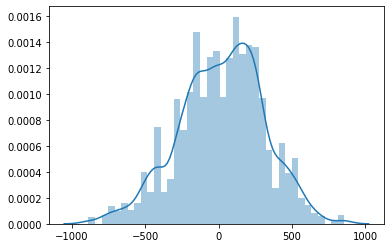

In [17]:
sns.distplot(relative_reward_list)

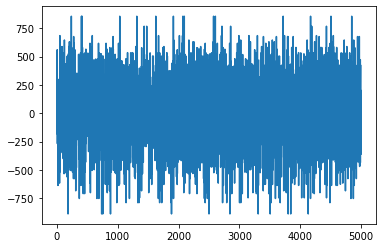

In [18]:
plt.plot(relative_reward_list)

In [19]:
np.median(relative_reward_list)

31.87248479493428

In [20]:
np.mean(relative_reward_list)

19.049942710170562

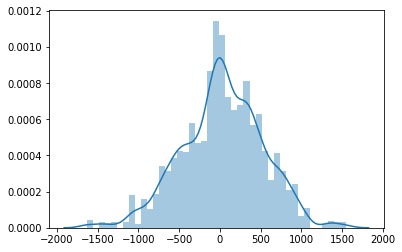

In [21]:
sns.distplot(reward_list)

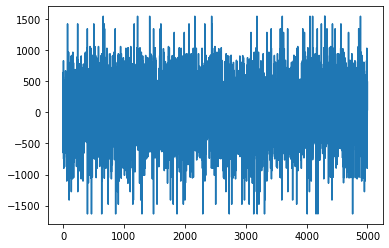

In [22]:
plt.plot(reward_list)

In [23]:
np.median(reward_list)

42.51771629565337

In [24]:
np.mean(reward_list)

31.9856747101705

In [25]:
np.std(reward_list)

500.07956848870873

In [26]:
np.std(relative_reward_list)

291.1466966476973

In [34]:
stats.ttest_1samp(np.array(relative_reward_list), 0)

Ttest_1sampResult(statistic=4.62618903972983, pvalue=3.818614916807584e-06)

In [28]:
SPX_reward_list = np.array(reward_list) - np.array(relative_reward_list)

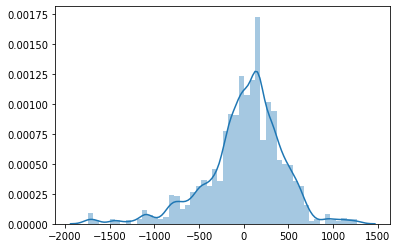

In [29]:
sns.distplot(SPX_reward_list)

In [30]:
np.median(SPX_reward_list)

65.16999999999825

In [31]:
np.mean(SPX_reward_list)

12.935731999999934

In [32]:
np.std(SPX_reward_list)

429.11137775502095

# Train Env

In [ ]:
actor_weights = os.path.join(weights, 'ddpg_actor_weights')
critic_weights =os.path.join(weights, 'ddpg_critic_weights')

actor.load_state_dict(torch.load(actor_weights))
critic.load_state_dict(torch.load(critic_weights))

train_reward_list = []
train_relative_reward_list = []
for i_episode in range(5000):

    state = get_state_tensor(train_env.reset(worth))    
    episode_reward = 0
    relative_episode_reward = 0
    if train_env.date!=train_env.end_date:
        for t in range(1, 100):

            action = select_action(state)
            print(train_env.share)
            print(train_env.SPX_worth)
            
            next_state, reward, SPX_reward, done = train_env.step(action) # env.step() takes numpy array as inputs
            episode_reward += reward
            relative_episode_reward += (reward - SPX_reward)

            next_state = get_state_tensor(next_state)
            state = next_state

            if done:
                break  
#         print("Episode {} reward: {}".format(str(train_env.date), str(episode_reward)))
        
    train_reward_list += [episode_reward]
    train_relative_reward_list +=[relative_episode_reward]

In [ ]:
sns.distplot(train_relative_reward_list)

In [ ]:
np.median(train_relative_reward_list)

In [ ]:
np.mean(train_relative_reward_list)

In [ ]:
stats.ttest_1samp(np.array(reward_list), 0)

In [ ]:
sns.distplot(train_reward_list)

In [ ]:
plt.plot(train_reward_list)

In [ ]:
np.median(train_reward_list)

In [ ]:
np.mean(train_reward_list)

In [ ]:
np.std(train_reward_list)